<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-19 19:33:59.757046: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-19 19:33:59.788533: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-19 19:33:59.788556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-19 19:33:59.789579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-19 19:33:59.794884: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-19 19:33:59.795559: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-19 19:34:00.509854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-19 19:34:02.805236: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 90ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

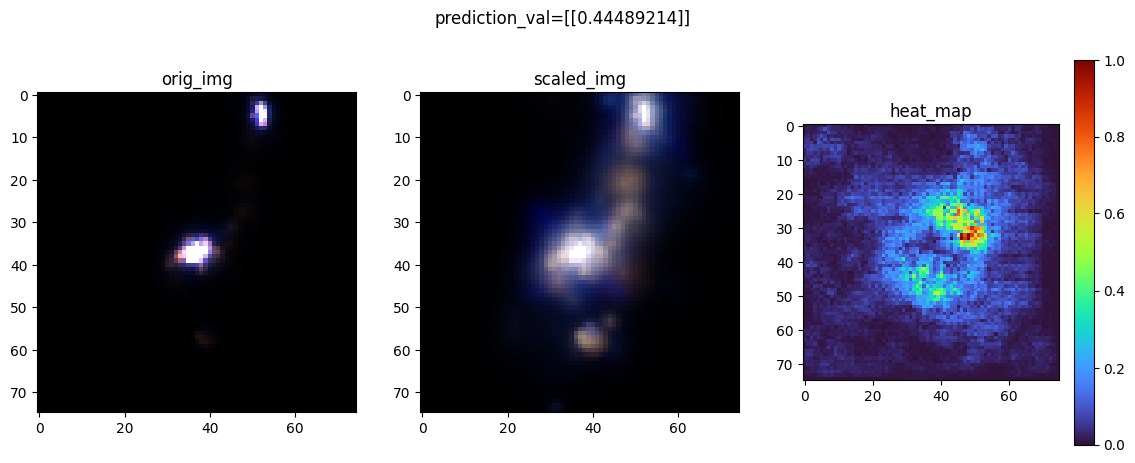

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

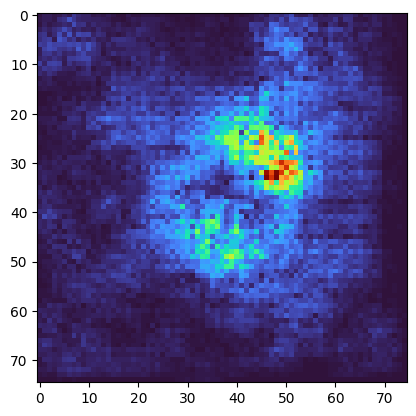

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-19 19:34:05.702537: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-19 19:34:06.535035: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-19 19:34:06.605169: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-19 19:34:06.645002: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-19 19:34:08.089753: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

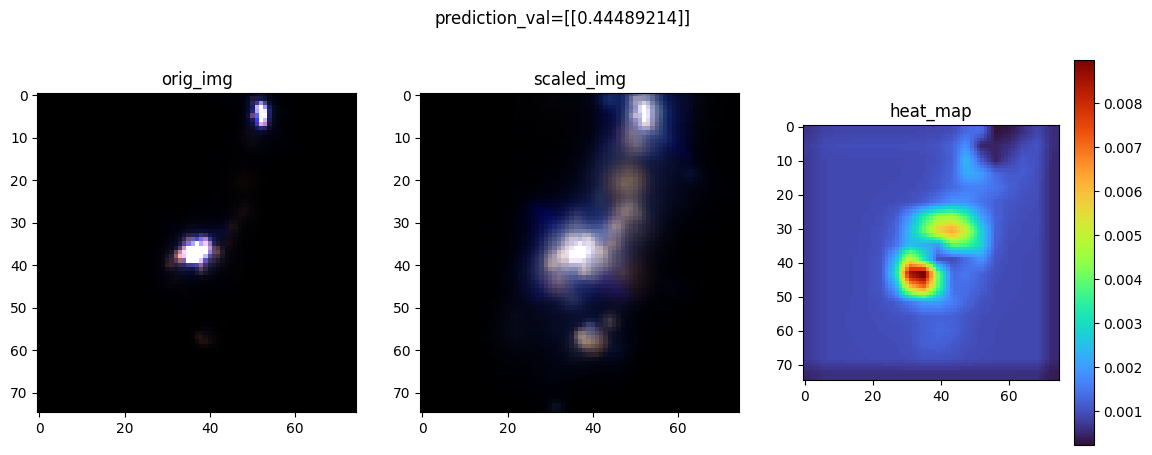

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 4/32 [==>...........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

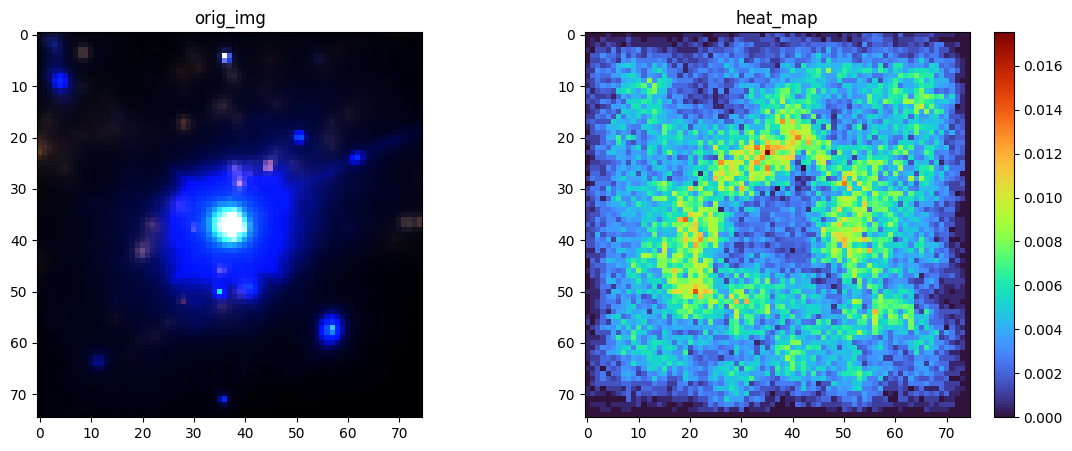

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:09 - loss: 0.7098 - accuracy: 0.5000

  2/338 [..............................] - ETA: 19s - loss: 0.7106 - accuracy: 0.4688 

  3/338 [..............................] - ETA: 19s - loss: 0.7091 - accuracy: 0.5104

  4/338 [..............................] - ETA: 19s - loss: 0.7089 - accuracy: 0.5078

  5/338 [..............................] - ETA: 18s - loss: 0.7087 - accuracy: 0.5063

  6/338 [..............................] - ETA: 18s - loss: 0.7082 - accuracy: 0.5104

  7/338 [..............................] - ETA: 18s - loss: 0.7079 - accuracy: 0.5134

  8/338 [..............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.5156

  9/338 [..............................] - ETA: 18s - loss: 0.7064 - accuracy: 0.5417

 10/338 [..............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.5375

 11/338 [..............................] - ETA: 18s - loss: 0.7059 - accuracy: 0.5426

 12/338 [>.............................] - ETA: 18s - loss: 0.7058 - accuracy: 0.5391

 13/338 [>.............................] - ETA: 18s - loss: 0.7057 - accuracy: 0.5337

 14/338 [>.............................] - ETA: 18s - loss: 0.7058 - accuracy: 0.5268

 15/338 [>.............................] - ETA: 17s - loss: 0.7054 - accuracy: 0.5292

 16/338 [>.............................] - ETA: 17s - loss: 0.7049 - accuracy: 0.5371

 17/338 [>.............................] - ETA: 17s - loss: 0.7048 - accuracy: 0.5331

 18/338 [>.............................] - ETA: 17s - loss: 0.7045 - accuracy: 0.5347

 19/338 [>.............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.5329

 20/338 [>.............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.5219

 21/338 [>.............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.5208

 22/338 [>.............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.5213

 23/338 [=>............................] - ETA: 17s - loss: 0.7035 - accuracy: 0.5299

 24/338 [=>............................] - ETA: 17s - loss: 0.7032 - accuracy: 0.5326

 25/338 [=>............................] - ETA: 17s - loss: 0.7032 - accuracy: 0.5300

 26/338 [=>............................] - ETA: 17s - loss: 0.7030 - accuracy: 0.5288

 27/338 [=>............................] - ETA: 17s - loss: 0.7029 - accuracy: 0.5278

 28/338 [=>............................] - ETA: 17s - loss: 0.7026 - accuracy: 0.5301

 29/338 [=>............................] - ETA: 17s - loss: 0.7027 - accuracy: 0.5248

 30/338 [=>............................] - ETA: 17s - loss: 0.7022 - accuracy: 0.5302

 31/338 [=>............................] - ETA: 17s - loss: 0.7022 - accuracy: 0.5272

 32/338 [=>............................] - ETA: 16s - loss: 0.7022 - accuracy: 0.5244

 33/338 [=>............................] - ETA: 16s - loss: 0.7022 - accuracy: 0.5218

 34/338 [==>...........................] - ETA: 16s - loss: 0.7020 - accuracy: 0.5211

 35/338 [==>...........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.5196

 36/338 [==>...........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.5139

 37/338 [==>...........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.5152

 38/338 [==>...........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.5099

 39/338 [==>...........................] - ETA: 16s - loss: 0.7020 - accuracy: 0.5088

 40/338 [==>...........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.5102

 41/338 [==>...........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.5069

 42/338 [==>...........................] - ETA: 16s - loss: 0.7015 - accuracy: 0.5104

 43/338 [==>...........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.5102

 44/338 [==>...........................] - ETA: 16s - loss: 0.7013 - accuracy: 0.5099

 45/338 [==>...........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.5097

 46/338 [===>..........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.5082

 47/338 [===>..........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.5066

 48/338 [===>..........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5085

 49/338 [===>..........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.5096

 50/338 [===>..........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.5106

 51/338 [===>..........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.5110

 52/338 [===>..........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.5108

 53/338 [===>..........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.5130

 54/338 [===>..........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5139

 55/338 [===>..........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.5148

 56/338 [===>..........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.5162

 57/338 [====>.........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.5137

 58/338 [====>.........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.5156

 59/338 [====>.........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5164

 60/338 [====>.........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5161

 61/338 [====>.........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5143

 62/338 [====>.........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5151

 63/338 [====>.........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5164

 64/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5181

 65/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5216

 66/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5208

 67/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5173

 68/338 [=====>........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5179

 69/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5186

 70/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5192

 71/338 [=====>........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5189

 72/338 [=====>........................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5208

 73/338 [=====>........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5218

 74/338 [=====>........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5245

 75/338 [=====>........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5238

 76/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5251

 77/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5244

 78/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5232

 79/338 [======>.......................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5225

 80/338 [======>.......................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5215

 81/338 [======>.......................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5212

 82/338 [======>.......................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5194

 83/338 [======>.......................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5207

 84/338 [======>.......................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5208

 85/338 [======>.......................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5199

 86/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5193

 87/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5190

 88/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5188

 89/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5190

 90/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5188

 91/338 [=======>......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5168

 92/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5153

 93/338 [=======>......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5155

 94/338 [=======>......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5150

 95/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5151

 96/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5150

 97/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5151

 98/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5140

 99/338 [=======>......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5148

100/338 [=======>......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5131

101/338 [=======>......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5136

102/338 [========>.....................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5159

103/338 [========>.....................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5161

104/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5150

105/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5140

106/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5124

107/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5129

108/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5133

109/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5140

110/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5136

111/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5141

112/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5145

113/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5149

114/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5148

115/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5147

116/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5143

117/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5144

118/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5156

119/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5155

120/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5156

121/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5152

122/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5169

123/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5178

124/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5184

125/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5180

126/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5174

127/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5182

128/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5188

129/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5179

130/338 [==========>...................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5188

131/338 [==========>...................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5191

132/338 [==========>...................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5180

133/338 [==========>...................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5186

134/338 [==========>...................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5177

135/338 [==========>...................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5183

136/338 [===========>..................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5182

137/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5167

138/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5161

139/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5164

140/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5156

141/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5157

142/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5163

143/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5164

144/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5167

145/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5175

146/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5167

147/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5174

148/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5169

149/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5174

150/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5175

151/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5163

152/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5177

153/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5180

154/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5183

155/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5190

156/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5182

157/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5181

158/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5190 

159/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5195

160/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5197

161/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5204

162/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5201

163/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5201

164/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5204

165/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5206

166/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5201

167/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5206

168/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5210

169/338 [==============>...............] - ETA: 9s - loss: 0.6957 - accuracy: 0.5211

170/338 [==============>...............] - ETA: 9s - loss: 0.6957 - accuracy: 0.5210

171/338 [==============>...............] - ETA: 9s - loss: 0.6957 - accuracy: 0.5208

172/338 [==============>...............] - ETA: 9s - loss: 0.6957 - accuracy: 0.5207

173/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5210

174/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5214

175/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5214

176/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5211

177/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5207

178/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5212

179/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5208

180/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5201

181/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5195

182/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5197

183/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5200

184/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5194

185/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5193

186/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5192

187/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5187

188/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5186

189/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5198

190/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5202

191/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5208

192/338 [================>.............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5207

193/338 [================>.............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5215

194/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5217

195/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5215

196/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5217

197/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5216

198/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5219

199/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5220

200/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5220

201/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5216

202/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5218

203/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5223

204/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5221

205/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5220

206/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5217

207/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5228

208/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5230

209/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5236

210/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5243

211/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5247

212/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5245

213/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5249

214/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5245

215/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5246

216/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5252

217/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5255

218/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5252

219/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5254

220/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5249

221/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5255

222/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5258

223/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5261

224/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5255

225/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5256

226/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5260

227/338 [===================>..........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5264

228/338 [===================>..........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5269

229/338 [===================>..........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5269

230/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5273

231/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5269

232/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5265

233/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5259

234/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5259

235/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5262

236/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5262

237/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5262

238/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5265

239/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5265

240/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5264

241/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5267

242/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5269

243/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5269

244/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5268

245/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5264

246/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5262

247/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5262

248/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5265

249/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5265

250/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5271

251/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5275

252/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5274

253/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5273

254/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5276

255/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5276

256/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5277

257/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5277

258/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5279

259/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5279

260/338 [======================>.......] - ETA: 4s - loss: 0.6937 - accuracy: 0.5274

261/338 [======================>.......] - ETA: 4s - loss: 0.6937 - accuracy: 0.5274

262/338 [======================>.......] - ETA: 4s - loss: 0.6937 - accuracy: 0.5276

263/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5280

264/338 [======================>.......] - ETA: 4s - loss: 0.6936 - accuracy: 0.5282

265/338 [======================>.......] - ETA: 4s - loss: 0.6935 - accuracy: 0.5284

266/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5284

267/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5284

268/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5286

269/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5286

270/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5280

271/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5285

272/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5288

273/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5288

274/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5285

275/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5288

276/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5288

277/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5291

278/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5288

279/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5284

280/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5290

281/338 [=======================>......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5295

282/338 [========================>.....] - ETA: 3s - loss: 0.6932 - accuracy: 0.5297

283/338 [========================>.....] - ETA: 3s - loss: 0.6932 - accuracy: 0.5295

284/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5292

285/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5289

286/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5290

287/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5292

288/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5292

289/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5291

290/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5293

291/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5296

292/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5294

293/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5290

294/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5288

295/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5290

296/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5285

297/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5287

298/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5288

299/338 [=========================>....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5293

300/338 [=========================>....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5293

301/338 [=========================>....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5290

302/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5290

303/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5285

304/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5285

305/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5286

306/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5288

307/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5282

308/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5281

309/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5277

310/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5278

311/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5276

312/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5275

313/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5278

314/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5276

315/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5283

316/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5282

317/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5282

318/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5280

319/338 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.5278

320/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5282

321/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5282

322/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5284

323/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5283

324/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5283

325/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5284

326/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5286

327/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5283

328/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5282

329/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5278

330/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5278

331/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5279

332/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5284

333/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5283

334/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5281

335/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5281

336/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5276

337/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5274

338/338 [==============================] - 22s 61ms/step - loss: 0.6928 - accuracy: 0.5271 - val_loss: 0.6904 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6939 - accuracy: 0.4688

  2/338 [..............................] - ETA: 18s - loss: 0.6931 - accuracy: 0.4844

  3/338 [..............................] - ETA: 18s - loss: 0.6913 - accuracy: 0.5000

  4/338 [..............................] - ETA: 18s - loss: 0.6882 - accuracy: 0.5391

  5/338 [..............................] - ETA: 18s - loss: 0.6904 - accuracy: 0.5250

  6/338 [..............................] - ETA: 18s - loss: 0.6896 - accuracy: 0.5312

  7/338 [..............................] - ETA: 18s - loss: 0.6891 - accuracy: 0.5357

  8/338 [..............................] - ETA: 18s - loss: 0.6880 - accuracy: 0.5352

  9/338 [..............................] - ETA: 18s - loss: 0.6873 - accuracy: 0.5347

 10/338 [..............................] - ETA: 18s - loss: 0.6866 - accuracy: 0.5406

 11/338 [..............................] - ETA: 18s - loss: 0.6865 - accuracy: 0.5398

 12/338 [>.............................] - ETA: 18s - loss: 0.6868 - accuracy: 0.5365

 13/338 [>.............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5361

 14/338 [>.............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5335

 15/338 [>.............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5250

 16/338 [>.............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5312

 17/338 [>.............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5368

 18/338 [>.............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5399

 19/338 [>.............................] - ETA: 17s - loss: 0.6875 - accuracy: 0.5428

 20/338 [>.............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5391

 21/338 [>.............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5461

 22/338 [>.............................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5426

 23/338 [=>............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5448

 24/338 [=>............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5443

 25/338 [=>............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5437

 26/338 [=>............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5469

 27/338 [=>............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5417

 28/338 [=>............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5491

 29/338 [=>............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5506

 30/338 [=>............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5531

 31/338 [=>............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5554

 32/338 [=>............................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5566

 33/338 [=>............................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5578

 34/338 [==>...........................] - ETA: 16s - loss: 0.6857 - accuracy: 0.5542

 35/338 [==>...........................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5491

 36/338 [==>...........................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5521

 37/338 [==>...........................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5557

 38/338 [==>...........................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5543

 39/338 [==>...........................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5521

 40/338 [==>...........................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5531

 41/338 [==>...........................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5518

 42/338 [==>...........................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5521

 43/338 [==>...........................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5523

 44/338 [==>...........................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5504

 45/338 [==>...........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5451

 46/338 [===>..........................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5435

 47/338 [===>..........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5439

 48/338 [===>..........................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5456

 49/338 [===>..........................] - ETA: 16s - loss: 0.6860 - accuracy: 0.5453

 50/338 [===>..........................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5456

 51/338 [===>..........................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5435

 52/338 [===>..........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5439

 53/338 [===>..........................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5436

 54/338 [===>..........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5446

 55/338 [===>..........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5420

 56/338 [===>..........................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5419

 57/338 [====>.........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5400

 58/338 [====>.........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5393

 59/338 [====>.........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5365

 60/338 [====>.........................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5385

 61/338 [====>.........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5379

 62/338 [====>.........................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5363

 63/338 [====>.........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5367

 64/338 [====>.........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5361

 65/338 [====>.........................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5365

 66/338 [====>.........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5355

 67/338 [====>.........................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5350

 68/338 [=====>........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5358

 69/338 [=====>........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5344

 70/338 [=====>........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5339

 71/338 [=====>........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5348

 72/338 [=====>........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5347

 73/338 [=====>........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5351

 74/338 [=====>........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5355

 75/338 [=====>........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5362

 76/338 [=====>........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5350

 77/338 [=====>........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5357

 78/338 [=====>........................] - ETA: 14s - loss: 0.6860 - accuracy: 0.5369

 79/338 [======>.......................] - ETA: 14s - loss: 0.6860 - accuracy: 0.5364

 80/338 [======>.......................] - ETA: 14s - loss: 0.6856 - accuracy: 0.5387

 81/338 [======>.......................] - ETA: 14s - loss: 0.6856 - accuracy: 0.5386

 82/338 [======>.......................] - ETA: 14s - loss: 0.6857 - accuracy: 0.5370

 83/338 [======>.......................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5380

 84/338 [======>.......................] - ETA: 14s - loss: 0.6852 - accuracy: 0.5402

 85/338 [======>.......................] - ETA: 14s - loss: 0.6853 - accuracy: 0.5397

 86/338 [======>.......................] - ETA: 13s - loss: 0.6853 - accuracy: 0.5389

 87/338 [======>.......................] - ETA: 13s - loss: 0.6855 - accuracy: 0.5381

 88/338 [======>.......................] - ETA: 13s - loss: 0.6856 - accuracy: 0.5373

 89/338 [======>.......................] - ETA: 13s - loss: 0.6857 - accuracy: 0.5358

 90/338 [======>.......................] - ETA: 13s - loss: 0.6857 - accuracy: 0.5365

 91/338 [=======>......................] - ETA: 13s - loss: 0.6855 - accuracy: 0.5371

 92/338 [=======>......................] - ETA: 13s - loss: 0.6854 - accuracy: 0.5384

 93/338 [=======>......................] - ETA: 13s - loss: 0.6854 - accuracy: 0.5386

 94/338 [=======>......................] - ETA: 13s - loss: 0.6854 - accuracy: 0.5382

 95/338 [=======>......................] - ETA: 13s - loss: 0.6854 - accuracy: 0.5385

 96/338 [=======>......................] - ETA: 13s - loss: 0.6855 - accuracy: 0.5381

 97/338 [=======>......................] - ETA: 13s - loss: 0.6854 - accuracy: 0.5393

 98/338 [=======>......................] - ETA: 13s - loss: 0.6853 - accuracy: 0.5392

 99/338 [=======>......................] - ETA: 13s - loss: 0.6851 - accuracy: 0.5407

100/338 [=======>......................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5403

101/338 [=======>......................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5408

102/338 [========>.....................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5398

103/338 [========>.....................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5391

104/338 [========>.....................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5397

105/338 [========>.....................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5396

106/338 [========>.....................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5410

107/338 [========>.....................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5412

108/338 [========>.....................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5414

109/338 [========>.....................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5399

110/338 [========>.....................] - ETA: 12s - loss: 0.6854 - accuracy: 0.5378

111/338 [========>.....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5372

112/338 [========>.....................] - ETA: 12s - loss: 0.6854 - accuracy: 0.5379

113/338 [=========>....................] - ETA: 12s - loss: 0.6855 - accuracy: 0.5371

114/338 [=========>....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5359

115/338 [=========>....................] - ETA: 12s - loss: 0.6857 - accuracy: 0.5353

116/338 [=========>....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5356

117/338 [=========>....................] - ETA: 12s - loss: 0.6857 - accuracy: 0.5350

118/338 [=========>....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5344

119/338 [=========>....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5339

120/338 [=========>....................] - ETA: 12s - loss: 0.6857 - accuracy: 0.5331

121/338 [=========>....................] - ETA: 12s - loss: 0.6857 - accuracy: 0.5331

122/338 [=========>....................] - ETA: 11s - loss: 0.6856 - accuracy: 0.5330

123/338 [=========>....................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5328

124/338 [==========>...................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5335

125/338 [==========>...................] - ETA: 11s - loss: 0.6854 - accuracy: 0.5340

126/338 [==========>...................] - ETA: 11s - loss: 0.6854 - accuracy: 0.5335

127/338 [==========>...................] - ETA: 11s - loss: 0.6854 - accuracy: 0.5337

128/338 [==========>...................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5349

129/338 [==========>...................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5359

130/338 [==========>...................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5363

131/338 [==========>...................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5358

132/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5365

133/338 [==========>...................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5364

134/338 [==========>...................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5361

135/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5356

136/338 [===========>..................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5349

137/338 [===========>..................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5349

138/338 [===========>..................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5353

139/338 [===========>..................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5346

140/338 [===========>..................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5342

141/338 [===========>..................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5357

142/338 [===========>..................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5359

143/338 [===========>..................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5354

144/338 [===========>..................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5349

145/338 [===========>..................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5347

146/338 [===========>..................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5355

147/338 [============>.................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5353

148/338 [============>.................] - ETA: 10s - loss: 0.6843 - accuracy: 0.5359

149/338 [============>.................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5354

150/338 [============>.................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5346

151/338 [============>.................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5356

152/338 [============>.................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5354

153/338 [============>.................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5355

154/338 [============>.................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5351

155/338 [============>.................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5359

156/338 [============>.................] - ETA: 10s - loss: 0.6843 - accuracy: 0.5363

157/338 [============>.................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5352

158/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5350 

159/338 [=============>................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5356

160/338 [=============>................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5355

161/338 [=============>................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5361

162/338 [=============>................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5363

163/338 [=============>................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5357

164/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5356

165/338 [=============>................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5347

166/338 [=============>................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5348

167/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5350

168/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5346

169/338 [==============>...............] - ETA: 9s - loss: 0.6844 - accuracy: 0.5344

170/338 [==============>...............] - ETA: 9s - loss: 0.6843 - accuracy: 0.5347

171/338 [==============>...............] - ETA: 9s - loss: 0.6843 - accuracy: 0.5340

172/338 [==============>...............] - ETA: 9s - loss: 0.6843 - accuracy: 0.5342

173/338 [==============>...............] - ETA: 9s - loss: 0.6843 - accuracy: 0.5345

174/338 [==============>...............] - ETA: 9s - loss: 0.6843 - accuracy: 0.5350

175/338 [==============>...............] - ETA: 9s - loss: 0.6843 - accuracy: 0.5355

176/338 [==============>...............] - ETA: 8s - loss: 0.6843 - accuracy: 0.5353

177/338 [==============>...............] - ETA: 8s - loss: 0.6843 - accuracy: 0.5351

178/338 [==============>...............] - ETA: 8s - loss: 0.6844 - accuracy: 0.5355

179/338 [==============>...............] - ETA: 8s - loss: 0.6843 - accuracy: 0.5361

180/338 [==============>...............] - ETA: 8s - loss: 0.6842 - accuracy: 0.5370

181/338 [===============>..............] - ETA: 8s - loss: 0.6842 - accuracy: 0.5383

182/338 [===============>..............] - ETA: 8s - loss: 0.6840 - accuracy: 0.5390

183/338 [===============>..............] - ETA: 8s - loss: 0.6840 - accuracy: 0.5394

184/338 [===============>..............] - ETA: 8s - loss: 0.6840 - accuracy: 0.5394

185/338 [===============>..............] - ETA: 8s - loss: 0.6840 - accuracy: 0.5400

186/338 [===============>..............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5410

187/338 [===============>..............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5413

188/338 [===============>..............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5412

189/338 [===============>..............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5417

190/338 [===============>..............] - ETA: 8s - loss: 0.6838 - accuracy: 0.5426

191/338 [===============>..............] - ETA: 8s - loss: 0.6838 - accuracy: 0.5425

192/338 [================>.............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5430

193/338 [================>.............] - ETA: 8s - loss: 0.6838 - accuracy: 0.5434

194/338 [================>.............] - ETA: 7s - loss: 0.6839 - accuracy: 0.5433

195/338 [================>.............] - ETA: 7s - loss: 0.6840 - accuracy: 0.5429

196/338 [================>.............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5419

197/338 [================>.............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5430

198/338 [================>.............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5434

199/338 [================>.............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5440

200/338 [================>.............] - ETA: 7s - loss: 0.6840 - accuracy: 0.5448

201/338 [================>.............] - ETA: 7s - loss: 0.6840 - accuracy: 0.5451

202/338 [================>.............] - ETA: 7s - loss: 0.6840 - accuracy: 0.5458

203/338 [=================>............] - ETA: 7s - loss: 0.6840 - accuracy: 0.5459

204/338 [=================>............] - ETA: 7s - loss: 0.6842 - accuracy: 0.5453

205/338 [=================>............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5460

206/338 [=================>............] - ETA: 7s - loss: 0.6842 - accuracy: 0.5469

207/338 [=================>............] - ETA: 7s - loss: 0.6842 - accuracy: 0.5473

208/338 [=================>............] - ETA: 7s - loss: 0.6842 - accuracy: 0.5475

209/338 [=================>............] - ETA: 7s - loss: 0.6842 - accuracy: 0.5480

210/338 [=================>............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5485

211/338 [=================>............] - ETA: 7s - loss: 0.6842 - accuracy: 0.5490

212/338 [=================>............] - ETA: 6s - loss: 0.6841 - accuracy: 0.5497

213/338 [=================>............] - ETA: 6s - loss: 0.6841 - accuracy: 0.5500

214/338 [=================>............] - ETA: 6s - loss: 0.6841 - accuracy: 0.5505

215/338 [==================>...........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5506

216/338 [==================>...........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5505

217/338 [==================>...........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5505

218/338 [==================>...........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5503

219/338 [==================>...........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5509

220/338 [==================>...........] - ETA: 6s - loss: 0.6842 - accuracy: 0.5510

221/338 [==================>...........] - ETA: 6s - loss: 0.6842 - accuracy: 0.5513

222/338 [==================>...........] - ETA: 6s - loss: 0.6842 - accuracy: 0.5514

223/338 [==================>...........] - ETA: 6s - loss: 0.6842 - accuracy: 0.5518

224/338 [==================>...........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5525

225/338 [==================>...........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5526

226/338 [===================>..........] - ETA: 6s - loss: 0.6842 - accuracy: 0.5527

227/338 [===================>..........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5533

228/338 [===================>..........] - ETA: 6s - loss: 0.6841 - accuracy: 0.5537

229/338 [===================>..........] - ETA: 6s - loss: 0.6840 - accuracy: 0.5540

230/338 [===================>..........] - ETA: 5s - loss: 0.6840 - accuracy: 0.5542

231/338 [===================>..........] - ETA: 5s - loss: 0.6840 - accuracy: 0.5547

232/338 [===================>..........] - ETA: 5s - loss: 0.6839 - accuracy: 0.5552

233/338 [===================>..........] - ETA: 5s - loss: 0.6840 - accuracy: 0.5550

234/338 [===================>..........] - ETA: 5s - loss: 0.6839 - accuracy: 0.5556

235/338 [===================>..........] - ETA: 5s - loss: 0.6839 - accuracy: 0.5556

236/338 [===================>..........] - ETA: 5s - loss: 0.6839 - accuracy: 0.5559

237/338 [====================>.........] - ETA: 5s - loss: 0.6838 - accuracy: 0.5562

238/338 [====================>.........] - ETA: 5s - loss: 0.6839 - accuracy: 0.5558

239/338 [====================>.........] - ETA: 5s - loss: 0.6837 - accuracy: 0.5570

240/338 [====================>.........] - ETA: 5s - loss: 0.6836 - accuracy: 0.5574

241/338 [====================>.........] - ETA: 5s - loss: 0.6836 - accuracy: 0.5582

242/338 [====================>.........] - ETA: 5s - loss: 0.6835 - accuracy: 0.5586

243/338 [====================>.........] - ETA: 5s - loss: 0.6836 - accuracy: 0.5586

244/338 [====================>.........] - ETA: 5s - loss: 0.6834 - accuracy: 0.5598

245/338 [====================>.........] - ETA: 5s - loss: 0.6834 - accuracy: 0.5603

246/338 [====================>.........] - ETA: 5s - loss: 0.6834 - accuracy: 0.5603

247/338 [====================>.........] - ETA: 5s - loss: 0.6835 - accuracy: 0.5602

248/338 [=====================>........] - ETA: 4s - loss: 0.6834 - accuracy: 0.5609

249/338 [=====================>........] - ETA: 4s - loss: 0.6834 - accuracy: 0.5607

250/338 [=====================>........] - ETA: 4s - loss: 0.6836 - accuracy: 0.5604

251/338 [=====================>........] - ETA: 4s - loss: 0.6836 - accuracy: 0.5603

252/338 [=====================>........] - ETA: 4s - loss: 0.6836 - accuracy: 0.5605

253/338 [=====================>........] - ETA: 4s - loss: 0.6836 - accuracy: 0.5605

254/338 [=====================>........] - ETA: 4s - loss: 0.6837 - accuracy: 0.5605

255/338 [=====================>........] - ETA: 4s - loss: 0.6838 - accuracy: 0.5605

256/338 [=====================>........] - ETA: 4s - loss: 0.6837 - accuracy: 0.5610

257/338 [=====================>........] - ETA: 4s - loss: 0.6836 - accuracy: 0.5616

258/338 [=====================>........] - ETA: 4s - loss: 0.6837 - accuracy: 0.5619

259/338 [=====================>........] - ETA: 4s - loss: 0.6836 - accuracy: 0.5625

260/338 [======================>.......] - ETA: 4s - loss: 0.6837 - accuracy: 0.5625

261/338 [======================>.......] - ETA: 4s - loss: 0.6837 - accuracy: 0.5626

262/338 [======================>.......] - ETA: 4s - loss: 0.6837 - accuracy: 0.5630

263/338 [======================>.......] - ETA: 4s - loss: 0.6837 - accuracy: 0.5633

264/338 [======================>.......] - ETA: 4s - loss: 0.6837 - accuracy: 0.5630

265/338 [======================>.......] - ETA: 4s - loss: 0.6837 - accuracy: 0.5634

266/338 [======================>.......] - ETA: 3s - loss: 0.6837 - accuracy: 0.5638

267/338 [======================>.......] - ETA: 3s - loss: 0.6836 - accuracy: 0.5641

268/338 [======================>.......] - ETA: 3s - loss: 0.6836 - accuracy: 0.5642

269/338 [======================>.......] - ETA: 3s - loss: 0.6836 - accuracy: 0.5645

270/338 [======================>.......] - ETA: 3s - loss: 0.6836 - accuracy: 0.5648

271/338 [=======================>......] - ETA: 3s - loss: 0.6835 - accuracy: 0.5655

272/338 [=======================>......] - ETA: 3s - loss: 0.6834 - accuracy: 0.5658

273/338 [=======================>......] - ETA: 3s - loss: 0.6834 - accuracy: 0.5658

274/338 [=======================>......] - ETA: 3s - loss: 0.6834 - accuracy: 0.5658

275/338 [=======================>......] - ETA: 3s - loss: 0.6834 - accuracy: 0.5661

276/338 [=======================>......] - ETA: 3s - loss: 0.6834 - accuracy: 0.5662

277/338 [=======================>......] - ETA: 3s - loss: 0.6834 - accuracy: 0.5663

278/338 [=======================>......] - ETA: 3s - loss: 0.6834 - accuracy: 0.5665

279/338 [=======================>......] - ETA: 3s - loss: 0.6834 - accuracy: 0.5669

280/338 [=======================>......] - ETA: 3s - loss: 0.6833 - accuracy: 0.5675

281/338 [=======================>......] - ETA: 3s - loss: 0.6833 - accuracy: 0.5679

282/338 [========================>.....] - ETA: 3s - loss: 0.6833 - accuracy: 0.5682

283/338 [========================>.....] - ETA: 3s - loss: 0.6832 - accuracy: 0.5684

284/338 [========================>.....] - ETA: 2s - loss: 0.6832 - accuracy: 0.5689

285/338 [========================>.....] - ETA: 2s - loss: 0.6831 - accuracy: 0.5692

286/338 [========================>.....] - ETA: 2s - loss: 0.6831 - accuracy: 0.5691

287/338 [========================>.....] - ETA: 2s - loss: 0.6832 - accuracy: 0.5689

288/338 [========================>.....] - ETA: 2s - loss: 0.6832 - accuracy: 0.5689

289/338 [========================>.....] - ETA: 2s - loss: 0.6832 - accuracy: 0.5689

290/338 [========================>.....] - ETA: 2s - loss: 0.6831 - accuracy: 0.5696

291/338 [========================>.....] - ETA: 2s - loss: 0.6830 - accuracy: 0.5699

292/338 [========================>.....] - ETA: 2s - loss: 0.6830 - accuracy: 0.5700

293/338 [=========================>....] - ETA: 2s - loss: 0.6829 - accuracy: 0.5706

294/338 [=========================>....] - ETA: 2s - loss: 0.6829 - accuracy: 0.5711

295/338 [=========================>....] - ETA: 2s - loss: 0.6829 - accuracy: 0.5712

296/338 [=========================>....] - ETA: 2s - loss: 0.6828 - accuracy: 0.5716

297/338 [=========================>....] - ETA: 2s - loss: 0.6828 - accuracy: 0.5717

298/338 [=========================>....] - ETA: 2s - loss: 0.6828 - accuracy: 0.5716

299/338 [=========================>....] - ETA: 2s - loss: 0.6828 - accuracy: 0.5719

300/338 [=========================>....] - ETA: 2s - loss: 0.6827 - accuracy: 0.5724

301/338 [=========================>....] - ETA: 2s - loss: 0.6828 - accuracy: 0.5722

302/338 [=========================>....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5730

303/338 [=========================>....] - ETA: 1s - loss: 0.6826 - accuracy: 0.5734

304/338 [=========================>....] - ETA: 1s - loss: 0.6827 - accuracy: 0.5732

305/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.5733

306/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.5734

307/338 [==========================>...] - ETA: 1s - loss: 0.6826 - accuracy: 0.5737

308/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.5735

309/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.5736

310/338 [==========================>...] - ETA: 1s - loss: 0.6826 - accuracy: 0.5742

311/338 [==========================>...] - ETA: 1s - loss: 0.6826 - accuracy: 0.5746

312/338 [==========================>...] - ETA: 1s - loss: 0.6826 - accuracy: 0.5744

313/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.5744

314/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.5746

315/338 [==========================>...] - ETA: 1s - loss: 0.6827 - accuracy: 0.5749

316/338 [===========================>..] - ETA: 1s - loss: 0.6826 - accuracy: 0.5755

317/338 [===========================>..] - ETA: 1s - loss: 0.6825 - accuracy: 0.5760

318/338 [===========================>..] - ETA: 1s - loss: 0.6824 - accuracy: 0.5765

319/338 [===========================>..] - ETA: 1s - loss: 0.6823 - accuracy: 0.5769

320/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5774

321/338 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.5772

322/338 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.5772

323/338 [===========================>..] - ETA: 0s - loss: 0.6823 - accuracy: 0.5773

324/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5778

325/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5779

326/338 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5779

327/338 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.5786

328/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5791

329/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5792

330/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5791

331/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5792

332/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5792

333/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5790

334/338 [============================>.] - ETA: 0s - loss: 0.6821 - accuracy: 0.5793

335/338 [============================>.] - ETA: 0s - loss: 0.6820 - accuracy: 0.5798

336/338 [============================>.] - ETA: 0s - loss: 0.6820 - accuracy: 0.5799

337/338 [============================>.] - ETA: 0s - loss: 0.6819 - accuracy: 0.5803

338/338 [==============================] - 20s 60ms/step - loss: 0.6819 - accuracy: 0.5805 - val_loss: 0.6729 - val_accuracy: 0.6510


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6757 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.6723 - accuracy: 0.6562

  3/338 [..............................] - ETA: 18s - loss: 0.6783 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6774 - accuracy: 0.6406

  5/338 [..............................] - ETA: 18s - loss: 0.6787 - accuracy: 0.6375

  6/338 [..............................] - ETA: 18s - loss: 0.6814 - accuracy: 0.6198

  7/338 [..............................] - ETA: 18s - loss: 0.6812 - accuracy: 0.6205

  8/338 [..............................] - ETA: 18s - loss: 0.6796 - accuracy: 0.6250

  9/338 [..............................] - ETA: 18s - loss: 0.6791 - accuracy: 0.6250

 10/338 [..............................] - ETA: 18s - loss: 0.6779 - accuracy: 0.6344

 11/338 [..............................] - ETA: 18s - loss: 0.6785 - accuracy: 0.6364

 12/338 [>.............................] - ETA: 17s - loss: 0.6780 - accuracy: 0.6354

 13/338 [>.............................] - ETA: 17s - loss: 0.6773 - accuracy: 0.6394

 14/338 [>.............................] - ETA: 17s - loss: 0.6779 - accuracy: 0.6339

 15/338 [>.............................] - ETA: 17s - loss: 0.6781 - accuracy: 0.6292

 16/338 [>.............................] - ETA: 17s - loss: 0.6775 - accuracy: 0.6328

 17/338 [>.............................] - ETA: 17s - loss: 0.6783 - accuracy: 0.6305

 18/338 [>.............................] - ETA: 17s - loss: 0.6791 - accuracy: 0.6250

 19/338 [>.............................] - ETA: 17s - loss: 0.6791 - accuracy: 0.6217

 20/338 [>.............................] - ETA: 17s - loss: 0.6780 - accuracy: 0.6266

 21/338 [>.............................] - ETA: 17s - loss: 0.6779 - accuracy: 0.6280

 22/338 [>.............................] - ETA: 17s - loss: 0.6769 - accuracy: 0.6307

 23/338 [=>............................] - ETA: 17s - loss: 0.6771 - accuracy: 0.6291

 24/338 [=>............................] - ETA: 17s - loss: 0.6764 - accuracy: 0.6315

 25/338 [=>............................] - ETA: 17s - loss: 0.6772 - accuracy: 0.6275

 26/338 [=>............................] - ETA: 17s - loss: 0.6780 - accuracy: 0.6238

 27/338 [=>............................] - ETA: 17s - loss: 0.6780 - accuracy: 0.6215

 28/338 [=>............................] - ETA: 17s - loss: 0.6782 - accuracy: 0.6183

 29/338 [=>............................] - ETA: 17s - loss: 0.6786 - accuracy: 0.6164

 30/338 [=>............................] - ETA: 17s - loss: 0.6785 - accuracy: 0.6156

 31/338 [=>............................] - ETA: 17s - loss: 0.6789 - accuracy: 0.6129

 32/338 [=>............................] - ETA: 17s - loss: 0.6786 - accuracy: 0.6143

 33/338 [=>............................] - ETA: 16s - loss: 0.6792 - accuracy: 0.6117

 34/338 [==>...........................] - ETA: 16s - loss: 0.6789 - accuracy: 0.6131

 35/338 [==>...........................] - ETA: 16s - loss: 0.6787 - accuracy: 0.6152

 36/338 [==>...........................] - ETA: 16s - loss: 0.6787 - accuracy: 0.6155

 37/338 [==>...........................] - ETA: 16s - loss: 0.6785 - accuracy: 0.6149

 38/338 [==>...........................] - ETA: 16s - loss: 0.6786 - accuracy: 0.6151

 39/338 [==>...........................] - ETA: 16s - loss: 0.6780 - accuracy: 0.6194

 40/338 [==>...........................] - ETA: 16s - loss: 0.6779 - accuracy: 0.6187

 41/338 [==>...........................] - ETA: 16s - loss: 0.6774 - accuracy: 0.6212

 42/338 [==>...........................] - ETA: 16s - loss: 0.6777 - accuracy: 0.6168

 43/338 [==>...........................] - ETA: 16s - loss: 0.6780 - accuracy: 0.6148

 44/338 [==>...........................] - ETA: 16s - loss: 0.6784 - accuracy: 0.6143

 45/338 [==>...........................] - ETA: 16s - loss: 0.6783 - accuracy: 0.6146

 46/338 [===>..........................] - ETA: 16s - loss: 0.6784 - accuracy: 0.6155

 47/338 [===>..........................] - ETA: 16s - loss: 0.6787 - accuracy: 0.6137

 48/338 [===>..........................] - ETA: 16s - loss: 0.6781 - accuracy: 0.6159

 49/338 [===>..........................] - ETA: 15s - loss: 0.6783 - accuracy: 0.6148

 50/338 [===>..........................] - ETA: 15s - loss: 0.6783 - accuracy: 0.6144

 51/338 [===>..........................] - ETA: 15s - loss: 0.6783 - accuracy: 0.6146

 52/338 [===>..........................] - ETA: 15s - loss: 0.6782 - accuracy: 0.6148

 53/338 [===>..........................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6126

 54/338 [===>..........................] - ETA: 15s - loss: 0.6786 - accuracy: 0.6117

 55/338 [===>..........................] - ETA: 15s - loss: 0.6783 - accuracy: 0.6125

 56/338 [===>..........................] - ETA: 15s - loss: 0.6783 - accuracy: 0.6116

 57/338 [====>.........................] - ETA: 15s - loss: 0.6787 - accuracy: 0.6086

 58/338 [====>.........................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6094

 59/338 [====>.........................] - ETA: 15s - loss: 0.6781 - accuracy: 0.6112

 60/338 [====>.........................] - ETA: 15s - loss: 0.6776 - accuracy: 0.6130

 61/338 [====>.........................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6122

 62/338 [====>.........................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6129

 63/338 [====>.........................] - ETA: 15s - loss: 0.6768 - accuracy: 0.6171

 64/338 [====>.........................] - ETA: 15s - loss: 0.6767 - accuracy: 0.6177

 65/338 [====>.........................] - ETA: 15s - loss: 0.6765 - accuracy: 0.6178

 66/338 [====>.........................] - ETA: 15s - loss: 0.6763 - accuracy: 0.6184

 67/338 [====>.........................] - ETA: 14s - loss: 0.6760 - accuracy: 0.6194

 68/338 [=====>........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6204

 69/338 [=====>........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6191

 70/338 [=====>........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6187

 71/338 [=====>........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6188

 72/338 [=====>........................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6181

 73/338 [=====>........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6186

 74/338 [=====>........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6182

 75/338 [=====>........................] - ETA: 14s - loss: 0.6755 - accuracy: 0.6192

 76/338 [=====>........................] - ETA: 14s - loss: 0.6754 - accuracy: 0.6192

 77/338 [=====>........................] - ETA: 14s - loss: 0.6752 - accuracy: 0.6193

 78/338 [=====>........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6186

 79/338 [======>.......................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6187

 80/338 [======>.......................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6191

 81/338 [======>.......................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6169

 82/338 [======>.......................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6147

 83/338 [======>.......................] - ETA: 14s - loss: 0.6760 - accuracy: 0.6152

 84/338 [======>.......................] - ETA: 14s - loss: 0.6760 - accuracy: 0.6157

 85/338 [======>.......................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6151

 86/338 [======>.......................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6156

 87/338 [======>.......................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6157

 88/338 [======>.......................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6136

 89/338 [======>.......................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6134

 90/338 [======>.......................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6132

 91/338 [=======>......................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6133

 92/338 [=======>......................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6128

 93/338 [=======>......................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6126

 94/338 [=======>......................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6127

 95/338 [=======>......................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6115

 96/338 [=======>......................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6130

 97/338 [=======>......................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6121

 98/338 [=======>......................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6126

 99/338 [=======>......................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6108

100/338 [=======>......................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6100

101/338 [=======>......................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6101

102/338 [========>.....................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6109

103/338 [========>.....................] - ETA: 12s - loss: 0.6764 - accuracy: 0.6117

104/338 [========>.....................] - ETA: 12s - loss: 0.6762 - accuracy: 0.6121

105/338 [========>.....................] - ETA: 12s - loss: 0.6762 - accuracy: 0.6116

106/338 [========>.....................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6120

107/338 [========>.....................] - ETA: 12s - loss: 0.6762 - accuracy: 0.6113

108/338 [========>.....................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6114

109/338 [========>.....................] - ETA: 12s - loss: 0.6762 - accuracy: 0.6118

110/338 [========>.....................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6131

111/338 [========>.....................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6129

112/338 [========>.....................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6130

113/338 [=========>....................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6131

114/338 [=========>....................] - ETA: 12s - loss: 0.6758 - accuracy: 0.6140

115/338 [=========>....................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6136

116/338 [=========>....................] - ETA: 12s - loss: 0.6758 - accuracy: 0.6137

117/338 [=========>....................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6127

118/338 [=========>....................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6128

119/338 [=========>....................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6124

120/338 [=========>....................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6130

121/338 [=========>....................] - ETA: 12s - loss: 0.6759 - accuracy: 0.6126

122/338 [=========>....................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6137

123/338 [=========>....................] - ETA: 11s - loss: 0.6758 - accuracy: 0.6138

124/338 [==========>...................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6142

125/338 [==========>...................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6152

126/338 [==========>...................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6163

127/338 [==========>...................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6161

128/338 [==========>...................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6160

129/338 [==========>...................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6156

130/338 [==========>...................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6166

131/338 [==========>...................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6157

132/338 [==========>...................] - ETA: 11s - loss: 0.6751 - accuracy: 0.6155

133/338 [==========>...................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6165

134/338 [==========>...................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6175

135/338 [==========>...................] - ETA: 11s - loss: 0.6751 - accuracy: 0.6164

136/338 [===========>..................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6163

137/338 [===========>..................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6175

138/338 [===========>..................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6178

139/338 [===========>..................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6189

140/338 [===========>..................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6205

141/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6215

142/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6213

143/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6222

144/338 [===========>..................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6213

145/338 [===========>..................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6203

146/338 [===========>..................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6203

147/338 [============>.................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6207

148/338 [============>.................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6208

149/338 [============>.................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6221

150/338 [============>.................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6227

151/338 [============>.................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6227

152/338 [============>.................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6225

153/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6238

154/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6236

155/338 [============>.................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6232

156/338 [============>.................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6224

157/338 [============>.................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6218 

158/338 [=============>................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6222

159/338 [=============>................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6230

160/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6232

161/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6233

162/338 [=============>................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6238

163/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6235

164/338 [=============>................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6237

165/338 [=============>................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6244

166/338 [=============>................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6244

167/338 [=============>................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6248

168/338 [=============>................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6248

169/338 [==============>...............] - ETA: 9s - loss: 0.6731 - accuracy: 0.6246

170/338 [==============>...............] - ETA: 9s - loss: 0.6730 - accuracy: 0.6252

171/338 [==============>...............] - ETA: 9s - loss: 0.6728 - accuracy: 0.6261

172/338 [==============>...............] - ETA: 9s - loss: 0.6727 - accuracy: 0.6263

173/338 [==============>...............] - ETA: 9s - loss: 0.6730 - accuracy: 0.6250

174/338 [==============>...............] - ETA: 9s - loss: 0.6731 - accuracy: 0.6243

175/338 [==============>...............] - ETA: 9s - loss: 0.6732 - accuracy: 0.6241

176/338 [==============>...............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6243

177/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6238

178/338 [==============>...............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6222

179/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6233

180/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6229

181/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6236

182/338 [===============>..............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6238

183/338 [===============>..............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6228

184/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6231

185/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6231

186/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6230

187/338 [===============>..............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6235

188/338 [===============>..............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6238

189/338 [===============>..............] - ETA: 8s - loss: 0.6729 - accuracy: 0.6240

190/338 [===============>..............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6238

191/338 [===============>..............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6239

192/338 [================>.............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6239

193/338 [================>.............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6240

194/338 [================>.............] - ETA: 7s - loss: 0.6728 - accuracy: 0.6250

195/338 [================>.............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6242

196/338 [================>.............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6245

197/338 [================>.............] - ETA: 7s - loss: 0.6727 - accuracy: 0.6253

198/338 [================>.............] - ETA: 7s - loss: 0.6725 - accuracy: 0.6263

199/338 [================>.............] - ETA: 7s - loss: 0.6725 - accuracy: 0.6264

200/338 [================>.............] - ETA: 7s - loss: 0.6724 - accuracy: 0.6269

201/338 [================>.............] - ETA: 7s - loss: 0.6723 - accuracy: 0.6273

202/338 [================>.............] - ETA: 7s - loss: 0.6721 - accuracy: 0.6279

203/338 [=================>............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6282

204/338 [=================>............] - ETA: 7s - loss: 0.6721 - accuracy: 0.6281

205/338 [=================>............] - ETA: 7s - loss: 0.6721 - accuracy: 0.6279

206/338 [=================>............] - ETA: 7s - loss: 0.6721 - accuracy: 0.6280

207/338 [=================>............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6285

208/338 [=================>............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6286

209/338 [=================>............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6286

210/338 [=================>............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6287

211/338 [=================>............] - ETA: 7s - loss: 0.6719 - accuracy: 0.6287

212/338 [=================>............] - ETA: 6s - loss: 0.6719 - accuracy: 0.6291

213/338 [=================>............] - ETA: 6s - loss: 0.6719 - accuracy: 0.6291

214/338 [=================>............] - ETA: 6s - loss: 0.6719 - accuracy: 0.6294

215/338 [==================>...........] - ETA: 6s - loss: 0.6718 - accuracy: 0.6295

216/338 [==================>...........] - ETA: 6s - loss: 0.6719 - accuracy: 0.6293

217/338 [==================>...........] - ETA: 6s - loss: 0.6718 - accuracy: 0.6298

218/338 [==================>...........] - ETA: 6s - loss: 0.6719 - accuracy: 0.6293

219/338 [==================>...........] - ETA: 6s - loss: 0.6720 - accuracy: 0.6289

220/338 [==================>...........] - ETA: 6s - loss: 0.6722 - accuracy: 0.6286

221/338 [==================>...........] - ETA: 6s - loss: 0.6720 - accuracy: 0.6288

222/338 [==================>...........] - ETA: 6s - loss: 0.6720 - accuracy: 0.6288

223/338 [==================>...........] - ETA: 6s - loss: 0.6719 - accuracy: 0.6293

224/338 [==================>...........] - ETA: 6s - loss: 0.6718 - accuracy: 0.6296

225/338 [==================>...........] - ETA: 6s - loss: 0.6716 - accuracy: 0.6303

226/338 [===================>..........] - ETA: 6s - loss: 0.6716 - accuracy: 0.6304

227/338 [===================>..........] - ETA: 6s - loss: 0.6714 - accuracy: 0.6311

228/338 [===================>..........] - ETA: 6s - loss: 0.6715 - accuracy: 0.6308

229/338 [===================>..........] - ETA: 6s - loss: 0.6713 - accuracy: 0.6316

230/338 [===================>..........] - ETA: 5s - loss: 0.6713 - accuracy: 0.6317

231/338 [===================>..........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6316

232/338 [===================>..........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6317

233/338 [===================>..........] - ETA: 5s - loss: 0.6713 - accuracy: 0.6314

234/338 [===================>..........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6317

235/338 [===================>..........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6318

236/338 [===================>..........] - ETA: 5s - loss: 0.6713 - accuracy: 0.6311

237/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6315

238/338 [====================>.........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6310

239/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6314

240/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6316

241/338 [====================>.........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6323

242/338 [====================>.........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6321

243/338 [====================>.........] - ETA: 5s - loss: 0.6708 - accuracy: 0.6326

244/338 [====================>.........] - ETA: 5s - loss: 0.6708 - accuracy: 0.6323

245/338 [====================>.........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6318

246/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6315

247/338 [====================>.........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6317

248/338 [=====================>........] - ETA: 4s - loss: 0.6710 - accuracy: 0.6316

249/338 [=====================>........] - ETA: 4s - loss: 0.6709 - accuracy: 0.6317

250/338 [=====================>........] - ETA: 4s - loss: 0.6708 - accuracy: 0.6320

251/338 [=====================>........] - ETA: 4s - loss: 0.6710 - accuracy: 0.6313

252/338 [=====================>........] - ETA: 4s - loss: 0.6708 - accuracy: 0.6317

253/338 [=====================>........] - ETA: 4s - loss: 0.6708 - accuracy: 0.6315

254/338 [=====================>........] - ETA: 4s - loss: 0.6710 - accuracy: 0.6309

255/338 [=====================>........] - ETA: 4s - loss: 0.6711 - accuracy: 0.6304

256/338 [=====================>........] - ETA: 4s - loss: 0.6711 - accuracy: 0.6305

257/338 [=====================>........] - ETA: 4s - loss: 0.6711 - accuracy: 0.6305

258/338 [=====================>........] - ETA: 4s - loss: 0.6710 - accuracy: 0.6307

259/338 [=====================>........] - ETA: 4s - loss: 0.6711 - accuracy: 0.6303

260/338 [======================>.......] - ETA: 4s - loss: 0.6711 - accuracy: 0.6303

261/338 [======================>.......] - ETA: 4s - loss: 0.6710 - accuracy: 0.6306

262/338 [======================>.......] - ETA: 4s - loss: 0.6710 - accuracy: 0.6305

263/338 [======================>.......] - ETA: 4s - loss: 0.6709 - accuracy: 0.6306

264/338 [======================>.......] - ETA: 4s - loss: 0.6709 - accuracy: 0.6304

265/338 [======================>.......] - ETA: 4s - loss: 0.6710 - accuracy: 0.6302

266/338 [======================>.......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6302

267/338 [======================>.......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6300

268/338 [======================>.......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6297

269/338 [======================>.......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6296

270/338 [======================>.......] - ETA: 3s - loss: 0.6711 - accuracy: 0.6294

271/338 [=======================>......] - ETA: 3s - loss: 0.6711 - accuracy: 0.6293

272/338 [=======================>......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6296

273/338 [=======================>......] - ETA: 3s - loss: 0.6710 - accuracy: 0.6296

274/338 [=======================>......] - ETA: 3s - loss: 0.6709 - accuracy: 0.6296

275/338 [=======================>......] - ETA: 3s - loss: 0.6708 - accuracy: 0.6298

276/338 [=======================>......] - ETA: 3s - loss: 0.6706 - accuracy: 0.6304

277/338 [=======================>......] - ETA: 3s - loss: 0.6706 - accuracy: 0.6304

278/338 [=======================>......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6299

279/338 [=======================>......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6299

280/338 [=======================>......] - ETA: 3s - loss: 0.6706 - accuracy: 0.6305

281/338 [=======================>......] - ETA: 3s - loss: 0.6705 - accuracy: 0.6306

282/338 [========================>.....] - ETA: 3s - loss: 0.6706 - accuracy: 0.6303

283/338 [========================>.....] - ETA: 3s - loss: 0.6706 - accuracy: 0.6304

284/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6307

285/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6305

286/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6304

287/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6303

288/338 [========================>.....] - ETA: 2s - loss: 0.6704 - accuracy: 0.6303

289/338 [========================>.....] - ETA: 2s - loss: 0.6705 - accuracy: 0.6302

290/338 [========================>.....] - ETA: 2s - loss: 0.6704 - accuracy: 0.6301

291/338 [========================>.....] - ETA: 2s - loss: 0.6704 - accuracy: 0.6303

292/338 [========================>.....] - ETA: 2s - loss: 0.6703 - accuracy: 0.6304

293/338 [=========================>....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6307

294/338 [=========================>....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6307

295/338 [=========================>....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6305

296/338 [=========================>....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6307

297/338 [=========================>....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6305

298/338 [=========================>....] - ETA: 2s - loss: 0.6701 - accuracy: 0.6309

299/338 [=========================>....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6305

300/338 [=========================>....] - ETA: 2s - loss: 0.6703 - accuracy: 0.6304

301/338 [=========================>....] - ETA: 2s - loss: 0.6703 - accuracy: 0.6303

302/338 [=========================>....] - ETA: 1s - loss: 0.6702 - accuracy: 0.6305

303/338 [=========================>....] - ETA: 1s - loss: 0.6701 - accuracy: 0.6309

304/338 [=========================>....] - ETA: 1s - loss: 0.6700 - accuracy: 0.6311

305/338 [==========================>...] - ETA: 1s - loss: 0.6699 - accuracy: 0.6314

306/338 [==========================>...] - ETA: 1s - loss: 0.6699 - accuracy: 0.6311

307/338 [==========================>...] - ETA: 1s - loss: 0.6699 - accuracy: 0.6313

308/338 [==========================>...] - ETA: 1s - loss: 0.6700 - accuracy: 0.6311

309/338 [==========================>...] - ETA: 1s - loss: 0.6701 - accuracy: 0.6309

310/338 [==========================>...] - ETA: 1s - loss: 0.6701 - accuracy: 0.6307

311/338 [==========================>...] - ETA: 1s - loss: 0.6700 - accuracy: 0.6308

312/338 [==========================>...] - ETA: 1s - loss: 0.6701 - accuracy: 0.6307

313/338 [==========================>...] - ETA: 1s - loss: 0.6700 - accuracy: 0.6310

314/338 [==========================>...] - ETA: 1s - loss: 0.6701 - accuracy: 0.6308

315/338 [==========================>...] - ETA: 1s - loss: 0.6700 - accuracy: 0.6309

316/338 [===========================>..] - ETA: 1s - loss: 0.6700 - accuracy: 0.6307

317/338 [===========================>..] - ETA: 1s - loss: 0.6701 - accuracy: 0.6302

318/338 [===========================>..] - ETA: 1s - loss: 0.6699 - accuracy: 0.6309

319/338 [===========================>..] - ETA: 1s - loss: 0.6699 - accuracy: 0.6307

320/338 [===========================>..] - ETA: 0s - loss: 0.6698 - accuracy: 0.6310

321/338 [===========================>..] - ETA: 0s - loss: 0.6698 - accuracy: 0.6310

322/338 [===========================>..] - ETA: 0s - loss: 0.6697 - accuracy: 0.6312

323/338 [===========================>..] - ETA: 0s - loss: 0.6698 - accuracy: 0.6312

324/338 [===========================>..] - ETA: 0s - loss: 0.6698 - accuracy: 0.6313

325/338 [===========================>..] - ETA: 0s - loss: 0.6698 - accuracy: 0.6311

326/338 [===========================>..] - ETA: 0s - loss: 0.6698 - accuracy: 0.6309

327/338 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.6307

328/338 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.6307

329/338 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.6307

330/338 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.6307

331/338 [============================>.] - ETA: 0s - loss: 0.6697 - accuracy: 0.6312

332/338 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6316

333/338 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6315

334/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6316

335/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6319

336/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6319

337/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6320

338/338 [==============================] - 20s 60ms/step - loss: 0.6693 - accuracy: 0.6319 - val_loss: 0.6582 - val_accuracy: 0.6623


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6921 - accuracy: 0.6250

  2/338 [..............................] - ETA: 18s - loss: 0.6711 - accuracy: 0.6406

  3/338 [..............................] - ETA: 18s - loss: 0.6496 - accuracy: 0.7083

  4/338 [..............................] - ETA: 18s - loss: 0.6588 - accuracy: 0.6719

  5/338 [..............................] - ETA: 18s - loss: 0.6593 - accuracy: 0.6625

  6/338 [..............................] - ETA: 18s - loss: 0.6553 - accuracy: 0.6719

  7/338 [..............................] - ETA: 18s - loss: 0.6546 - accuracy: 0.6696

  8/338 [..............................] - ETA: 18s - loss: 0.6507 - accuracy: 0.6797

  9/338 [..............................] - ETA: 18s - loss: 0.6541 - accuracy: 0.6736

 10/338 [..............................] - ETA: 18s - loss: 0.6546 - accuracy: 0.6656

 11/338 [..............................] - ETA: 18s - loss: 0.6583 - accuracy: 0.6534

 12/338 [>.............................] - ETA: 17s - loss: 0.6613 - accuracy: 0.6484

 13/338 [>.............................] - ETA: 17s - loss: 0.6591 - accuracy: 0.6538

 14/338 [>.............................] - ETA: 17s - loss: 0.6604 - accuracy: 0.6518

 15/338 [>.............................] - ETA: 17s - loss: 0.6614 - accuracy: 0.6500

 16/338 [>.............................] - ETA: 17s - loss: 0.6593 - accuracy: 0.6582

 17/338 [>.............................] - ETA: 17s - loss: 0.6607 - accuracy: 0.6544

 18/338 [>.............................] - ETA: 17s - loss: 0.6576 - accuracy: 0.6615

 19/338 [>.............................] - ETA: 17s - loss: 0.6580 - accuracy: 0.6595

 20/338 [>.............................] - ETA: 17s - loss: 0.6572 - accuracy: 0.6625

 21/338 [>.............................] - ETA: 17s - loss: 0.6568 - accuracy: 0.6637

 22/338 [>.............................] - ETA: 17s - loss: 0.6579 - accuracy: 0.6605

 23/338 [=>............................] - ETA: 17s - loss: 0.6578 - accuracy: 0.6617

 24/338 [=>............................] - ETA: 17s - loss: 0.6581 - accuracy: 0.6615

 25/338 [=>............................] - ETA: 17s - loss: 0.6571 - accuracy: 0.6650

 26/338 [=>............................] - ETA: 17s - loss: 0.6574 - accuracy: 0.6635

 27/338 [=>............................] - ETA: 17s - loss: 0.6567 - accuracy: 0.6655

 28/338 [=>............................] - ETA: 17s - loss: 0.6565 - accuracy: 0.6663

 29/338 [=>............................] - ETA: 16s - loss: 0.6566 - accuracy: 0.6649

 30/338 [=>............................] - ETA: 16s - loss: 0.6574 - accuracy: 0.6635

 31/338 [=>............................] - ETA: 16s - loss: 0.6564 - accuracy: 0.6653

 32/338 [=>............................] - ETA: 16s - loss: 0.6557 - accuracy: 0.6670

 33/338 [=>............................] - ETA: 16s - loss: 0.6561 - accuracy: 0.6667

 34/338 [==>...........................] - ETA: 16s - loss: 0.6556 - accuracy: 0.6691

 35/338 [==>...........................] - ETA: 16s - loss: 0.6549 - accuracy: 0.6696

 36/338 [==>...........................] - ETA: 16s - loss: 0.6545 - accuracy: 0.6710

 37/338 [==>...........................] - ETA: 16s - loss: 0.6546 - accuracy: 0.6706

 38/338 [==>...........................] - ETA: 16s - loss: 0.6547 - accuracy: 0.6702

 39/338 [==>...........................] - ETA: 16s - loss: 0.6544 - accuracy: 0.6715

 40/338 [==>...........................] - ETA: 16s - loss: 0.6540 - accuracy: 0.6719

 41/338 [==>...........................] - ETA: 16s - loss: 0.6535 - accuracy: 0.6730

 42/338 [==>...........................] - ETA: 16s - loss: 0.6539 - accuracy: 0.6719

 43/338 [==>...........................] - ETA: 16s - loss: 0.6545 - accuracy: 0.6693

 44/338 [==>...........................] - ETA: 16s - loss: 0.6551 - accuracy: 0.6676

 45/338 [==>...........................] - ETA: 16s - loss: 0.6540 - accuracy: 0.6708

 46/338 [===>..........................] - ETA: 16s - loss: 0.6531 - accuracy: 0.6726

 47/338 [===>..........................] - ETA: 16s - loss: 0.6542 - accuracy: 0.6695

 48/338 [===>..........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6725

 49/338 [===>..........................] - ETA: 15s - loss: 0.6534 - accuracy: 0.6716

 50/338 [===>..........................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6719

 51/338 [===>..........................] - ETA: 15s - loss: 0.6531 - accuracy: 0.6728

 52/338 [===>..........................] - ETA: 15s - loss: 0.6517 - accuracy: 0.6761

 53/338 [===>..........................] - ETA: 15s - loss: 0.6510 - accuracy: 0.6781

 54/338 [===>..........................] - ETA: 15s - loss: 0.6500 - accuracy: 0.6806

 55/338 [===>..........................] - ETA: 15s - loss: 0.6493 - accuracy: 0.6824

 56/338 [===>..........................] - ETA: 15s - loss: 0.6499 - accuracy: 0.6808

 57/338 [====>.........................] - ETA: 15s - loss: 0.6498 - accuracy: 0.6809

 58/338 [====>.........................] - ETA: 15s - loss: 0.6498 - accuracy: 0.6800

 59/338 [====>.........................] - ETA: 15s - loss: 0.6502 - accuracy: 0.6785

 60/338 [====>.........................] - ETA: 15s - loss: 0.6504 - accuracy: 0.6776

 61/338 [====>.........................] - ETA: 15s - loss: 0.6502 - accuracy: 0.6783

 62/338 [====>.........................] - ETA: 15s - loss: 0.6501 - accuracy: 0.6784

 63/338 [====>.........................] - ETA: 15s - loss: 0.6502 - accuracy: 0.6776

 64/338 [====>.........................] - ETA: 15s - loss: 0.6500 - accuracy: 0.6777

 65/338 [====>.........................] - ETA: 15s - loss: 0.6505 - accuracy: 0.6764

 66/338 [====>.........................] - ETA: 14s - loss: 0.6503 - accuracy: 0.6771

 67/338 [====>.........................] - ETA: 14s - loss: 0.6509 - accuracy: 0.6749

 68/338 [=====>........................] - ETA: 14s - loss: 0.6511 - accuracy: 0.6737

 69/338 [=====>........................] - ETA: 14s - loss: 0.6514 - accuracy: 0.6735

 70/338 [=====>........................] - ETA: 14s - loss: 0.6521 - accuracy: 0.6714

 71/338 [=====>........................] - ETA: 14s - loss: 0.6524 - accuracy: 0.6703

 72/338 [=====>........................] - ETA: 14s - loss: 0.6522 - accuracy: 0.6706

 73/338 [=====>........................] - ETA: 14s - loss: 0.6522 - accuracy: 0.6704

 74/338 [=====>........................] - ETA: 14s - loss: 0.6524 - accuracy: 0.6693

 75/338 [=====>........................] - ETA: 14s - loss: 0.6522 - accuracy: 0.6696

 76/338 [=====>........................] - ETA: 14s - loss: 0.6520 - accuracy: 0.6698

 77/338 [=====>........................] - ETA: 14s - loss: 0.6520 - accuracy: 0.6692

 78/338 [=====>........................] - ETA: 14s - loss: 0.6517 - accuracy: 0.6695

 79/338 [======>.......................] - ETA: 14s - loss: 0.6518 - accuracy: 0.6689

 80/338 [======>.......................] - ETA: 14s - loss: 0.6525 - accuracy: 0.6668

 81/338 [======>.......................] - ETA: 14s - loss: 0.6527 - accuracy: 0.6659

 82/338 [======>.......................] - ETA: 14s - loss: 0.6526 - accuracy: 0.6665

 83/338 [======>.......................] - ETA: 14s - loss: 0.6526 - accuracy: 0.6660

 84/338 [======>.......................] - ETA: 14s - loss: 0.6528 - accuracy: 0.6652

 85/338 [======>.......................] - ETA: 13s - loss: 0.6531 - accuracy: 0.6636

 86/338 [======>.......................] - ETA: 13s - loss: 0.6535 - accuracy: 0.6624

 87/338 [======>.......................] - ETA: 13s - loss: 0.6531 - accuracy: 0.6631

 88/338 [======>.......................] - ETA: 13s - loss: 0.6536 - accuracy: 0.6619

 89/338 [======>.......................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6591

 90/338 [======>.......................] - ETA: 13s - loss: 0.6544 - accuracy: 0.6587

 91/338 [=======>......................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6583

 92/338 [=======>......................] - ETA: 13s - loss: 0.6543 - accuracy: 0.6590

 93/338 [=======>......................] - ETA: 13s - loss: 0.6538 - accuracy: 0.6603

 94/338 [=======>......................] - ETA: 13s - loss: 0.6534 - accuracy: 0.6609

 95/338 [=======>......................] - ETA: 13s - loss: 0.6537 - accuracy: 0.6602

 96/338 [=======>......................] - ETA: 13s - loss: 0.6542 - accuracy: 0.6592

 97/338 [=======>......................] - ETA: 13s - loss: 0.6542 - accuracy: 0.6591

 98/338 [=======>......................] - ETA: 13s - loss: 0.6542 - accuracy: 0.6594

 99/338 [=======>......................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6604

100/338 [=======>......................] - ETA: 13s - loss: 0.6537 - accuracy: 0.6616

101/338 [=======>......................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6612

102/338 [========>.....................] - ETA: 12s - loss: 0.6541 - accuracy: 0.6605

103/338 [========>.....................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6611

104/338 [========>.....................] - ETA: 12s - loss: 0.6542 - accuracy: 0.6611

105/338 [========>.....................] - ETA: 12s - loss: 0.6539 - accuracy: 0.6616

106/338 [========>.....................] - ETA: 12s - loss: 0.6536 - accuracy: 0.6621

107/338 [========>.....................] - ETA: 12s - loss: 0.6532 - accuracy: 0.6630

108/338 [========>.....................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6626

109/338 [========>.....................] - ETA: 12s - loss: 0.6532 - accuracy: 0.6626

110/338 [========>.....................] - ETA: 12s - loss: 0.6528 - accuracy: 0.6631

111/338 [========>.....................] - ETA: 12s - loss: 0.6531 - accuracy: 0.6622

112/338 [========>.....................] - ETA: 12s - loss: 0.6528 - accuracy: 0.6632

113/338 [=========>....................] - ETA: 12s - loss: 0.6528 - accuracy: 0.6632

114/338 [=========>....................] - ETA: 12s - loss: 0.6531 - accuracy: 0.6628

115/338 [=========>....................] - ETA: 12s - loss: 0.6531 - accuracy: 0.6628

116/338 [=========>....................] - ETA: 12s - loss: 0.6532 - accuracy: 0.6627

117/338 [=========>....................] - ETA: 12s - loss: 0.6532 - accuracy: 0.6629

118/338 [=========>....................] - ETA: 12s - loss: 0.6534 - accuracy: 0.6626

119/338 [=========>....................] - ETA: 12s - loss: 0.6536 - accuracy: 0.6620

120/338 [=========>....................] - ETA: 11s - loss: 0.6534 - accuracy: 0.6628

121/338 [=========>....................] - ETA: 11s - loss: 0.6533 - accuracy: 0.6627

122/338 [=========>....................] - ETA: 11s - loss: 0.6532 - accuracy: 0.6629

123/338 [=========>....................] - ETA: 11s - loss: 0.6530 - accuracy: 0.6636

124/338 [==========>...................] - ETA: 11s - loss: 0.6530 - accuracy: 0.6636

125/338 [==========>...................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6637

126/338 [==========>...................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6632

127/338 [==========>...................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6619

128/338 [==========>...................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6616

129/338 [==========>...................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6616

130/338 [==========>...................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6611

131/338 [==========>...................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6615

132/338 [==========>...................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6612

133/338 [==========>...................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6612

134/338 [==========>...................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6616

135/338 [==========>...................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6620

136/338 [===========>..................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6618

137/338 [===========>..................] - ETA: 11s - loss: 0.6543 - accuracy: 0.6608

138/338 [===========>..................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6599

139/338 [===========>..................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6596

140/338 [===========>..................] - ETA: 10s - loss: 0.6548 - accuracy: 0.6594

141/338 [===========>..................] - ETA: 10s - loss: 0.6545 - accuracy: 0.6600

142/338 [===========>..................] - ETA: 10s - loss: 0.6544 - accuracy: 0.6596

143/338 [===========>..................] - ETA: 10s - loss: 0.6546 - accuracy: 0.6591

144/338 [===========>..................] - ETA: 10s - loss: 0.6548 - accuracy: 0.6584

145/338 [===========>..................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6580

146/338 [===========>..................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6580

147/338 [============>.................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6582

148/338 [============>.................] - ETA: 10s - loss: 0.6551 - accuracy: 0.6579

149/338 [============>.................] - ETA: 10s - loss: 0.6551 - accuracy: 0.6579

150/338 [============>.................] - ETA: 10s - loss: 0.6552 - accuracy: 0.6577

151/338 [============>.................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6573

152/338 [============>.................] - ETA: 10s - loss: 0.6552 - accuracy: 0.6581

153/338 [============>.................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6589

154/338 [============>.................] - ETA: 10s - loss: 0.6545 - accuracy: 0.6597

155/338 [============>.................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6587

156/338 [============>.................] - ETA: 10s - loss: 0.6548 - accuracy: 0.6583

157/338 [============>.................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6582 

158/338 [=============>................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6580

159/338 [=============>................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6580

160/338 [=============>................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6580

161/338 [=============>................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6580

162/338 [=============>................] - ETA: 9s - loss: 0.6550 - accuracy: 0.6578

163/338 [=============>................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6586

164/338 [=============>................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6582

165/338 [=============>................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6576

166/338 [=============>................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6570

167/338 [=============>................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6570

168/338 [=============>................] - ETA: 9s - loss: 0.6554 - accuracy: 0.6566

169/338 [==============>...............] - ETA: 9s - loss: 0.6553 - accuracy: 0.6568

170/338 [==============>...............] - ETA: 9s - loss: 0.6550 - accuracy: 0.6574

171/338 [==============>...............] - ETA: 9s - loss: 0.6548 - accuracy: 0.6579

172/338 [==============>...............] - ETA: 9s - loss: 0.6547 - accuracy: 0.6581

173/338 [==============>...............] - ETA: 9s - loss: 0.6543 - accuracy: 0.6588

174/338 [==============>...............] - ETA: 9s - loss: 0.6545 - accuracy: 0.6584

175/338 [==============>...............] - ETA: 8s - loss: 0.6547 - accuracy: 0.6579

176/338 [==============>...............] - ETA: 8s - loss: 0.6549 - accuracy: 0.6575

177/338 [==============>...............] - ETA: 8s - loss: 0.6548 - accuracy: 0.6577

178/338 [==============>...............] - ETA: 8s - loss: 0.6549 - accuracy: 0.6573

179/338 [==============>...............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6569

180/338 [==============>...............] - ETA: 8s - loss: 0.6551 - accuracy: 0.6566

181/338 [===============>..............] - ETA: 8s - loss: 0.6555 - accuracy: 0.6556

182/338 [===============>..............] - ETA: 8s - loss: 0.6554 - accuracy: 0.6557

183/338 [===============>..............] - ETA: 8s - loss: 0.6556 - accuracy: 0.6552

184/338 [===============>..............] - ETA: 8s - loss: 0.6557 - accuracy: 0.6549

185/338 [===============>..............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6541

186/338 [===============>..............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6546

187/338 [===============>..............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6546

188/338 [===============>..............] - ETA: 8s - loss: 0.6554 - accuracy: 0.6553

189/338 [===============>..............] - ETA: 8s - loss: 0.6554 - accuracy: 0.6551

190/338 [===============>..............] - ETA: 8s - loss: 0.6553 - accuracy: 0.6553

191/338 [===============>..............] - ETA: 8s - loss: 0.6554 - accuracy: 0.6553

192/338 [================>.............] - ETA: 8s - loss: 0.6553 - accuracy: 0.6554

193/338 [================>.............] - ETA: 7s - loss: 0.6556 - accuracy: 0.6550

194/338 [================>.............] - ETA: 7s - loss: 0.6551 - accuracy: 0.6559

195/338 [================>.............] - ETA: 7s - loss: 0.6551 - accuracy: 0.6558

196/338 [================>.............] - ETA: 7s - loss: 0.6549 - accuracy: 0.6561

197/338 [================>.............] - ETA: 7s - loss: 0.6549 - accuracy: 0.6561

198/338 [================>.............] - ETA: 7s - loss: 0.6550 - accuracy: 0.6559

199/338 [================>.............] - ETA: 7s - loss: 0.6549 - accuracy: 0.6561

200/338 [================>.............] - ETA: 7s - loss: 0.6550 - accuracy: 0.6558

201/338 [================>.............] - ETA: 7s - loss: 0.6550 - accuracy: 0.6558

202/338 [================>.............] - ETA: 7s - loss: 0.6551 - accuracy: 0.6553

203/338 [=================>............] - ETA: 7s - loss: 0.6554 - accuracy: 0.6546

204/338 [=================>............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6550

205/338 [=================>............] - ETA: 7s - loss: 0.6556 - accuracy: 0.6546

206/338 [=================>............] - ETA: 7s - loss: 0.6556 - accuracy: 0.6544

207/338 [=================>............] - ETA: 7s - loss: 0.6555 - accuracy: 0.6546

208/338 [=================>............] - ETA: 7s - loss: 0.6555 - accuracy: 0.6546

209/338 [=================>............] - ETA: 7s - loss: 0.6555 - accuracy: 0.6546

210/338 [=================>............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6551

211/338 [=================>............] - ETA: 6s - loss: 0.6553 - accuracy: 0.6549

212/338 [=================>............] - ETA: 6s - loss: 0.6553 - accuracy: 0.6549

213/338 [=================>............] - ETA: 6s - loss: 0.6554 - accuracy: 0.6546

214/338 [=================>............] - ETA: 6s - loss: 0.6554 - accuracy: 0.6549

215/338 [==================>...........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6547

216/338 [==================>...........] - ETA: 6s - loss: 0.6553 - accuracy: 0.6551

217/338 [==================>...........] - ETA: 6s - loss: 0.6552 - accuracy: 0.6554

218/338 [==================>...........] - ETA: 6s - loss: 0.6552 - accuracy: 0.6554

219/338 [==================>...........] - ETA: 6s - loss: 0.6553 - accuracy: 0.6553

220/338 [==================>...........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6548

221/338 [==================>...........] - ETA: 6s - loss: 0.6554 - accuracy: 0.6551

222/338 [==================>...........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6548

223/338 [==================>...........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6546

224/338 [==================>...........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6547

225/338 [==================>...........] - ETA: 6s - loss: 0.6557 - accuracy: 0.6540

226/338 [===================>..........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6543

227/338 [===================>..........] - ETA: 6s - loss: 0.6556 - accuracy: 0.6542

228/338 [===================>..........] - ETA: 6s - loss: 0.6557 - accuracy: 0.6538

229/338 [===================>..........] - ETA: 6s - loss: 0.6557 - accuracy: 0.6538

230/338 [===================>..........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6539

231/338 [===================>..........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6538

232/338 [===================>..........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6537

233/338 [===================>..........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6538

234/338 [===================>..........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6537

235/338 [===================>..........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6539

236/338 [===================>..........] - ETA: 5s - loss: 0.6559 - accuracy: 0.6535

237/338 [====================>.........] - ETA: 5s - loss: 0.6563 - accuracy: 0.6526

238/338 [====================>.........] - ETA: 5s - loss: 0.6563 - accuracy: 0.6524

239/338 [====================>.........] - ETA: 5s - loss: 0.6564 - accuracy: 0.6522

240/338 [====================>.........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6517

241/338 [====================>.........] - ETA: 5s - loss: 0.6565 - accuracy: 0.6520

242/338 [====================>.........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6516

243/338 [====================>.........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6514

244/338 [====================>.........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6515

245/338 [====================>.........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6515

246/338 [====================>.........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6509

247/338 [====================>.........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6504

248/338 [=====================>........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6505

249/338 [=====================>........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6498

250/338 [=====================>........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6497

251/338 [=====================>........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6498

252/338 [=====================>........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6498

253/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6495

254/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6494

255/338 [=====================>........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6499

256/338 [=====================>........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6499

257/338 [=====================>........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6498

258/338 [=====================>........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6500

259/338 [=====================>........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6502

260/338 [======================>.......] - ETA: 4s - loss: 0.6571 - accuracy: 0.6501

261/338 [======================>.......] - ETA: 4s - loss: 0.6572 - accuracy: 0.6498

262/338 [======================>.......] - ETA: 4s - loss: 0.6573 - accuracy: 0.6497

263/338 [======================>.......] - ETA: 4s - loss: 0.6573 - accuracy: 0.6498

264/338 [======================>.......] - ETA: 4s - loss: 0.6572 - accuracy: 0.6499

265/338 [======================>.......] - ETA: 4s - loss: 0.6571 - accuracy: 0.6502

266/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6503

267/338 [======================>.......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6506

268/338 [======================>.......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6507

269/338 [======================>.......] - ETA: 3s - loss: 0.6570 - accuracy: 0.6503

270/338 [======================>.......] - ETA: 3s - loss: 0.6567 - accuracy: 0.6512

271/338 [=======================>......] - ETA: 3s - loss: 0.6566 - accuracy: 0.6513

272/338 [=======================>......] - ETA: 3s - loss: 0.6565 - accuracy: 0.6514

273/338 [=======================>......] - ETA: 3s - loss: 0.6563 - accuracy: 0.6520

274/338 [=======================>......] - ETA: 3s - loss: 0.6564 - accuracy: 0.6516

275/338 [=======================>......] - ETA: 3s - loss: 0.6563 - accuracy: 0.6517

276/338 [=======================>......] - ETA: 3s - loss: 0.6562 - accuracy: 0.6519

277/338 [=======================>......] - ETA: 3s - loss: 0.6561 - accuracy: 0.6521

278/338 [=======================>......] - ETA: 3s - loss: 0.6559 - accuracy: 0.6525

279/338 [=======================>......] - ETA: 3s - loss: 0.6560 - accuracy: 0.6524

280/338 [=======================>......] - ETA: 3s - loss: 0.6560 - accuracy: 0.6525

281/338 [=======================>......] - ETA: 3s - loss: 0.6558 - accuracy: 0.6528

282/338 [========================>.....] - ETA: 3s - loss: 0.6558 - accuracy: 0.6528

283/338 [========================>.....] - ETA: 3s - loss: 0.6557 - accuracy: 0.6530

284/338 [========================>.....] - ETA: 2s - loss: 0.6555 - accuracy: 0.6535

285/338 [========================>.....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6530

286/338 [========================>.....] - ETA: 2s - loss: 0.6555 - accuracy: 0.6534

287/338 [========================>.....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6530

288/338 [========================>.....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6530

289/338 [========================>.....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6521

290/338 [========================>.....] - ETA: 2s - loss: 0.6563 - accuracy: 0.6518

291/338 [========================>.....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6523

292/338 [========================>.....] - ETA: 2s - loss: 0.6559 - accuracy: 0.6526

293/338 [=========================>....] - ETA: 2s - loss: 0.6558 - accuracy: 0.6529

294/338 [=========================>....] - ETA: 2s - loss: 0.6559 - accuracy: 0.6525

295/338 [=========================>....] - ETA: 2s - loss: 0.6558 - accuracy: 0.6529

296/338 [=========================>....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6529

297/338 [=========================>....] - ETA: 2s - loss: 0.6559 - accuracy: 0.6524

298/338 [=========================>....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6521

299/338 [=========================>....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6521

300/338 [=========================>....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6521

301/338 [=========================>....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6520

302/338 [=========================>....] - ETA: 1s - loss: 0.6561 - accuracy: 0.6521

303/338 [=========================>....] - ETA: 1s - loss: 0.6561 - accuracy: 0.6523

304/338 [=========================>....] - ETA: 1s - loss: 0.6561 - accuracy: 0.6521

305/338 [==========================>...] - ETA: 1s - loss: 0.6559 - accuracy: 0.6526

306/338 [==========================>...] - ETA: 1s - loss: 0.6558 - accuracy: 0.6529

307/338 [==========================>...] - ETA: 1s - loss: 0.6557 - accuracy: 0.6530

308/338 [==========================>...] - ETA: 1s - loss: 0.6558 - accuracy: 0.6527

309/338 [==========================>...] - ETA: 1s - loss: 0.6558 - accuracy: 0.6528

310/338 [==========================>...] - ETA: 1s - loss: 0.6558 - accuracy: 0.6528

311/338 [==========================>...] - ETA: 1s - loss: 0.6557 - accuracy: 0.6528

312/338 [==========================>...] - ETA: 1s - loss: 0.6558 - accuracy: 0.6526

313/338 [==========================>...] - ETA: 1s - loss: 0.6558 - accuracy: 0.6525

314/338 [==========================>...] - ETA: 1s - loss: 0.6557 - accuracy: 0.6526

315/338 [==========================>...] - ETA: 1s - loss: 0.6555 - accuracy: 0.6531

316/338 [===========================>..] - ETA: 1s - loss: 0.6555 - accuracy: 0.6530

317/338 [===========================>..] - ETA: 1s - loss: 0.6554 - accuracy: 0.6532

318/338 [===========================>..] - ETA: 1s - loss: 0.6552 - accuracy: 0.6535

319/338 [===========================>..] - ETA: 1s - loss: 0.6553 - accuracy: 0.6534

320/338 [===========================>..] - ETA: 0s - loss: 0.6553 - accuracy: 0.6534

321/338 [===========================>..] - ETA: 0s - loss: 0.6553 - accuracy: 0.6532

322/338 [===========================>..] - ETA: 0s - loss: 0.6553 - accuracy: 0.6533

323/338 [===========================>..] - ETA: 0s - loss: 0.6554 - accuracy: 0.6533

324/338 [===========================>..] - ETA: 0s - loss: 0.6554 - accuracy: 0.6532

325/338 [===========================>..] - ETA: 0s - loss: 0.6556 - accuracy: 0.6528

326/338 [===========================>..] - ETA: 0s - loss: 0.6554 - accuracy: 0.6530

327/338 [============================>.] - ETA: 0s - loss: 0.6553 - accuracy: 0.6534

328/338 [============================>.] - ETA: 0s - loss: 0.6552 - accuracy: 0.6535

329/338 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.6526

330/338 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.6527

331/338 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.6523

332/338 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.6518

333/338 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.6516

334/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6514

335/338 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.6509

336/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6512

337/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6513

338/338 [==============================] - 20s 59ms/step - loss: 0.6561 - accuracy: 0.6515 - val_loss: 0.6726 - val_accuracy: 0.6130


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6456 - accuracy: 0.6875

  2/338 [..............................] - ETA: 18s - loss: 0.6875 - accuracy: 0.5938

  3/338 [..............................] - ETA: 18s - loss: 0.6578 - accuracy: 0.6562

  4/338 [..............................] - ETA: 18s - loss: 0.6521 - accuracy: 0.6641

  5/338 [..............................] - ETA: 18s - loss: 0.6552 - accuracy: 0.6500

  6/338 [..............................] - ETA: 18s - loss: 0.6504 - accuracy: 0.6615

  7/338 [..............................] - ETA: 18s - loss: 0.6580 - accuracy: 0.6429

  8/338 [..............................] - ETA: 18s - loss: 0.6556 - accuracy: 0.6484

  9/338 [..............................] - ETA: 18s - loss: 0.6479 - accuracy: 0.6667

 10/338 [..............................] - ETA: 18s - loss: 0.6482 - accuracy: 0.6656

 11/338 [..............................] - ETA: 18s - loss: 0.6465 - accuracy: 0.6705

 12/338 [>.............................] - ETA: 17s - loss: 0.6496 - accuracy: 0.6615

 13/338 [>.............................] - ETA: 17s - loss: 0.6475 - accuracy: 0.6659

 14/338 [>.............................] - ETA: 17s - loss: 0.6469 - accuracy: 0.6652

 15/338 [>.............................] - ETA: 17s - loss: 0.6478 - accuracy: 0.6646

 16/338 [>.............................] - ETA: 17s - loss: 0.6454 - accuracy: 0.6699

 17/338 [>.............................] - ETA: 17s - loss: 0.6474 - accuracy: 0.6654

 18/338 [>.............................] - ETA: 17s - loss: 0.6464 - accuracy: 0.6684

 19/338 [>.............................] - ETA: 17s - loss: 0.6438 - accuracy: 0.6727

 20/338 [>.............................] - ETA: 17s - loss: 0.6416 - accuracy: 0.6766

 21/338 [>.............................] - ETA: 17s - loss: 0.6470 - accuracy: 0.6652

 22/338 [>.............................] - ETA: 17s - loss: 0.6484 - accuracy: 0.6619

 23/338 [=>............................] - ETA: 17s - loss: 0.6459 - accuracy: 0.6671

 24/338 [=>............................] - ETA: 17s - loss: 0.6448 - accuracy: 0.6693

 25/338 [=>............................] - ETA: 17s - loss: 0.6470 - accuracy: 0.6650

 26/338 [=>............................] - ETA: 17s - loss: 0.6458 - accuracy: 0.6683

 27/338 [=>............................] - ETA: 17s - loss: 0.6453 - accuracy: 0.6678

 28/338 [=>............................] - ETA: 17s - loss: 0.6465 - accuracy: 0.6652

 29/338 [=>............................] - ETA: 17s - loss: 0.6449 - accuracy: 0.6681

 30/338 [=>............................] - ETA: 17s - loss: 0.6451 - accuracy: 0.6677

 31/338 [=>............................] - ETA: 16s - loss: 0.6464 - accuracy: 0.6643

 32/338 [=>............................] - ETA: 16s - loss: 0.6462 - accuracy: 0.6650

 33/338 [=>............................] - ETA: 16s - loss: 0.6474 - accuracy: 0.6638

 34/338 [==>...........................] - ETA: 16s - loss: 0.6447 - accuracy: 0.6700

 35/338 [==>...........................] - ETA: 16s - loss: 0.6470 - accuracy: 0.6652

 36/338 [==>...........................] - ETA: 16s - loss: 0.6478 - accuracy: 0.6632

 37/338 [==>...........................] - ETA: 16s - loss: 0.6477 - accuracy: 0.6639

 38/338 [==>...........................] - ETA: 16s - loss: 0.6473 - accuracy: 0.6645

 39/338 [==>...........................] - ETA: 16s - loss: 0.6468 - accuracy: 0.6651

 40/338 [==>...........................] - ETA: 16s - loss: 0.6476 - accuracy: 0.6633

 41/338 [==>...........................] - ETA: 16s - loss: 0.6481 - accuracy: 0.6623

 42/338 [==>...........................] - ETA: 16s - loss: 0.6478 - accuracy: 0.6629

 43/338 [==>...........................] - ETA: 16s - loss: 0.6487 - accuracy: 0.6621

 44/338 [==>...........................] - ETA: 16s - loss: 0.6467 - accuracy: 0.6662

 45/338 [==>...........................] - ETA: 16s - loss: 0.6477 - accuracy: 0.6639

 46/338 [===>..........................] - ETA: 16s - loss: 0.6483 - accuracy: 0.6630

 47/338 [===>..........................] - ETA: 16s - loss: 0.6468 - accuracy: 0.6662

 48/338 [===>..........................] - ETA: 15s - loss: 0.6470 - accuracy: 0.6654

 49/338 [===>..........................] - ETA: 15s - loss: 0.6490 - accuracy: 0.6614

 50/338 [===>..........................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6644

 51/338 [===>..........................] - ETA: 15s - loss: 0.6471 - accuracy: 0.6654

 52/338 [===>..........................] - ETA: 15s - loss: 0.6468 - accuracy: 0.6659

 53/338 [===>..........................] - ETA: 15s - loss: 0.6462 - accuracy: 0.6680

 54/338 [===>..........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6644

 55/338 [===>..........................] - ETA: 15s - loss: 0.6480 - accuracy: 0.6631

 56/338 [===>..........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6646

 57/338 [====>.........................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6645

 58/338 [====>.........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6643

 59/338 [====>.........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6647

 60/338 [====>.........................] - ETA: 15s - loss: 0.6473 - accuracy: 0.6651

 61/338 [====>.........................] - ETA: 15s - loss: 0.6474 - accuracy: 0.6650

 62/338 [====>.........................] - ETA: 15s - loss: 0.6484 - accuracy: 0.6633

 63/338 [====>.........................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6637

 64/338 [====>.........................] - ETA: 15s - loss: 0.6479 - accuracy: 0.6641

 65/338 [====>.........................] - ETA: 15s - loss: 0.6484 - accuracy: 0.6630

 66/338 [====>.........................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6634

 67/338 [====>.........................] - ETA: 14s - loss: 0.6496 - accuracy: 0.6604

 68/338 [=====>........................] - ETA: 14s - loss: 0.6501 - accuracy: 0.6590

 69/338 [=====>........................] - ETA: 14s - loss: 0.6501 - accuracy: 0.6590

 70/338 [=====>........................] - ETA: 14s - loss: 0.6497 - accuracy: 0.6598

 71/338 [=====>........................] - ETA: 14s - loss: 0.6490 - accuracy: 0.6615

 72/338 [=====>........................] - ETA: 14s - loss: 0.6492 - accuracy: 0.6606

 73/338 [=====>........................] - ETA: 14s - loss: 0.6488 - accuracy: 0.6618

 74/338 [=====>........................] - ETA: 14s - loss: 0.6487 - accuracy: 0.6617

 75/338 [=====>........................] - ETA: 14s - loss: 0.6486 - accuracy: 0.6621

 76/338 [=====>........................] - ETA: 14s - loss: 0.6494 - accuracy: 0.6608

 77/338 [=====>........................] - ETA: 14s - loss: 0.6495 - accuracy: 0.6607

 78/338 [=====>........................] - ETA: 14s - loss: 0.6504 - accuracy: 0.6587

 79/338 [======>.......................] - ETA: 14s - loss: 0.6507 - accuracy: 0.6582

 80/338 [======>.......................] - ETA: 14s - loss: 0.6496 - accuracy: 0.6605

 81/338 [======>.......................] - ETA: 14s - loss: 0.6499 - accuracy: 0.6601

 82/338 [======>.......................] - ETA: 14s - loss: 0.6500 - accuracy: 0.6601

 83/338 [======>.......................] - ETA: 14s - loss: 0.6506 - accuracy: 0.6589

 84/338 [======>.......................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6596

 85/338 [======>.......................] - ETA: 13s - loss: 0.6497 - accuracy: 0.6607

 86/338 [======>.......................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6621

 87/338 [======>.......................] - ETA: 13s - loss: 0.6493 - accuracy: 0.6616

 88/338 [======>.......................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6612

 89/338 [======>.......................] - ETA: 13s - loss: 0.6496 - accuracy: 0.6612

 90/338 [======>.......................] - ETA: 13s - loss: 0.6500 - accuracy: 0.6604

 91/338 [=======>......................] - ETA: 13s - loss: 0.6498 - accuracy: 0.6607

 92/338 [=======>......................] - ETA: 13s - loss: 0.6497 - accuracy: 0.6607

 93/338 [=======>......................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6620

 94/338 [=======>......................] - ETA: 13s - loss: 0.6488 - accuracy: 0.6622

 95/338 [=======>......................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6618

 96/338 [=======>......................] - ETA: 13s - loss: 0.6487 - accuracy: 0.6624

 97/338 [=======>......................] - ETA: 13s - loss: 0.6493 - accuracy: 0.6614

 98/338 [=======>......................] - ETA: 13s - loss: 0.6487 - accuracy: 0.6626

 99/338 [=======>......................] - ETA: 13s - loss: 0.6481 - accuracy: 0.6638

100/338 [=======>......................] - ETA: 13s - loss: 0.6480 - accuracy: 0.6641

101/338 [=======>......................] - ETA: 13s - loss: 0.6480 - accuracy: 0.6640

102/338 [========>.....................] - ETA: 13s - loss: 0.6483 - accuracy: 0.6630

103/338 [========>.....................] - ETA: 12s - loss: 0.6480 - accuracy: 0.6635

104/338 [========>.....................] - ETA: 12s - loss: 0.6478 - accuracy: 0.6638

105/338 [========>.....................] - ETA: 12s - loss: 0.6476 - accuracy: 0.6643

106/338 [========>.....................] - ETA: 12s - loss: 0.6478 - accuracy: 0.6639

107/338 [========>.....................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6638

108/338 [========>.....................] - ETA: 12s - loss: 0.6472 - accuracy: 0.6652

109/338 [========>.....................] - ETA: 12s - loss: 0.6470 - accuracy: 0.6654

110/338 [========>.....................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6645

111/338 [========>.....................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6627

112/338 [========>.....................] - ETA: 12s - loss: 0.6478 - accuracy: 0.6632

113/338 [=========>....................] - ETA: 12s - loss: 0.6483 - accuracy: 0.6623

114/338 [=========>....................] - ETA: 12s - loss: 0.6485 - accuracy: 0.6620

115/338 [=========>....................] - ETA: 12s - loss: 0.6476 - accuracy: 0.6639

116/338 [=========>....................] - ETA: 12s - loss: 0.6476 - accuracy: 0.6638

117/338 [=========>....................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6656

118/338 [=========>....................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6658

119/338 [=========>....................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6657

120/338 [=========>....................] - ETA: 12s - loss: 0.6471 - accuracy: 0.6651

121/338 [=========>....................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6643

122/338 [=========>....................] - ETA: 11s - loss: 0.6470 - accuracy: 0.6650

123/338 [=========>....................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6644

124/338 [==========>...................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6643

125/338 [==========>...................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6643

126/338 [==========>...................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6647

127/338 [==========>...................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6658

128/338 [==========>...................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6658

129/338 [==========>...................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6655

130/338 [==========>...................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6651

131/338 [==========>...................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6646

132/338 [==========>...................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6643

133/338 [==========>...................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6645

134/338 [==========>...................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6651

135/338 [==========>...................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6648

136/338 [===========>..................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6643

137/338 [===========>..................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6642

138/338 [===========>..................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6642

139/338 [===========>..................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6646

140/338 [===========>..................] - ETA: 10s - loss: 0.6474 - accuracy: 0.6641

141/338 [===========>..................] - ETA: 10s - loss: 0.6479 - accuracy: 0.6629

142/338 [===========>..................] - ETA: 10s - loss: 0.6474 - accuracy: 0.6640

143/338 [===========>..................] - ETA: 10s - loss: 0.6474 - accuracy: 0.6639

144/338 [===========>..................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6645

145/338 [===========>..................] - ETA: 10s - loss: 0.6475 - accuracy: 0.6636

146/338 [===========>..................] - ETA: 10s - loss: 0.6474 - accuracy: 0.6637

147/338 [============>.................] - ETA: 10s - loss: 0.6473 - accuracy: 0.6639

148/338 [============>.................] - ETA: 10s - loss: 0.6471 - accuracy: 0.6641

149/338 [============>.................] - ETA: 10s - loss: 0.6471 - accuracy: 0.6640

150/338 [============>.................] - ETA: 10s - loss: 0.6468 - accuracy: 0.6646

151/338 [============>.................] - ETA: 10s - loss: 0.6469 - accuracy: 0.6641

152/338 [============>.................] - ETA: 10s - loss: 0.6475 - accuracy: 0.6630

153/338 [============>.................] - ETA: 10s - loss: 0.6473 - accuracy: 0.6638

154/338 [============>.................] - ETA: 10s - loss: 0.6471 - accuracy: 0.6642

155/338 [============>.................] - ETA: 10s - loss: 0.6467 - accuracy: 0.6647

156/338 [============>.................] - ETA: 10s - loss: 0.6466 - accuracy: 0.6649

157/338 [============>.................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6650 

158/338 [=============>................] - ETA: 9s - loss: 0.6465 - accuracy: 0.6653

159/338 [=============>................] - ETA: 9s - loss: 0.6463 - accuracy: 0.6657

160/338 [=============>................] - ETA: 9s - loss: 0.6460 - accuracy: 0.6662

161/338 [=============>................] - ETA: 9s - loss: 0.6461 - accuracy: 0.6661

162/338 [=============>................] - ETA: 9s - loss: 0.6459 - accuracy: 0.6665

163/338 [=============>................] - ETA: 9s - loss: 0.6458 - accuracy: 0.6664

164/338 [=============>................] - ETA: 9s - loss: 0.6454 - accuracy: 0.6673

165/338 [=============>................] - ETA: 9s - loss: 0.6456 - accuracy: 0.6669

166/338 [=============>................] - ETA: 9s - loss: 0.6454 - accuracy: 0.6672

167/338 [=============>................] - ETA: 9s - loss: 0.6451 - accuracy: 0.6679

168/338 [=============>................] - ETA: 9s - loss: 0.6448 - accuracy: 0.6685

169/338 [==============>...............] - ETA: 9s - loss: 0.6446 - accuracy: 0.6690

170/338 [==============>...............] - ETA: 9s - loss: 0.6445 - accuracy: 0.6691

171/338 [==============>...............] - ETA: 9s - loss: 0.6443 - accuracy: 0.6696

172/338 [==============>...............] - ETA: 9s - loss: 0.6445 - accuracy: 0.6691

173/338 [==============>...............] - ETA: 9s - loss: 0.6443 - accuracy: 0.6696

174/338 [==============>...............] - ETA: 9s - loss: 0.6447 - accuracy: 0.6686

175/338 [==============>...............] - ETA: 8s - loss: 0.6446 - accuracy: 0.6687

176/338 [==============>...............] - ETA: 8s - loss: 0.6445 - accuracy: 0.6690

177/338 [==============>...............] - ETA: 8s - loss: 0.6445 - accuracy: 0.6688

178/338 [==============>...............] - ETA: 8s - loss: 0.6447 - accuracy: 0.6682

179/338 [==============>...............] - ETA: 8s - loss: 0.6451 - accuracy: 0.6674

180/338 [==============>...............] - ETA: 8s - loss: 0.6449 - accuracy: 0.6677

181/338 [===============>..............] - ETA: 8s - loss: 0.6455 - accuracy: 0.6661

182/338 [===============>..............] - ETA: 8s - loss: 0.6452 - accuracy: 0.6667

183/338 [===============>..............] - ETA: 8s - loss: 0.6451 - accuracy: 0.6670

184/338 [===============>..............] - ETA: 8s - loss: 0.6449 - accuracy: 0.6673

185/338 [===============>..............] - ETA: 8s - loss: 0.6451 - accuracy: 0.6671

186/338 [===============>..............] - ETA: 8s - loss: 0.6450 - accuracy: 0.6672

187/338 [===============>..............] - ETA: 8s - loss: 0.6449 - accuracy: 0.6673

188/338 [===============>..............] - ETA: 8s - loss: 0.6449 - accuracy: 0.6674

189/338 [===============>..............] - ETA: 8s - loss: 0.6447 - accuracy: 0.6677

190/338 [===============>..............] - ETA: 8s - loss: 0.6445 - accuracy: 0.6683

191/338 [===============>..............] - ETA: 8s - loss: 0.6443 - accuracy: 0.6685

192/338 [================>.............] - ETA: 8s - loss: 0.6447 - accuracy: 0.6678

193/338 [================>.............] - ETA: 8s - loss: 0.6446 - accuracy: 0.6681

194/338 [================>.............] - ETA: 7s - loss: 0.6449 - accuracy: 0.6675

195/338 [================>.............] - ETA: 7s - loss: 0.6452 - accuracy: 0.6670

196/338 [================>.............] - ETA: 7s - loss: 0.6452 - accuracy: 0.6669

197/338 [================>.............] - ETA: 7s - loss: 0.6451 - accuracy: 0.6669

198/338 [================>.............] - ETA: 7s - loss: 0.6452 - accuracy: 0.6667

199/338 [================>.............] - ETA: 7s - loss: 0.6454 - accuracy: 0.6663

200/338 [================>.............] - ETA: 7s - loss: 0.6450 - accuracy: 0.6669

201/338 [================>.............] - ETA: 7s - loss: 0.6450 - accuracy: 0.6670

202/338 [================>.............] - ETA: 7s - loss: 0.6449 - accuracy: 0.6671

203/338 [=================>............] - ETA: 7s - loss: 0.6451 - accuracy: 0.6667

204/338 [=================>............] - ETA: 7s - loss: 0.6457 - accuracy: 0.6656

205/338 [=================>............] - ETA: 7s - loss: 0.6455 - accuracy: 0.6660

206/338 [=================>............] - ETA: 7s - loss: 0.6456 - accuracy: 0.6657

207/338 [=================>............] - ETA: 7s - loss: 0.6457 - accuracy: 0.6656

208/338 [=================>............] - ETA: 7s - loss: 0.6456 - accuracy: 0.6656

209/338 [=================>............] - ETA: 7s - loss: 0.6454 - accuracy: 0.6660

210/338 [=================>............] - ETA: 7s - loss: 0.6455 - accuracy: 0.6658

211/338 [=================>............] - ETA: 7s - loss: 0.6451 - accuracy: 0.6666

212/338 [=================>............] - ETA: 6s - loss: 0.6457 - accuracy: 0.6654

213/338 [=================>............] - ETA: 6s - loss: 0.6460 - accuracy: 0.6649

214/338 [=================>............] - ETA: 6s - loss: 0.6459 - accuracy: 0.6649

215/338 [==================>...........] - ETA: 6s - loss: 0.6465 - accuracy: 0.6638

216/338 [==================>...........] - ETA: 6s - loss: 0.6463 - accuracy: 0.6641

217/338 [==================>...........] - ETA: 6s - loss: 0.6464 - accuracy: 0.6637

218/338 [==================>...........] - ETA: 6s - loss: 0.6466 - accuracy: 0.6634

219/338 [==================>...........] - ETA: 6s - loss: 0.6466 - accuracy: 0.6634

220/338 [==================>...........] - ETA: 6s - loss: 0.6468 - accuracy: 0.6631

221/338 [==================>...........] - ETA: 6s - loss: 0.6470 - accuracy: 0.6625

222/338 [==================>...........] - ETA: 6s - loss: 0.6470 - accuracy: 0.6626

223/338 [==================>...........] - ETA: 6s - loss: 0.6472 - accuracy: 0.6621

224/338 [==================>...........] - ETA: 6s - loss: 0.6472 - accuracy: 0.6622

225/338 [==================>...........] - ETA: 6s - loss: 0.6473 - accuracy: 0.6619

226/338 [===================>..........] - ETA: 6s - loss: 0.6472 - accuracy: 0.6619

227/338 [===================>..........] - ETA: 6s - loss: 0.6470 - accuracy: 0.6622

228/338 [===================>..........] - ETA: 6s - loss: 0.6472 - accuracy: 0.6617

229/338 [===================>..........] - ETA: 6s - loss: 0.6472 - accuracy: 0.6618

230/338 [===================>..........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6620

231/338 [===================>..........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6619

232/338 [===================>..........] - ETA: 5s - loss: 0.6469 - accuracy: 0.6623

233/338 [===================>..........] - ETA: 5s - loss: 0.6470 - accuracy: 0.6622

234/338 [===================>..........] - ETA: 5s - loss: 0.6473 - accuracy: 0.6615

235/338 [===================>..........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6617

236/338 [===================>..........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6619

237/338 [====================>.........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6617

238/338 [====================>.........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6619

239/338 [====================>.........] - ETA: 5s - loss: 0.6469 - accuracy: 0.6620

240/338 [====================>.........] - ETA: 5s - loss: 0.6470 - accuracy: 0.6620

241/338 [====================>.........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6616

242/338 [====================>.........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6615

243/338 [====================>.........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6615

244/338 [====================>.........] - ETA: 5s - loss: 0.6473 - accuracy: 0.6615

245/338 [====================>.........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6617

246/338 [====================>.........] - ETA: 5s - loss: 0.6468 - accuracy: 0.6622

247/338 [====================>.........] - ETA: 5s - loss: 0.6468 - accuracy: 0.6619

248/338 [=====================>........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6620

249/338 [=====================>........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6624

250/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6619

251/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6620

252/338 [=====================>........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6616

253/338 [=====================>........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6612

254/338 [=====================>........] - ETA: 4s - loss: 0.6470 - accuracy: 0.6612

255/338 [=====================>........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6614

256/338 [=====================>........] - ETA: 4s - loss: 0.6472 - accuracy: 0.6610

257/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6611

258/338 [=====================>........] - ETA: 4s - loss: 0.6473 - accuracy: 0.6609

259/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6613

260/338 [======================>.......] - ETA: 4s - loss: 0.6472 - accuracy: 0.6612

261/338 [======================>.......] - ETA: 4s - loss: 0.6473 - accuracy: 0.6609

262/338 [======================>.......] - ETA: 4s - loss: 0.6472 - accuracy: 0.6610

263/338 [======================>.......] - ETA: 4s - loss: 0.6472 - accuracy: 0.6610

264/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6610

265/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6608

266/338 [======================>.......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6605

267/338 [======================>.......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6606

268/338 [======================>.......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6607

269/338 [======================>.......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6609

270/338 [======================>.......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6609

271/338 [=======================>......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6603

272/338 [=======================>......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6603

273/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6600

274/338 [=======================>......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6600

275/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6597

276/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6596

277/338 [=======================>......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6599

278/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6596

279/338 [=======================>......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6599

280/338 [=======================>......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6599

281/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6595

282/338 [========================>.....] - ETA: 3s - loss: 0.6475 - accuracy: 0.6597

283/338 [========================>.....] - ETA: 3s - loss: 0.6472 - accuracy: 0.6601

284/338 [========================>.....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6596

285/338 [========================>.....] - ETA: 2s - loss: 0.6472 - accuracy: 0.6598

286/338 [========================>.....] - ETA: 2s - loss: 0.6472 - accuracy: 0.6597

287/338 [========================>.....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6593

288/338 [========================>.....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6595

289/338 [========================>.....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6594

290/338 [========================>.....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6596

291/338 [========================>.....] - ETA: 2s - loss: 0.6472 - accuracy: 0.6600

292/338 [========================>.....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6599

293/338 [=========================>....] - ETA: 2s - loss: 0.6472 - accuracy: 0.6601

294/338 [=========================>....] - ETA: 2s - loss: 0.6470 - accuracy: 0.6603

295/338 [=========================>....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6600

296/338 [=========================>....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6602

297/338 [=========================>....] - ETA: 2s - loss: 0.6470 - accuracy: 0.6605

298/338 [=========================>....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6608

299/338 [=========================>....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6611

300/338 [=========================>....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6612

301/338 [=========================>....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6608

302/338 [=========================>....] - ETA: 1s - loss: 0.6469 - accuracy: 0.6609

303/338 [=========================>....] - ETA: 1s - loss: 0.6469 - accuracy: 0.6611

304/338 [=========================>....] - ETA: 1s - loss: 0.6469 - accuracy: 0.6617

305/338 [==========================>...] - ETA: 1s - loss: 0.6468 - accuracy: 0.6618

306/338 [==========================>...] - ETA: 1s - loss: 0.6467 - accuracy: 0.6624

307/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6617

308/338 [==========================>...] - ETA: 1s - loss: 0.6471 - accuracy: 0.6612

309/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6607

310/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6609

311/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6612

312/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6607

313/338 [==========================>...] - ETA: 1s - loss: 0.6468 - accuracy: 0.6610

314/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6606

315/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6608

316/338 [===========================>..] - ETA: 1s - loss: 0.6471 - accuracy: 0.6606

317/338 [===========================>..] - ETA: 1s - loss: 0.6471 - accuracy: 0.6607

318/338 [===========================>..] - ETA: 1s - loss: 0.6472 - accuracy: 0.6606

319/338 [===========================>..] - ETA: 1s - loss: 0.6472 - accuracy: 0.6606

320/338 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.6606

321/338 [===========================>..] - ETA: 0s - loss: 0.6473 - accuracy: 0.6606

322/338 [===========================>..] - ETA: 0s - loss: 0.6473 - accuracy: 0.6606

323/338 [===========================>..] - ETA: 0s - loss: 0.6473 - accuracy: 0.6605

324/338 [===========================>..] - ETA: 0s - loss: 0.6470 - accuracy: 0.6612

325/338 [===========================>..] - ETA: 0s - loss: 0.6469 - accuracy: 0.6614

326/338 [===========================>..] - ETA: 0s - loss: 0.6470 - accuracy: 0.6612

327/338 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.6616

328/338 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.6613

329/338 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6613

330/338 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6609

331/338 [============================>.] - ETA: 0s - loss: 0.6474 - accuracy: 0.6606

332/338 [============================>.] - ETA: 0s - loss: 0.6474 - accuracy: 0.6606

333/338 [============================>.] - ETA: 0s - loss: 0.6473 - accuracy: 0.6606

334/338 [============================>.] - ETA: 0s - loss: 0.6473 - accuracy: 0.6606

335/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6609

336/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6609

337/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6611

338/338 [==============================] - 20s 60ms/step - loss: 0.6471 - accuracy: 0.6610 - val_loss: 0.6781 - val_accuracy: 0.5845


 1/97 [..............................] - ETA: 2s - loss: 0.7271 - accuracy: 0.4375

 5/97 [>.............................] - ETA: 1s - loss: 0.7078 - accuracy: 0.5375

 9/97 [=>............................] - ETA: 1s - loss: 0.6867 - accuracy: 0.5764

13/97 [===>..........................] - ETA: 1s - loss: 0.6843 - accuracy: 0.5793

17/97 [====>.........................] - ETA: 1s - loss: 0.6836 - accuracy: 0.5790

21/97 [=====>........................] - ETA: 1s - loss: 0.6766 - accuracy: 0.5938

25/97 [======>.......................] - ETA: 1s - loss: 0.6709 - accuracy: 0.6012

29/97 [=======>......................] - ETA: 1s - loss: 0.6770 - accuracy: 0.5905

33/97 [=========>....................] - ETA: 1s - loss: 0.6777 - accuracy: 0.5881

37/97 [==========>...................] - ETA: 0s - loss: 0.6815 - accuracy: 0.5811

41/97 [===========>..................] - ETA: 0s - loss: 0.6812 - accuracy: 0.5808

45/97 [============>.................] - ETA: 0s - loss: 0.6803 - accuracy: 0.5826

49/97 [==============>...............] - ETA: 0s - loss: 0.6768 - accuracy: 0.5880

53/97 [===============>..............] - ETA: 0s - loss: 0.6798 - accuracy: 0.5831

57/97 [================>.............] - ETA: 0s - loss: 0.6816 - accuracy: 0.5806

61/97 [=================>............] - ETA: 0s - loss: 0.6790 - accuracy: 0.5840

65/97 [===================>..........] - ETA: 0s - loss: 0.6772 - accuracy: 0.5865

69/97 [====================>.........] - ETA: 0s - loss: 0.6769 - accuracy: 0.5865

73/97 [=====================>........] - ETA: 0s - loss: 0.6788 - accuracy: 0.5822

77/97 [======================>.......] - ETA: 0s - loss: 0.6783 - accuracy: 0.5836

81/97 [========================>.....] - ETA: 0s - loss: 0.6787 - accuracy: 0.5837

85/97 [=========================>....] - ETA: 0s - loss: 0.6777 - accuracy: 0.5853

89/97 [==========================>...] - ETA: 0s - loss: 0.6782 - accuracy: 0.5853

93/97 [===========================>..] - ETA: 0s - loss: 0.6777 - accuracy: 0.5853

97/97 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.5845

97/97 [==============================] - 2s 16ms/step - loss: 0.6781 - accuracy: 0.5845


Epoch 1/5


  1/338 [..............................] - ETA: 5:24 - loss: 0.7088 - accuracy: 0.5312

  3/338 [..............................] - ETA: 11s - loss: 0.7092 - accuracy: 0.5104 

  5/338 [..............................] - ETA: 11s - loss: 0.7086 - accuracy: 0.5125

  7/338 [..............................] - ETA: 11s - loss: 0.7086 - accuracy: 0.5000

  9/338 [..............................] - ETA: 11s - loss: 0.7068 - accuracy: 0.5312

 11/338 [..............................] - ETA: 11s - loss: 0.7063 - accuracy: 0.5284

 13/338 [>.............................] - ETA: 11s - loss: 0.7062 - accuracy: 0.5216

 15/338 [>.............................] - ETA: 11s - loss: 0.7055 - accuracy: 0.5250

 17/338 [>.............................] - ETA: 10s - loss: 0.7046 - accuracy: 0.5331

 19/338 [>.............................] - ETA: 10s - loss: 0.7048 - accuracy: 0.5214

 21/338 [>.............................] - ETA: 10s - loss: 0.7040 - accuracy: 0.5298

 23/338 [=>............................] - ETA: 10s - loss: 0.7039 - accuracy: 0.5231

 25/338 [=>............................] - ETA: 10s - loss: 0.7033 - accuracy: 0.5263

 27/338 [=>............................] - ETA: 10s - loss: 0.7032 - accuracy: 0.5208

 29/338 [=>............................] - ETA: 10s - loss: 0.7025 - accuracy: 0.5280

 31/338 [=>............................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5272

 33/338 [=>............................] - ETA: 10s - loss: 0.7015 - accuracy: 0.5322

 35/338 [==>...........................] - ETA: 10s - loss: 0.7016 - accuracy: 0.5277

 37/338 [==>...........................] - ETA: 10s - loss: 0.7012 - accuracy: 0.5296

 39/338 [==>...........................] - ETA: 10s - loss: 0.7012 - accuracy: 0.5256

 41/338 [==>...........................] - ETA: 10s - loss: 0.7006 - accuracy: 0.5312

 43/338 [==>...........................] - ETA: 9s - loss: 0.7006 - accuracy: 0.5269 

 45/338 [==>...........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5299

 47/338 [===>..........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5253

 49/338 [===>..........................] - ETA: 9s - loss: 0.6998 - accuracy: 0.5306

 51/338 [===>..........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.5288

 53/338 [===>..........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5277

 55/338 [===>..........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5278

 57/338 [====>.........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5312

 59/338 [====>.........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5302

 61/338 [====>.........................] - ETA: 9s - loss: 0.6988 - accuracy: 0.5297

 63/338 [====>.........................] - ETA: 9s - loss: 0.6988 - accuracy: 0.5273

 65/338 [====>.........................] - ETA: 9s - loss: 0.6988 - accuracy: 0.5260

 67/338 [====>.........................] - ETA: 9s - loss: 0.6985 - accuracy: 0.5280

 69/338 [=====>........................] - ETA: 9s - loss: 0.6983 - accuracy: 0.5281

 71/338 [=====>........................] - ETA: 9s - loss: 0.6984 - accuracy: 0.5255

 73/338 [=====>........................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5283

 75/338 [=====>........................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5271

 77/338 [=====>........................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5284

 79/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5285

 81/338 [======>.......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5316

 83/338 [======>.......................] - ETA: 8s - loss: 0.6971 - accuracy: 0.5331

 85/338 [======>.......................] - ETA: 8s - loss: 0.6972 - accuracy: 0.5309

 87/338 [======>.......................] - ETA: 8s - loss: 0.6971 - accuracy: 0.5309

 89/338 [======>.......................] - ETA: 8s - loss: 0.6971 - accuracy: 0.5295

 91/338 [=======>......................] - ETA: 8s - loss: 0.6971 - accuracy: 0.5292

 93/338 [=======>......................] - ETA: 8s - loss: 0.6971 - accuracy: 0.5272

 95/338 [=======>......................] - ETA: 8s - loss: 0.6970 - accuracy: 0.5273

 97/338 [=======>......................] - ETA: 8s - loss: 0.6969 - accuracy: 0.5277

 99/338 [=======>......................] - ETA: 8s - loss: 0.6968 - accuracy: 0.5281

101/338 [=======>......................] - ETA: 8s - loss: 0.6967 - accuracy: 0.5282

103/338 [========>.....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5276

105/338 [========>.....................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5283

107/338 [========>.....................] - ETA: 7s - loss: 0.6965 - accuracy: 0.5280

109/338 [========>.....................] - ETA: 7s - loss: 0.6963 - accuracy: 0.5301

111/338 [========>.....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5312

113/338 [=========>....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5301

115/338 [=========>....................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5299

117/338 [=========>....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5283

119/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5297

121/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5300

123/338 [=========>....................] - ETA: 7s - loss: 0.6958 - accuracy: 0.5312

125/338 [==========>...................] - ETA: 7s - loss: 0.6957 - accuracy: 0.5318

127/338 [==========>...................] - ETA: 7s - loss: 0.6956 - accuracy: 0.5325

129/338 [==========>...................] - ETA: 7s - loss: 0.6954 - accuracy: 0.5337

131/338 [==========>...................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5315

133/338 [==========>...................] - ETA: 6s - loss: 0.6955 - accuracy: 0.5320

135/338 [==========>...................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5303

137/338 [===========>..................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5312

139/338 [===========>..................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5312

141/338 [===========>..................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5301

143/338 [===========>..................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5297

145/338 [===========>..................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5302

147/338 [============>.................] - ETA: 6s - loss: 0.6955 - accuracy: 0.5287

149/338 [============>.................] - ETA: 6s - loss: 0.6953 - accuracy: 0.5300

151/338 [============>.................] - ETA: 6s - loss: 0.6953 - accuracy: 0.5298

153/338 [============>.................] - ETA: 6s - loss: 0.6952 - accuracy: 0.5302

155/338 [============>.................] - ETA: 6s - loss: 0.6951 - accuracy: 0.5304

157/338 [============>.................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5318

159/338 [=============>................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5312

161/338 [=============>................] - ETA: 5s - loss: 0.6951 - accuracy: 0.5293

163/338 [=============>................] - ETA: 5s - loss: 0.6950 - accuracy: 0.5293

165/338 [=============>................] - ETA: 5s - loss: 0.6952 - accuracy: 0.5278

167/338 [=============>................] - ETA: 5s - loss: 0.6953 - accuracy: 0.5266

169/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5270

171/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5270

173/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5271

175/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5266

177/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5263

179/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5264

181/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5259

183/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5261

185/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5252

187/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5256

189/338 [===============>..............] - ETA: 5s - loss: 0.6949 - accuracy: 0.5263

191/338 [===============>..............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5250

193/338 [================>.............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5244

195/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5244

197/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5254

199/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5248

201/338 [================>.............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5260

203/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5245

205/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5250

207/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5255

209/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5256

211/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5253

213/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5258

215/338 [==================>...........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5257

217/338 [==================>...........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5256

219/338 [==================>...........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5255

221/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5253

223/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5254

225/338 [==================>...........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5260

227/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5255

229/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5252

231/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5261

233/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5266

235/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5258

237/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5270

239/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5271

241/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5274

243/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5262

245/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5259

247/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5253

249/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5255

251/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5264

253/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5261

255/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5251

257/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5248

259/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5251

261/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5254

263/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5259

265/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5262

267/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5255

269/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5254

271/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5254

273/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5255

275/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5250

277/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5252

279/338 [=======================>......] - ETA: 1s - loss: 0.6938 - accuracy: 0.5265

281/338 [=======================>......] - ETA: 1s - loss: 0.6937 - accuracy: 0.5270

283/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5269

285/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5264

287/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5262

289/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5265

291/338 [========================>.....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5273

293/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5267

295/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5261

297/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5267

299/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5274

301/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5275

303/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5276

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5283

307/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5280

309/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5283

311/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5280

313/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5281

315/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5282

317/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5277

319/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5273

321/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5278

323/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5279

325/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5280

327/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5276

329/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5277

331/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5272

333/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5276

335/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5277

337/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5273

338/338 [==============================] - 13s 36ms/step - loss: 0.6931 - accuracy: 0.5271 - val_loss: 0.6905 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5833

  5/338 [..............................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5750

  7/338 [..............................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5536

  9/338 [..............................] - ETA: 11s - loss: 0.6857 - accuracy: 0.5556

 11/338 [..............................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5455

 13/338 [>.............................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5385

 15/338 [>.............................] - ETA: 10s - loss: 0.6871 - accuracy: 0.5458

 17/338 [>.............................] - ETA: 10s - loss: 0.6867 - accuracy: 0.5496

 19/338 [>.............................] - ETA: 10s - loss: 0.6866 - accuracy: 0.5510

 21/338 [>.............................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5402

 23/338 [=>............................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5367

 25/338 [=>............................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5412

 27/338 [=>............................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5359

 29/338 [=>............................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5356

 31/338 [=>............................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5252

 33/338 [=>............................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5275

 35/338 [==>...........................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5250

 37/338 [==>...........................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5321

 39/338 [==>...........................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5361

 41/338 [==>...........................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5373

 43/338 [==>...........................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5400

 45/338 [==>...........................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5368 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5339

 49/338 [===>..........................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5306

 51/338 [===>..........................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5312

 53/338 [===>..........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5283

 55/338 [===>..........................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5250

 57/338 [====>.........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5214

 59/338 [====>.........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5217

 61/338 [====>.........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5190

 63/338 [====>.........................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5159

 65/338 [====>.........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5188

 67/338 [====>.........................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5173

 69/338 [=====>........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5186

 71/338 [=====>........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5189

 73/338 [=====>........................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5176

 75/338 [=====>........................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5154

 77/338 [=====>........................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5142

 79/338 [======>.......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5146

 81/338 [======>.......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5154

 83/338 [======>.......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5177

 85/338 [======>.......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5180

 87/338 [======>.......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5169

 89/338 [======>.......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5186

 91/338 [=======>......................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5196

 93/338 [=======>......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5205

 95/338 [=======>......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5207

 97/338 [=======>......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5216

 99/338 [=======>......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5215

101/338 [=======>......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5204

103/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5197

105/338 [========>.....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5188

107/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5193

109/338 [========>.....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5192

111/338 [========>.....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5194

113/338 [=========>....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5205

115/338 [=========>....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5190

117/338 [=========>....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5187

119/338 [=========>....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5181

121/338 [=========>....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5176

123/338 [=========>....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5185

125/338 [==========>...................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5182

127/338 [==========>...................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5199

129/338 [==========>...................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5201

131/338 [==========>...................] - ETA: 6s - loss: 0.6894 - accuracy: 0.5205

133/338 [==========>...................] - ETA: 6s - loss: 0.6893 - accuracy: 0.5214

135/338 [==========>...................] - ETA: 6s - loss: 0.6894 - accuracy: 0.5220

137/338 [===========>..................] - ETA: 6s - loss: 0.6893 - accuracy: 0.5237

139/338 [===========>..................] - ETA: 6s - loss: 0.6893 - accuracy: 0.5234

141/338 [===========>..................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5248

143/338 [===========>..................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5253

145/338 [===========>..................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5259

147/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5270

149/338 [============>.................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5268

151/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5273

153/338 [============>.................] - ETA: 6s - loss: 0.6886 - accuracy: 0.5272

155/338 [============>.................] - ETA: 6s - loss: 0.6886 - accuracy: 0.5278

157/338 [============>.................] - ETA: 6s - loss: 0.6886 - accuracy: 0.5277

159/338 [=============>................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5271

161/338 [=============>................] - ETA: 5s - loss: 0.6887 - accuracy: 0.5264

163/338 [=============>................] - ETA: 5s - loss: 0.6888 - accuracy: 0.5263

165/338 [=============>................] - ETA: 5s - loss: 0.6889 - accuracy: 0.5254

167/338 [=============>................] - ETA: 5s - loss: 0.6887 - accuracy: 0.5266

169/338 [==============>...............] - ETA: 5s - loss: 0.6886 - accuracy: 0.5270

171/338 [==============>...............] - ETA: 5s - loss: 0.6887 - accuracy: 0.5261

173/338 [==============>...............] - ETA: 5s - loss: 0.6888 - accuracy: 0.5246

175/338 [==============>...............] - ETA: 5s - loss: 0.6890 - accuracy: 0.5234

177/338 [==============>...............] - ETA: 5s - loss: 0.6890 - accuracy: 0.5240

179/338 [==============>...............] - ETA: 5s - loss: 0.6891 - accuracy: 0.5227

181/338 [===============>..............] - ETA: 5s - loss: 0.6892 - accuracy: 0.5221

183/338 [===============>..............] - ETA: 5s - loss: 0.6892 - accuracy: 0.5225

185/338 [===============>..............] - ETA: 5s - loss: 0.6891 - accuracy: 0.5236

187/338 [===============>..............] - ETA: 5s - loss: 0.6892 - accuracy: 0.5221

189/338 [===============>..............] - ETA: 5s - loss: 0.6891 - accuracy: 0.5227

191/338 [===============>..............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5232

193/338 [================>.............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5227

195/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5226

197/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5225

199/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5226

201/338 [================>.............] - ETA: 4s - loss: 0.6893 - accuracy: 0.5221

203/338 [=================>............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5222

205/338 [=================>............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5226

207/338 [=================>............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5225

209/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5230

211/338 [=================>............] - ETA: 4s - loss: 0.6890 - accuracy: 0.5237

213/338 [=================>............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5244

215/338 [==================>...........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5244

217/338 [==================>...........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5253

219/338 [==================>...........] - ETA: 4s - loss: 0.6887 - accuracy: 0.5253

221/338 [==================>...........] - ETA: 3s - loss: 0.6886 - accuracy: 0.5257

223/338 [==================>...........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5254

225/338 [==================>...........] - ETA: 3s - loss: 0.6886 - accuracy: 0.5257

227/338 [===================>..........] - ETA: 3s - loss: 0.6884 - accuracy: 0.5266

229/338 [===================>..........] - ETA: 3s - loss: 0.6885 - accuracy: 0.5259

231/338 [===================>..........] - ETA: 3s - loss: 0.6885 - accuracy: 0.5261

233/338 [===================>..........] - ETA: 3s - loss: 0.6885 - accuracy: 0.5262

235/338 [===================>..........] - ETA: 3s - loss: 0.6884 - accuracy: 0.5265

237/338 [====================>.........] - ETA: 3s - loss: 0.6884 - accuracy: 0.5268

239/338 [====================>.........] - ETA: 3s - loss: 0.6883 - accuracy: 0.5272

241/338 [====================>.........] - ETA: 3s - loss: 0.6883 - accuracy: 0.5272

243/338 [====================>.........] - ETA: 3s - loss: 0.6882 - accuracy: 0.5273

245/338 [====================>.........] - ETA: 3s - loss: 0.6882 - accuracy: 0.5269

247/338 [====================>.........] - ETA: 3s - loss: 0.6883 - accuracy: 0.5259

249/338 [=====================>........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5269

251/338 [=====================>........] - ETA: 2s - loss: 0.6881 - accuracy: 0.5270

253/338 [=====================>........] - ETA: 2s - loss: 0.6881 - accuracy: 0.5271

255/338 [=====================>........] - ETA: 2s - loss: 0.6880 - accuracy: 0.5275

257/338 [=====================>........] - ETA: 2s - loss: 0.6878 - accuracy: 0.5282

259/338 [=====================>........] - ETA: 2s - loss: 0.6878 - accuracy: 0.5282

261/338 [======================>.......] - ETA: 2s - loss: 0.6878 - accuracy: 0.5280

263/338 [======================>.......] - ETA: 2s - loss: 0.6878 - accuracy: 0.5280

265/338 [======================>.......] - ETA: 2s - loss: 0.6879 - accuracy: 0.5265

267/338 [======================>.......] - ETA: 2s - loss: 0.6879 - accuracy: 0.5261

269/338 [======================>.......] - ETA: 2s - loss: 0.6878 - accuracy: 0.5271

271/338 [=======================>......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5266

273/338 [=======================>......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5271

275/338 [=======================>......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5276

277/338 [=======================>......] - ETA: 2s - loss: 0.6877 - accuracy: 0.5273

279/338 [=======================>......] - ETA: 1s - loss: 0.6877 - accuracy: 0.5274

281/338 [=======================>......] - ETA: 1s - loss: 0.6877 - accuracy: 0.5275

283/338 [========================>.....] - ETA: 1s - loss: 0.6877 - accuracy: 0.5273

285/338 [========================>.....] - ETA: 1s - loss: 0.6876 - accuracy: 0.5270

287/338 [========================>.....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5274

289/338 [========================>.....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5277

291/338 [========================>.....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5270

293/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5262

295/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5265

297/338 [=========================>....] - ETA: 1s - loss: 0.6875 - accuracy: 0.5263

299/338 [=========================>....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5267

301/338 [=========================>....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5271

303/338 [=========================>....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5269

305/338 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.5266

307/338 [==========================>...] - ETA: 1s - loss: 0.6873 - accuracy: 0.5271

309/338 [==========================>...] - ETA: 0s - loss: 0.6873 - accuracy: 0.5272

311/338 [==========================>...] - ETA: 0s - loss: 0.6873 - accuracy: 0.5276

313/338 [==========================>...] - ETA: 0s - loss: 0.6872 - accuracy: 0.5280

315/338 [==========================>...] - ETA: 0s - loss: 0.6871 - accuracy: 0.5278

317/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5276

319/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5274

321/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5271

323/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5283

325/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5283

327/338 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5290

329/338 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5292

331/338 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5293

333/338 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5298

335/338 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.5301

337/338 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.5302

338/338 [==============================] - 12s 36ms/step - loss: 0.6869 - accuracy: 0.5303 - val_loss: 0.6867 - val_accuracy: 0.5699


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6867 - accuracy: 0.6250

  3/338 [..............................] - ETA: 11s - loss: 0.6921 - accuracy: 0.5729

  5/338 [..............................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5938

  7/338 [..............................] - ETA: 11s - loss: 0.6857 - accuracy: 0.6071

  9/338 [..............................] - ETA: 11s - loss: 0.6866 - accuracy: 0.6007

 11/338 [..............................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5824

 13/338 [>.............................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5841

 15/338 [>.............................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5854

 17/338 [>.............................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5993

 19/338 [>.............................] - ETA: 10s - loss: 0.6843 - accuracy: 0.5954

 21/338 [>.............................] - ETA: 10s - loss: 0.6842 - accuracy: 0.5997

 23/338 [=>............................] - ETA: 10s - loss: 0.6843 - accuracy: 0.6019

 25/338 [=>............................] - ETA: 10s - loss: 0.6853 - accuracy: 0.5925

 27/338 [=>............................] - ETA: 10s - loss: 0.6850 - accuracy: 0.5938

 29/338 [=>............................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5927

 31/338 [=>............................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5847

 33/338 [=>............................] - ETA: 10s - loss: 0.6869 - accuracy: 0.5833

 35/338 [==>...........................] - ETA: 10s - loss: 0.6861 - accuracy: 0.5893

 37/338 [==>...........................] - ETA: 10s - loss: 0.6855 - accuracy: 0.5938

 39/338 [==>...........................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5986

 41/338 [==>...........................] - ETA: 9s - loss: 0.6845 - accuracy: 0.6006 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6841 - accuracy: 0.6017

 45/338 [==>...........................] - ETA: 9s - loss: 0.6834 - accuracy: 0.6035

 47/338 [===>..........................] - ETA: 9s - loss: 0.6838 - accuracy: 0.5997

 49/338 [===>..........................] - ETA: 9s - loss: 0.6834 - accuracy: 0.6014

 51/338 [===>..........................] - ETA: 9s - loss: 0.6828 - accuracy: 0.6048

 53/338 [===>..........................] - ETA: 9s - loss: 0.6827 - accuracy: 0.6038

 55/338 [===>..........................] - ETA: 9s - loss: 0.6822 - accuracy: 0.6051

 57/338 [====>.........................] - ETA: 9s - loss: 0.6825 - accuracy: 0.6031

 59/338 [====>.........................] - ETA: 9s - loss: 0.6825 - accuracy: 0.6022

 61/338 [====>.........................] - ETA: 9s - loss: 0.6830 - accuracy: 0.6004

 63/338 [====>.........................] - ETA: 9s - loss: 0.6825 - accuracy: 0.6017

 65/338 [====>.........................] - ETA: 9s - loss: 0.6825 - accuracy: 0.6014

 67/338 [====>.........................] - ETA: 9s - loss: 0.6825 - accuracy: 0.6031

 69/338 [=====>........................] - ETA: 9s - loss: 0.6823 - accuracy: 0.6033

 71/338 [=====>........................] - ETA: 8s - loss: 0.6825 - accuracy: 0.6039

 73/338 [=====>........................] - ETA: 8s - loss: 0.6826 - accuracy: 0.6053

 75/338 [=====>........................] - ETA: 8s - loss: 0.6821 - accuracy: 0.6071

 77/338 [=====>........................] - ETA: 8s - loss: 0.6817 - accuracy: 0.6096

 79/338 [======>.......................] - ETA: 8s - loss: 0.6819 - accuracy: 0.6092

 81/338 [======>.......................] - ETA: 8s - loss: 0.6821 - accuracy: 0.6080

 83/338 [======>.......................] - ETA: 8s - loss: 0.6823 - accuracy: 0.6077

 85/338 [======>.......................] - ETA: 8s - loss: 0.6826 - accuracy: 0.6074

 87/338 [======>.......................] - ETA: 8s - loss: 0.6829 - accuracy: 0.6056

 89/338 [======>.......................] - ETA: 8s - loss: 0.6830 - accuracy: 0.6043

 91/338 [=======>......................] - ETA: 8s - loss: 0.6831 - accuracy: 0.6030

 93/338 [=======>......................] - ETA: 8s - loss: 0.6833 - accuracy: 0.6025

 95/338 [=======>......................] - ETA: 8s - loss: 0.6831 - accuracy: 0.6036

 97/338 [=======>......................] - ETA: 8s - loss: 0.6831 - accuracy: 0.6034

 99/338 [=======>......................] - ETA: 8s - loss: 0.6829 - accuracy: 0.6032

101/338 [=======>......................] - ETA: 7s - loss: 0.6826 - accuracy: 0.6043

103/338 [========>.....................] - ETA: 7s - loss: 0.6827 - accuracy: 0.6035

105/338 [========>.....................] - ETA: 7s - loss: 0.6826 - accuracy: 0.6045

107/338 [========>.....................] - ETA: 7s - loss: 0.6824 - accuracy: 0.6054

109/338 [========>.....................] - ETA: 7s - loss: 0.6823 - accuracy: 0.6061

111/338 [========>.....................] - ETA: 7s - loss: 0.6822 - accuracy: 0.6073

113/338 [=========>....................] - ETA: 7s - loss: 0.6820 - accuracy: 0.6081

115/338 [=========>....................] - ETA: 7s - loss: 0.6818 - accuracy: 0.6090

117/338 [=========>....................] - ETA: 7s - loss: 0.6818 - accuracy: 0.6082

119/338 [=========>....................] - ETA: 7s - loss: 0.6817 - accuracy: 0.6095

121/338 [=========>....................] - ETA: 7s - loss: 0.6820 - accuracy: 0.6082

123/338 [=========>....................] - ETA: 7s - loss: 0.6819 - accuracy: 0.6085

125/338 [==========>...................] - ETA: 7s - loss: 0.6819 - accuracy: 0.6087

127/338 [==========>...................] - ETA: 7s - loss: 0.6818 - accuracy: 0.6090

129/338 [==========>...................] - ETA: 7s - loss: 0.6815 - accuracy: 0.6100

131/338 [==========>...................] - ETA: 6s - loss: 0.6816 - accuracy: 0.6090

133/338 [==========>...................] - ETA: 6s - loss: 0.6814 - accuracy: 0.6097

135/338 [==========>...................] - ETA: 6s - loss: 0.6812 - accuracy: 0.6109

137/338 [===========>..................] - ETA: 6s - loss: 0.6811 - accuracy: 0.6118

139/338 [===========>..................] - ETA: 6s - loss: 0.6811 - accuracy: 0.6117

141/338 [===========>..................] - ETA: 6s - loss: 0.6814 - accuracy: 0.6106

143/338 [===========>..................] - ETA: 6s - loss: 0.6815 - accuracy: 0.6099

145/338 [===========>..................] - ETA: 6s - loss: 0.6813 - accuracy: 0.6110

147/338 [============>.................] - ETA: 6s - loss: 0.6813 - accuracy: 0.6110

149/338 [============>.................] - ETA: 6s - loss: 0.6811 - accuracy: 0.6116

151/338 [============>.................] - ETA: 6s - loss: 0.6813 - accuracy: 0.6109

153/338 [============>.................] - ETA: 6s - loss: 0.6813 - accuracy: 0.6107

155/338 [============>.................] - ETA: 6s - loss: 0.6814 - accuracy: 0.6105

157/338 [============>.................] - ETA: 6s - loss: 0.6813 - accuracy: 0.6107

159/338 [=============>................] - ETA: 6s - loss: 0.6811 - accuracy: 0.6110

161/338 [=============>................] - ETA: 5s - loss: 0.6811 - accuracy: 0.6114

163/338 [=============>................] - ETA: 5s - loss: 0.6812 - accuracy: 0.6108

165/338 [=============>................] - ETA: 5s - loss: 0.6814 - accuracy: 0.6100

167/338 [=============>................] - ETA: 5s - loss: 0.6814 - accuracy: 0.6104

169/338 [==============>...............] - ETA: 5s - loss: 0.6815 - accuracy: 0.6093

171/338 [==============>...............] - ETA: 5s - loss: 0.6815 - accuracy: 0.6093

173/338 [==============>...............] - ETA: 5s - loss: 0.6814 - accuracy: 0.6096

175/338 [==============>...............] - ETA: 5s - loss: 0.6814 - accuracy: 0.6095

177/338 [==============>...............] - ETA: 5s - loss: 0.6812 - accuracy: 0.6109

179/338 [==============>...............] - ETA: 5s - loss: 0.6811 - accuracy: 0.6110

181/338 [===============>..............] - ETA: 5s - loss: 0.6809 - accuracy: 0.6122

183/338 [===============>..............] - ETA: 5s - loss: 0.6807 - accuracy: 0.6127

185/338 [===============>..............] - ETA: 5s - loss: 0.6805 - accuracy: 0.6135

187/338 [===============>..............] - ETA: 5s - loss: 0.6805 - accuracy: 0.6136

189/338 [===============>..............] - ETA: 5s - loss: 0.6804 - accuracy: 0.6141

191/338 [===============>..............] - ETA: 4s - loss: 0.6801 - accuracy: 0.6157

193/338 [================>.............] - ETA: 4s - loss: 0.6800 - accuracy: 0.6164

195/338 [================>.............] - ETA: 4s - loss: 0.6800 - accuracy: 0.6165

197/338 [================>.............] - ETA: 4s - loss: 0.6800 - accuracy: 0.6161

199/338 [================>.............] - ETA: 4s - loss: 0.6799 - accuracy: 0.6167

201/338 [================>.............] - ETA: 4s - loss: 0.6797 - accuracy: 0.6177

203/338 [=================>............] - ETA: 4s - loss: 0.6795 - accuracy: 0.6185

205/338 [=================>............] - ETA: 4s - loss: 0.6795 - accuracy: 0.6183

207/338 [=================>............] - ETA: 4s - loss: 0.6793 - accuracy: 0.6190

209/338 [=================>............] - ETA: 4s - loss: 0.6792 - accuracy: 0.6196

211/338 [=================>............] - ETA: 4s - loss: 0.6792 - accuracy: 0.6194

213/338 [=================>............] - ETA: 4s - loss: 0.6793 - accuracy: 0.6187

215/338 [==================>...........] - ETA: 4s - loss: 0.6791 - accuracy: 0.6189

217/338 [==================>...........] - ETA: 4s - loss: 0.6791 - accuracy: 0.6187

219/338 [==================>...........] - ETA: 4s - loss: 0.6791 - accuracy: 0.6186

221/338 [==================>...........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6199

223/338 [==================>...........] - ETA: 3s - loss: 0.6787 - accuracy: 0.6201

225/338 [==================>...........] - ETA: 3s - loss: 0.6789 - accuracy: 0.6192

227/338 [===================>..........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6196

229/338 [===================>..........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6197

231/338 [===================>..........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6196

233/338 [===================>..........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6199

235/338 [===================>..........] - ETA: 3s - loss: 0.6785 - accuracy: 0.6207

237/338 [====================>.........] - ETA: 3s - loss: 0.6785 - accuracy: 0.6209

239/338 [====================>.........] - ETA: 3s - loss: 0.6783 - accuracy: 0.6217

241/338 [====================>.........] - ETA: 3s - loss: 0.6782 - accuracy: 0.6220

243/338 [====================>.........] - ETA: 3s - loss: 0.6781 - accuracy: 0.6223

245/338 [====================>.........] - ETA: 3s - loss: 0.6780 - accuracy: 0.6221

247/338 [====================>.........] - ETA: 3s - loss: 0.6781 - accuracy: 0.6218

249/338 [=====================>........] - ETA: 3s - loss: 0.6780 - accuracy: 0.6222

251/338 [=====================>........] - ETA: 2s - loss: 0.6780 - accuracy: 0.6223

253/338 [=====================>........] - ETA: 2s - loss: 0.6780 - accuracy: 0.6220

255/338 [=====================>........] - ETA: 2s - loss: 0.6780 - accuracy: 0.6224

257/338 [=====================>........] - ETA: 2s - loss: 0.6778 - accuracy: 0.6228

259/338 [=====================>........] - ETA: 2s - loss: 0.6778 - accuracy: 0.6232

261/338 [======================>.......] - ETA: 2s - loss: 0.6777 - accuracy: 0.6232

263/338 [======================>.......] - ETA: 2s - loss: 0.6777 - accuracy: 0.6230

265/338 [======================>.......] - ETA: 2s - loss: 0.6776 - accuracy: 0.6229

267/338 [======================>.......] - ETA: 2s - loss: 0.6777 - accuracy: 0.6229

269/338 [======================>.......] - ETA: 2s - loss: 0.6778 - accuracy: 0.6220

271/338 [=======================>......] - ETA: 2s - loss: 0.6777 - accuracy: 0.6221

273/338 [=======================>......] - ETA: 2s - loss: 0.6775 - accuracy: 0.6229

275/338 [=======================>......] - ETA: 2s - loss: 0.6777 - accuracy: 0.6224

277/338 [=======================>......] - ETA: 2s - loss: 0.6775 - accuracy: 0.6230

279/338 [=======================>......] - ETA: 1s - loss: 0.6773 - accuracy: 0.6237

281/338 [=======================>......] - ETA: 1s - loss: 0.6774 - accuracy: 0.6232

283/338 [========================>.....] - ETA: 1s - loss: 0.6774 - accuracy: 0.6233

285/338 [========================>.....] - ETA: 1s - loss: 0.6774 - accuracy: 0.6231

287/338 [========================>.....] - ETA: 1s - loss: 0.6772 - accuracy: 0.6235

289/338 [========================>.....] - ETA: 1s - loss: 0.6770 - accuracy: 0.6238

291/338 [========================>.....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6240

293/338 [=========================>....] - ETA: 1s - loss: 0.6768 - accuracy: 0.6244

295/338 [=========================>....] - ETA: 1s - loss: 0.6767 - accuracy: 0.6248

297/338 [=========================>....] - ETA: 1s - loss: 0.6767 - accuracy: 0.6246

299/338 [=========================>....] - ETA: 1s - loss: 0.6767 - accuracy: 0.6248

301/338 [=========================>....] - ETA: 1s - loss: 0.6766 - accuracy: 0.6248

303/338 [=========================>....] - ETA: 1s - loss: 0.6765 - accuracy: 0.6251

305/338 [==========================>...] - ETA: 1s - loss: 0.6763 - accuracy: 0.6256

307/338 [==========================>...] - ETA: 1s - loss: 0.6763 - accuracy: 0.6258

309/338 [==========================>...] - ETA: 0s - loss: 0.6762 - accuracy: 0.6262

311/338 [==========================>...] - ETA: 0s - loss: 0.6761 - accuracy: 0.6263

313/338 [==========================>...] - ETA: 0s - loss: 0.6762 - accuracy: 0.6258

315/338 [==========================>...] - ETA: 0s - loss: 0.6761 - accuracy: 0.6261

317/338 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.6263

319/338 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.6259

321/338 [===========================>..] - ETA: 0s - loss: 0.6761 - accuracy: 0.6253

323/338 [===========================>..] - ETA: 0s - loss: 0.6762 - accuracy: 0.6251

325/338 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.6255

327/338 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.6254

329/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6258

331/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6260

333/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6260

335/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6257

337/338 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.6248

338/338 [==============================] - 12s 36ms/step - loss: 0.6761 - accuracy: 0.6247 - val_loss: 0.6799 - val_accuracy: 0.5838


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6928 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5417

  5/338 [..............................] - ETA: 11s - loss: 0.7003 - accuracy: 0.5188

  7/338 [..............................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5223

  9/338 [..............................] - ETA: 11s - loss: 0.6938 - accuracy: 0.5243

 11/338 [..............................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5114

 13/338 [>.............................] - ETA: 11s - loss: 0.6917 - accuracy: 0.5361

 15/338 [>.............................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5437

 17/338 [>.............................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5423

 19/338 [>.............................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5395

 21/338 [>.............................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5521

 23/338 [=>............................] - ETA: 10s - loss: 0.6870 - accuracy: 0.5571

 25/338 [=>............................] - ETA: 10s - loss: 0.6863 - accuracy: 0.5600

 27/338 [=>............................] - ETA: 10s - loss: 0.6850 - accuracy: 0.5637

 29/338 [=>............................] - ETA: 10s - loss: 0.6837 - accuracy: 0.5679

 31/338 [=>............................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5716

 33/338 [=>............................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5777

 35/338 [==>...........................] - ETA: 10s - loss: 0.6832 - accuracy: 0.5723

 37/338 [==>...........................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5777

 39/338 [==>...........................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5769

 41/338 [==>...........................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5762

 43/338 [==>...........................] - ETA: 9s - loss: 0.6824 - accuracy: 0.5799 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6817 - accuracy: 0.5826

 47/338 [===>..........................] - ETA: 9s - loss: 0.6809 - accuracy: 0.5851

 49/338 [===>..........................] - ETA: 9s - loss: 0.6796 - accuracy: 0.5886

 51/338 [===>..........................] - ETA: 9s - loss: 0.6799 - accuracy: 0.5888

 53/338 [===>..........................] - ETA: 9s - loss: 0.6791 - accuracy: 0.5926

 55/338 [===>..........................] - ETA: 9s - loss: 0.6778 - accuracy: 0.5972

 57/338 [====>.........................] - ETA: 9s - loss: 0.6783 - accuracy: 0.5965

 59/338 [====>.........................] - ETA: 9s - loss: 0.6789 - accuracy: 0.5943

 61/338 [====>.........................] - ETA: 9s - loss: 0.6782 - accuracy: 0.5963

 63/338 [====>.........................] - ETA: 9s - loss: 0.6779 - accuracy: 0.5972

 65/338 [====>.........................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6005

 67/338 [====>.........................] - ETA: 9s - loss: 0.6776 - accuracy: 0.5998

 69/338 [=====>........................] - ETA: 9s - loss: 0.6774 - accuracy: 0.5992

 71/338 [=====>........................] - ETA: 9s - loss: 0.6775 - accuracy: 0.5982

 73/338 [=====>........................] - ETA: 8s - loss: 0.6768 - accuracy: 0.6006

 75/338 [=====>........................] - ETA: 8s - loss: 0.6762 - accuracy: 0.6021

 77/338 [=====>........................] - ETA: 8s - loss: 0.6758 - accuracy: 0.6027

 79/338 [======>.......................] - ETA: 8s - loss: 0.6759 - accuracy: 0.6028

 81/338 [======>.......................] - ETA: 8s - loss: 0.6755 - accuracy: 0.6038

 83/338 [======>.......................] - ETA: 8s - loss: 0.6751 - accuracy: 0.6047

 85/338 [======>.......................] - ETA: 8s - loss: 0.6753 - accuracy: 0.6040

 87/338 [======>.......................] - ETA: 8s - loss: 0.6752 - accuracy: 0.6049

 89/338 [======>.......................] - ETA: 8s - loss: 0.6751 - accuracy: 0.6053

 91/338 [=======>......................] - ETA: 8s - loss: 0.6745 - accuracy: 0.6075

 93/338 [=======>......................] - ETA: 8s - loss: 0.6748 - accuracy: 0.6065

 95/338 [=======>......................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6099

 97/338 [=======>......................] - ETA: 8s - loss: 0.6743 - accuracy: 0.6079

 99/338 [=======>......................] - ETA: 8s - loss: 0.6739 - accuracy: 0.6098

101/338 [=======>......................] - ETA: 7s - loss: 0.6739 - accuracy: 0.6095

103/338 [========>.....................] - ETA: 7s - loss: 0.6736 - accuracy: 0.6110

105/338 [========>.....................] - ETA: 7s - loss: 0.6732 - accuracy: 0.6122

107/338 [========>.....................] - ETA: 7s - loss: 0.6730 - accuracy: 0.6136

109/338 [========>.....................] - ETA: 7s - loss: 0.6728 - accuracy: 0.6141

111/338 [========>.....................] - ETA: 7s - loss: 0.6728 - accuracy: 0.6143

113/338 [=========>....................] - ETA: 7s - loss: 0.6733 - accuracy: 0.6126

115/338 [=========>....................] - ETA: 7s - loss: 0.6735 - accuracy: 0.6125

117/338 [=========>....................] - ETA: 7s - loss: 0.6729 - accuracy: 0.6140

119/338 [=========>....................] - ETA: 7s - loss: 0.6724 - accuracy: 0.6161

121/338 [=========>....................] - ETA: 7s - loss: 0.6719 - accuracy: 0.6170

123/338 [=========>....................] - ETA: 7s - loss: 0.6721 - accuracy: 0.6166

125/338 [==========>...................] - ETA: 7s - loss: 0.6717 - accuracy: 0.6180

127/338 [==========>...................] - ETA: 7s - loss: 0.6717 - accuracy: 0.6176

129/338 [==========>...................] - ETA: 7s - loss: 0.6716 - accuracy: 0.6180

131/338 [==========>...................] - ETA: 6s - loss: 0.6717 - accuracy: 0.6178

133/338 [==========>...................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6175

135/338 [==========>...................] - ETA: 6s - loss: 0.6718 - accuracy: 0.6174

137/338 [===========>..................] - ETA: 6s - loss: 0.6714 - accuracy: 0.6188

139/338 [===========>..................] - ETA: 6s - loss: 0.6712 - accuracy: 0.6194

141/338 [===========>..................] - ETA: 6s - loss: 0.6708 - accuracy: 0.6208

143/338 [===========>..................] - ETA: 6s - loss: 0.6707 - accuracy: 0.6213

145/338 [===========>..................] - ETA: 6s - loss: 0.6710 - accuracy: 0.6205

147/338 [============>.................] - ETA: 6s - loss: 0.6705 - accuracy: 0.6218

149/338 [============>.................] - ETA: 6s - loss: 0.6706 - accuracy: 0.6214

151/338 [============>.................] - ETA: 6s - loss: 0.6707 - accuracy: 0.6209

153/338 [============>.................] - ETA: 6s - loss: 0.6707 - accuracy: 0.6213

155/338 [============>.................] - ETA: 6s - loss: 0.6706 - accuracy: 0.6216

157/338 [============>.................] - ETA: 6s - loss: 0.6705 - accuracy: 0.6222

159/338 [=============>................] - ETA: 6s - loss: 0.6708 - accuracy: 0.6215

161/338 [=============>................] - ETA: 5s - loss: 0.6704 - accuracy: 0.6221

163/338 [=============>................] - ETA: 5s - loss: 0.6701 - accuracy: 0.6229

165/338 [=============>................] - ETA: 5s - loss: 0.6703 - accuracy: 0.6223

167/338 [=============>................] - ETA: 5s - loss: 0.6701 - accuracy: 0.6229

169/338 [==============>...............] - ETA: 5s - loss: 0.6704 - accuracy: 0.6222

171/338 [==============>...............] - ETA: 5s - loss: 0.6705 - accuracy: 0.6221

173/338 [==============>...............] - ETA: 5s - loss: 0.6702 - accuracy: 0.6230

175/338 [==============>...............] - ETA: 5s - loss: 0.6700 - accuracy: 0.6236

177/338 [==============>...............] - ETA: 5s - loss: 0.6700 - accuracy: 0.6234

179/338 [==============>...............] - ETA: 5s - loss: 0.6699 - accuracy: 0.6236

181/338 [===============>..............] - ETA: 5s - loss: 0.6694 - accuracy: 0.6250

183/338 [===============>..............] - ETA: 5s - loss: 0.6694 - accuracy: 0.6253

185/338 [===============>..............] - ETA: 5s - loss: 0.6692 - accuracy: 0.6258

187/338 [===============>..............] - ETA: 5s - loss: 0.6692 - accuracy: 0.6255

189/338 [===============>..............] - ETA: 5s - loss: 0.6691 - accuracy: 0.6257

191/338 [===============>..............] - ETA: 4s - loss: 0.6692 - accuracy: 0.6255

193/338 [================>.............] - ETA: 4s - loss: 0.6689 - accuracy: 0.6263

195/338 [================>.............] - ETA: 4s - loss: 0.6689 - accuracy: 0.6261

197/338 [================>.............] - ETA: 4s - loss: 0.6686 - accuracy: 0.6269

199/338 [================>.............] - ETA: 4s - loss: 0.6689 - accuracy: 0.6258

201/338 [================>.............] - ETA: 4s - loss: 0.6683 - accuracy: 0.6275

203/338 [=================>............] - ETA: 4s - loss: 0.6682 - accuracy: 0.6278

205/338 [=================>............] - ETA: 4s - loss: 0.6682 - accuracy: 0.6277

207/338 [=================>............] - ETA: 4s - loss: 0.6681 - accuracy: 0.6279

209/338 [=================>............] - ETA: 4s - loss: 0.6680 - accuracy: 0.6281

211/338 [=================>............] - ETA: 4s - loss: 0.6679 - accuracy: 0.6283

213/338 [=================>............] - ETA: 4s - loss: 0.6678 - accuracy: 0.6285

215/338 [==================>...........] - ETA: 4s - loss: 0.6678 - accuracy: 0.6281

217/338 [==================>...........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6279

219/338 [==================>...........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6277

221/338 [==================>...........] - ETA: 3s - loss: 0.6677 - accuracy: 0.6283

223/338 [==================>...........] - ETA: 3s - loss: 0.6677 - accuracy: 0.6282

225/338 [==================>...........] - ETA: 3s - loss: 0.6676 - accuracy: 0.6283

227/338 [===================>..........] - ETA: 3s - loss: 0.6674 - accuracy: 0.6287

229/338 [===================>..........] - ETA: 3s - loss: 0.6674 - accuracy: 0.6290

231/338 [===================>..........] - ETA: 3s - loss: 0.6671 - accuracy: 0.6295

233/338 [===================>..........] - ETA: 3s - loss: 0.6672 - accuracy: 0.6293

235/338 [===================>..........] - ETA: 3s - loss: 0.6673 - accuracy: 0.6294

237/338 [====================>.........] - ETA: 3s - loss: 0.6671 - accuracy: 0.6299

239/338 [====================>.........] - ETA: 3s - loss: 0.6670 - accuracy: 0.6302

241/338 [====================>.........] - ETA: 3s - loss: 0.6668 - accuracy: 0.6310

243/338 [====================>.........] - ETA: 3s - loss: 0.6671 - accuracy: 0.6299

245/338 [====================>.........] - ETA: 3s - loss: 0.6673 - accuracy: 0.6295

247/338 [====================>.........] - ETA: 3s - loss: 0.6674 - accuracy: 0.6293

249/338 [=====================>........] - ETA: 3s - loss: 0.6673 - accuracy: 0.6295

251/338 [=====================>........] - ETA: 2s - loss: 0.6674 - accuracy: 0.6291

253/338 [=====================>........] - ETA: 2s - loss: 0.6674 - accuracy: 0.6293

255/338 [=====================>........] - ETA: 2s - loss: 0.6673 - accuracy: 0.6297

257/338 [=====================>........] - ETA: 2s - loss: 0.6671 - accuracy: 0.6300

259/338 [=====================>........] - ETA: 2s - loss: 0.6671 - accuracy: 0.6301

261/338 [======================>.......] - ETA: 2s - loss: 0.6671 - accuracy: 0.6301

263/338 [======================>.......] - ETA: 2s - loss: 0.6667 - accuracy: 0.6309

265/338 [======================>.......] - ETA: 2s - loss: 0.6668 - accuracy: 0.6308

267/338 [======================>.......] - ETA: 2s - loss: 0.6669 - accuracy: 0.6304

269/338 [======================>.......] - ETA: 2s - loss: 0.6668 - accuracy: 0.6306

271/338 [=======================>......] - ETA: 2s - loss: 0.6667 - accuracy: 0.6309

273/338 [=======================>......] - ETA: 2s - loss: 0.6666 - accuracy: 0.6312

275/338 [=======================>......] - ETA: 2s - loss: 0.6664 - accuracy: 0.6315

277/338 [=======================>......] - ETA: 2s - loss: 0.6664 - accuracy: 0.6315

279/338 [=======================>......] - ETA: 1s - loss: 0.6662 - accuracy: 0.6317

281/338 [=======================>......] - ETA: 1s - loss: 0.6661 - accuracy: 0.6320

283/338 [========================>.....] - ETA: 1s - loss: 0.6662 - accuracy: 0.6320

285/338 [========================>.....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6314

287/338 [========================>.....] - ETA: 1s - loss: 0.6667 - accuracy: 0.6308

289/338 [========================>.....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6315

291/338 [========================>.....] - ETA: 1s - loss: 0.6662 - accuracy: 0.6319

293/338 [=========================>....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6315

295/338 [=========================>....] - ETA: 1s - loss: 0.6666 - accuracy: 0.6311

297/338 [=========================>....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6316

299/338 [=========================>....] - ETA: 1s - loss: 0.6665 - accuracy: 0.6313

301/338 [=========================>....] - ETA: 1s - loss: 0.6665 - accuracy: 0.6310

303/338 [=========================>....] - ETA: 1s - loss: 0.6663 - accuracy: 0.6316

305/338 [==========================>...] - ETA: 1s - loss: 0.6664 - accuracy: 0.6313

307/338 [==========================>...] - ETA: 1s - loss: 0.6664 - accuracy: 0.6313

309/338 [==========================>...] - ETA: 0s - loss: 0.6663 - accuracy: 0.6315

311/338 [==========================>...] - ETA: 0s - loss: 0.6664 - accuracy: 0.6310

313/338 [==========================>...] - ETA: 0s - loss: 0.6663 - accuracy: 0.6313

315/338 [==========================>...] - ETA: 0s - loss: 0.6663 - accuracy: 0.6312

317/338 [===========================>..] - ETA: 0s - loss: 0.6660 - accuracy: 0.6319

319/338 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.6316

321/338 [===========================>..] - ETA: 0s - loss: 0.6662 - accuracy: 0.6313

323/338 [===========================>..] - ETA: 0s - loss: 0.6663 - accuracy: 0.6310

325/338 [===========================>..] - ETA: 0s - loss: 0.6663 - accuracy: 0.6310

327/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6310

329/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6314

331/338 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.6314

333/338 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.6315

335/338 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.6315

337/338 [============================>.] - ETA: 0s - loss: 0.6658 - accuracy: 0.6322

338/338 [==============================] - 12s 36ms/step - loss: 0.6659 - accuracy: 0.6321 - val_loss: 0.6684 - val_accuracy: 0.6237


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6323 - accuracy: 0.7083

  5/338 [..............................] - ETA: 11s - loss: 0.6296 - accuracy: 0.7188

  7/338 [..............................] - ETA: 11s - loss: 0.6213 - accuracy: 0.7411

  9/338 [..............................] - ETA: 11s - loss: 0.6367 - accuracy: 0.7014

 11/338 [..............................] - ETA: 11s - loss: 0.6402 - accuracy: 0.6932

 13/338 [>.............................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6635

 15/338 [>.............................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6542

 17/338 [>.............................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6526

 19/338 [>.............................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6480

 21/338 [>.............................] - ETA: 10s - loss: 0.6574 - accuracy: 0.6503

 23/338 [=>............................] - ETA: 10s - loss: 0.6601 - accuracy: 0.6413

 25/338 [=>............................] - ETA: 10s - loss: 0.6588 - accuracy: 0.6463

 27/338 [=>............................] - ETA: 10s - loss: 0.6602 - accuracy: 0.6412

 29/338 [=>............................] - ETA: 10s - loss: 0.6599 - accuracy: 0.6422

 31/338 [=>............................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6421

 33/338 [=>............................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6477

 35/338 [==>...........................] - ETA: 10s - loss: 0.6588 - accuracy: 0.6455

 37/338 [==>...........................] - ETA: 10s - loss: 0.6602 - accuracy: 0.6410

 39/338 [==>...........................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6338

 41/338 [==>...........................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6364

 43/338 [==>...........................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6381 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6602 - accuracy: 0.6403

 47/338 [===>..........................] - ETA: 9s - loss: 0.6614 - accuracy: 0.6363

 49/338 [===>..........................] - ETA: 9s - loss: 0.6606 - accuracy: 0.6384

 51/338 [===>..........................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6360

 53/338 [===>..........................] - ETA: 9s - loss: 0.6625 - accuracy: 0.6327

 55/338 [===>..........................] - ETA: 9s - loss: 0.6630 - accuracy: 0.6324

 57/338 [====>.........................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6305

 59/338 [====>.........................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6292

 61/338 [====>.........................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6296

 63/338 [====>.........................] - ETA: 9s - loss: 0.6645 - accuracy: 0.6270

 65/338 [====>.........................] - ETA: 9s - loss: 0.6631 - accuracy: 0.6308

 67/338 [====>.........................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6297

 69/338 [=====>........................] - ETA: 9s - loss: 0.6632 - accuracy: 0.6295

 71/338 [=====>........................] - ETA: 9s - loss: 0.6620 - accuracy: 0.6329

 73/338 [=====>........................] - ETA: 8s - loss: 0.6625 - accuracy: 0.6318

 75/338 [=====>........................] - ETA: 8s - loss: 0.6623 - accuracy: 0.6321

 77/338 [=====>........................] - ETA: 8s - loss: 0.6613 - accuracy: 0.6347

 79/338 [======>.......................] - ETA: 8s - loss: 0.6618 - accuracy: 0.6333

 81/338 [======>.......................] - ETA: 8s - loss: 0.6613 - accuracy: 0.6343

 83/338 [======>.......................] - ETA: 8s - loss: 0.6613 - accuracy: 0.6348

 85/338 [======>.......................] - ETA: 8s - loss: 0.6622 - accuracy: 0.6327

 87/338 [======>.......................] - ETA: 8s - loss: 0.6632 - accuracy: 0.6307

 89/338 [======>.......................] - ETA: 8s - loss: 0.6629 - accuracy: 0.6313

 91/338 [=======>......................] - ETA: 8s - loss: 0.6634 - accuracy: 0.6305

 93/338 [=======>......................] - ETA: 8s - loss: 0.6631 - accuracy: 0.6310

 95/338 [=======>......................] - ETA: 8s - loss: 0.6633 - accuracy: 0.6306

 97/338 [=======>......................] - ETA: 8s - loss: 0.6631 - accuracy: 0.6314

 99/338 [=======>......................] - ETA: 8s - loss: 0.6631 - accuracy: 0.6316

101/338 [=======>......................] - ETA: 8s - loss: 0.6632 - accuracy: 0.6315

103/338 [========>.....................] - ETA: 7s - loss: 0.6630 - accuracy: 0.6320

105/338 [========>.....................] - ETA: 7s - loss: 0.6632 - accuracy: 0.6315

107/338 [========>.....................] - ETA: 7s - loss: 0.6631 - accuracy: 0.6320

109/338 [========>.....................] - ETA: 7s - loss: 0.6634 - accuracy: 0.6313

111/338 [========>.....................] - ETA: 7s - loss: 0.6634 - accuracy: 0.6315

113/338 [=========>....................] - ETA: 7s - loss: 0.6631 - accuracy: 0.6322

115/338 [=========>....................] - ETA: 7s - loss: 0.6625 - accuracy: 0.6334

117/338 [=========>....................] - ETA: 7s - loss: 0.6622 - accuracy: 0.6343

119/338 [=========>....................] - ETA: 7s - loss: 0.6622 - accuracy: 0.6345

121/338 [=========>....................] - ETA: 7s - loss: 0.6621 - accuracy: 0.6351

123/338 [=========>....................] - ETA: 7s - loss: 0.6627 - accuracy: 0.6336

125/338 [==========>...................] - ETA: 7s - loss: 0.6628 - accuracy: 0.6335

127/338 [==========>...................] - ETA: 7s - loss: 0.6623 - accuracy: 0.6346

129/338 [==========>...................] - ETA: 7s - loss: 0.6623 - accuracy: 0.6344

131/338 [==========>...................] - ETA: 6s - loss: 0.6621 - accuracy: 0.6353

133/338 [==========>...................] - ETA: 6s - loss: 0.6623 - accuracy: 0.6349

135/338 [==========>...................] - ETA: 6s - loss: 0.6616 - accuracy: 0.6366

137/338 [===========>..................] - ETA: 6s - loss: 0.6614 - accuracy: 0.6369

139/338 [===========>..................] - ETA: 6s - loss: 0.6612 - accuracy: 0.6374

141/338 [===========>..................] - ETA: 6s - loss: 0.6608 - accuracy: 0.6381

143/338 [===========>..................] - ETA: 6s - loss: 0.6607 - accuracy: 0.6383

145/338 [===========>..................] - ETA: 6s - loss: 0.6608 - accuracy: 0.6379

147/338 [============>.................] - ETA: 6s - loss: 0.6607 - accuracy: 0.6382

149/338 [============>.................] - ETA: 6s - loss: 0.6608 - accuracy: 0.6382

151/338 [============>.................] - ETA: 6s - loss: 0.6613 - accuracy: 0.6370

153/338 [============>.................] - ETA: 6s - loss: 0.6619 - accuracy: 0.6356

155/338 [============>.................] - ETA: 6s - loss: 0.6618 - accuracy: 0.6357

157/338 [============>.................] - ETA: 6s - loss: 0.6626 - accuracy: 0.6340

159/338 [=============>................] - ETA: 6s - loss: 0.6626 - accuracy: 0.6340

161/338 [=============>................] - ETA: 5s - loss: 0.6629 - accuracy: 0.6333

163/338 [=============>................] - ETA: 5s - loss: 0.6628 - accuracy: 0.6336

165/338 [=============>................] - ETA: 5s - loss: 0.6630 - accuracy: 0.6331

167/338 [=============>................] - ETA: 5s - loss: 0.6630 - accuracy: 0.6332

169/338 [==============>...............] - ETA: 5s - loss: 0.6631 - accuracy: 0.6330

171/338 [==============>...............] - ETA: 5s - loss: 0.6629 - accuracy: 0.6334

173/338 [==============>...............] - ETA: 5s - loss: 0.6629 - accuracy: 0.6337

175/338 [==============>...............] - ETA: 5s - loss: 0.6635 - accuracy: 0.6321

177/338 [==============>...............] - ETA: 5s - loss: 0.6637 - accuracy: 0.6319

179/338 [==============>...............] - ETA: 5s - loss: 0.6635 - accuracy: 0.6323

181/338 [===============>..............] - ETA: 5s - loss: 0.6634 - accuracy: 0.6326

183/338 [===============>..............] - ETA: 5s - loss: 0.6633 - accuracy: 0.6327

185/338 [===============>..............] - ETA: 5s - loss: 0.6632 - accuracy: 0.6329

187/338 [===============>..............] - ETA: 5s - loss: 0.6630 - accuracy: 0.6335

189/338 [===============>..............] - ETA: 5s - loss: 0.6628 - accuracy: 0.6341

191/338 [===============>..............] - ETA: 4s - loss: 0.6625 - accuracy: 0.6348

193/338 [================>.............] - ETA: 4s - loss: 0.6622 - accuracy: 0.6354

195/338 [================>.............] - ETA: 4s - loss: 0.6619 - accuracy: 0.6362

197/338 [================>.............] - ETA: 4s - loss: 0.6619 - accuracy: 0.6363

199/338 [================>.............] - ETA: 4s - loss: 0.6619 - accuracy: 0.6361

201/338 [================>.............] - ETA: 4s - loss: 0.6617 - accuracy: 0.6367

203/338 [=================>............] - ETA: 4s - loss: 0.6616 - accuracy: 0.6370

205/338 [=================>............] - ETA: 4s - loss: 0.6614 - accuracy: 0.6375

207/338 [=================>............] - ETA: 4s - loss: 0.6612 - accuracy: 0.6377

209/338 [=================>............] - ETA: 4s - loss: 0.6611 - accuracy: 0.6380

211/338 [=================>............] - ETA: 4s - loss: 0.6615 - accuracy: 0.6370

213/338 [=================>............] - ETA: 4s - loss: 0.6618 - accuracy: 0.6363

215/338 [==================>...........] - ETA: 4s - loss: 0.6618 - accuracy: 0.6363

217/338 [==================>...........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6367

219/338 [==================>...........] - ETA: 4s - loss: 0.6613 - accuracy: 0.6374

221/338 [==================>...........] - ETA: 3s - loss: 0.6614 - accuracy: 0.6373

223/338 [==================>...........] - ETA: 3s - loss: 0.6613 - accuracy: 0.6373

225/338 [==================>...........] - ETA: 3s - loss: 0.6614 - accuracy: 0.6372

227/338 [===================>..........] - ETA: 3s - loss: 0.6611 - accuracy: 0.6377

229/338 [===================>..........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6386

231/338 [===================>..........] - ETA: 3s - loss: 0.6604 - accuracy: 0.6391

233/338 [===================>..........] - ETA: 3s - loss: 0.6603 - accuracy: 0.6392

235/338 [===================>..........] - ETA: 3s - loss: 0.6601 - accuracy: 0.6395

237/338 [====================>.........] - ETA: 3s - loss: 0.6600 - accuracy: 0.6394

239/338 [====================>.........] - ETA: 3s - loss: 0.6601 - accuracy: 0.6395

241/338 [====================>.........] - ETA: 3s - loss: 0.6601 - accuracy: 0.6394

243/338 [====================>.........] - ETA: 3s - loss: 0.6605 - accuracy: 0.6386

245/338 [====================>.........] - ETA: 3s - loss: 0.6604 - accuracy: 0.6388

247/338 [====================>.........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6383

249/338 [=====================>........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6383

251/338 [=====================>........] - ETA: 2s - loss: 0.6608 - accuracy: 0.6381

253/338 [=====================>........] - ETA: 2s - loss: 0.6606 - accuracy: 0.6386

255/338 [=====================>........] - ETA: 2s - loss: 0.6606 - accuracy: 0.6384

257/338 [=====================>........] - ETA: 2s - loss: 0.6605 - accuracy: 0.6386

259/338 [=====================>........] - ETA: 2s - loss: 0.6606 - accuracy: 0.6383

261/338 [======================>.......] - ETA: 2s - loss: 0.6604 - accuracy: 0.6389

263/338 [======================>.......] - ETA: 2s - loss: 0.6603 - accuracy: 0.6390

265/338 [======================>.......] - ETA: 2s - loss: 0.6602 - accuracy: 0.6392

267/338 [======================>.......] - ETA: 2s - loss: 0.6604 - accuracy: 0.6388

269/338 [======================>.......] - ETA: 2s - loss: 0.6607 - accuracy: 0.6381

271/338 [=======================>......] - ETA: 2s - loss: 0.6608 - accuracy: 0.6379

273/338 [=======================>......] - ETA: 2s - loss: 0.6607 - accuracy: 0.6380

275/338 [=======================>......] - ETA: 2s - loss: 0.6608 - accuracy: 0.6378

277/338 [=======================>......] - ETA: 2s - loss: 0.6604 - accuracy: 0.6388

279/338 [=======================>......] - ETA: 1s - loss: 0.6600 - accuracy: 0.6394

281/338 [=======================>......] - ETA: 1s - loss: 0.6600 - accuracy: 0.6395

283/338 [========================>.....] - ETA: 1s - loss: 0.6603 - accuracy: 0.6386

285/338 [========================>.....] - ETA: 1s - loss: 0.6604 - accuracy: 0.6385

287/338 [========================>.....] - ETA: 1s - loss: 0.6605 - accuracy: 0.6384

289/338 [========================>.....] - ETA: 1s - loss: 0.6602 - accuracy: 0.6388

291/338 [========================>.....] - ETA: 1s - loss: 0.6604 - accuracy: 0.6385

293/338 [=========================>....] - ETA: 1s - loss: 0.6605 - accuracy: 0.6382

295/338 [=========================>....] - ETA: 1s - loss: 0.6605 - accuracy: 0.6382

297/338 [=========================>....] - ETA: 1s - loss: 0.6609 - accuracy: 0.6374

299/338 [=========================>....] - ETA: 1s - loss: 0.6609 - accuracy: 0.6373

301/338 [=========================>....] - ETA: 1s - loss: 0.6611 - accuracy: 0.6370

303/338 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6371

305/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6375

307/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6368

309/338 [==========================>...] - ETA: 0s - loss: 0.6610 - accuracy: 0.6369

311/338 [==========================>...] - ETA: 0s - loss: 0.6607 - accuracy: 0.6375

313/338 [==========================>...] - ETA: 0s - loss: 0.6608 - accuracy: 0.6373

315/338 [==========================>...] - ETA: 0s - loss: 0.6605 - accuracy: 0.6378

317/338 [===========================>..] - ETA: 0s - loss: 0.6605 - accuracy: 0.6378

319/338 [===========================>..] - ETA: 0s - loss: 0.6601 - accuracy: 0.6387

321/338 [===========================>..] - ETA: 0s - loss: 0.6599 - accuracy: 0.6390

323/338 [===========================>..] - ETA: 0s - loss: 0.6601 - accuracy: 0.6388

325/338 [===========================>..] - ETA: 0s - loss: 0.6602 - accuracy: 0.6386

327/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6385

329/338 [============================>.] - ETA: 0s - loss: 0.6605 - accuracy: 0.6378

331/338 [============================>.] - ETA: 0s - loss: 0.6606 - accuracy: 0.6376

333/338 [============================>.] - ETA: 0s - loss: 0.6608 - accuracy: 0.6370

335/338 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6368

337/338 [============================>.] - ETA: 0s - loss: 0.6608 - accuracy: 0.6369

338/338 [==============================] - 12s 36ms/step - loss: 0.6608 - accuracy: 0.6370 - val_loss: 0.6619 - val_accuracy: 0.6351


 1/97 [..............................] - ETA: 1s - loss: 0.6149 - accuracy: 0.7188

 9/97 [=>............................] - ETA: 0s - loss: 0.6963 - accuracy: 0.5625

17/97 [====>.........................] - ETA: 0s - loss: 0.6797 - accuracy: 0.5938

25/97 [======>.......................] - ETA: 0s - loss: 0.6716 - accuracy: 0.6112

33/97 [=========>....................] - ETA: 0s - loss: 0.6692 - accuracy: 0.6155

41/97 [===========>..................] - ETA: 0s - loss: 0.6693 - accuracy: 0.6174

49/97 [==============>...............] - ETA: 0s - loss: 0.6679 - accuracy: 0.6218

57/97 [================>.............] - ETA: 0s - loss: 0.6660 - accuracy: 0.6250

65/97 [===================>..........] - ETA: 0s - loss: 0.6659 - accuracy: 0.6269

73/97 [=====================>........] - ETA: 0s - loss: 0.6647 - accuracy: 0.6293

81/97 [========================>.....] - ETA: 0s - loss: 0.6639 - accuracy: 0.6300

89/97 [==========================>...] - ETA: 0s - loss: 0.6640 - accuracy: 0.6306

97/97 [==============================] - 1s 7ms/step - loss: 0.6619 - accuracy: 0.6351


Performance drop after ablating c0: -0.05060011148452759


Epoch 1/5


  1/338 [..............................] - ETA: 5:25 - loss: 0.7008 - accuracy: 0.6562

  3/338 [..............................] - ETA: 16s - loss: 0.7101 - accuracy: 0.5000 

  4/338 [..............................] - ETA: 16s - loss: 0.7094 - accuracy: 0.5078

  5/338 [..............................] - ETA: 16s - loss: 0.7088 - accuracy: 0.5125

  6/338 [..............................] - ETA: 16s - loss: 0.7089 - accuracy: 0.5052

  8/338 [..............................] - ETA: 16s - loss: 0.7082 - accuracy: 0.5078

 10/338 [..............................] - ETA: 15s - loss: 0.7075 - accuracy: 0.5094

 12/338 [>.............................] - ETA: 15s - loss: 0.7065 - accuracy: 0.5182

 14/338 [>.............................] - ETA: 15s - loss: 0.7070 - accuracy: 0.5000

 16/338 [>.............................] - ETA: 15s - loss: 0.7061 - accuracy: 0.5078

 18/338 [>.............................] - ETA: 15s - loss: 0.7052 - accuracy: 0.5156

 19/338 [>.............................] - ETA: 15s - loss: 0.7050 - accuracy: 0.5148

 21/338 [>.............................] - ETA: 15s - loss: 0.7046 - accuracy: 0.5149

 23/338 [=>............................] - ETA: 15s - loss: 0.7039 - accuracy: 0.5190

 25/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5250

 27/338 [=>............................] - ETA: 15s - loss: 0.7034 - accuracy: 0.5150

 29/338 [=>............................] - ETA: 15s - loss: 0.7028 - accuracy: 0.5183

 30/338 [=>............................] - ETA: 15s - loss: 0.7026 - accuracy: 0.5198

 32/338 [=>............................] - ETA: 14s - loss: 0.7023 - accuracy: 0.5186

 34/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.5211

 35/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.5179

 37/338 [==>...........................] - ETA: 14s - loss: 0.7020 - accuracy: 0.5127

 38/338 [==>...........................] - ETA: 14s - loss: 0.7022 - accuracy: 0.5082

 40/338 [==>...........................] - ETA: 14s - loss: 0.7018 - accuracy: 0.5102

 42/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5119

 44/338 [==>...........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5170

 46/338 [===>..........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5197

 48/338 [===>..........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5228

 50/338 [===>..........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5219

 52/338 [===>..........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5228

 54/338 [===>..........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5255

 56/338 [===>..........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5262

 58/338 [====>.........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5323

 60/338 [====>.........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5302

 62/338 [====>.........................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5297

 64/338 [====>.........................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5303

 66/338 [====>.........................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5284

 68/338 [=====>........................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5285

 69/338 [=====>........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5290

 71/338 [=====>........................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5242

 73/338 [=====>........................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5231

 74/338 [=====>........................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5232

 75/338 [=====>........................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5233

 77/338 [=====>........................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5244

 79/338 [======>.......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5253

 81/338 [======>.......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5239

 82/338 [======>.......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5217

 84/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5227

 86/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5218

 87/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5230

 89/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5218

 91/338 [=======>......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5230

 93/338 [=======>......................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5242

 95/338 [=======>......................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5230

 96/338 [=======>......................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5212

 98/338 [=======>......................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5220

 99/338 [=======>......................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5227

100/338 [=======>......................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5225

102/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5211

104/338 [========>.....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5228

106/338 [========>.....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5236

108/338 [========>.....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5231

110/338 [========>.....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5244

111/338 [========>.....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5231

112/338 [========>.....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5237

113/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5238

115/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5234

116/338 [=========>....................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5240

118/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5222

119/338 [=========>....................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5226

121/338 [=========>....................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5225

122/338 [=========>....................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5231

124/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5232

125/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5220

127/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5204

129/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5218

131/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5210

132/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5211

134/338 [==========>...................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5224 

136/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5227

138/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5222

140/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5214

142/338 [===========>..................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5220

144/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5226

145/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5228

146/338 [===========>..................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5235

147/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5242

149/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5239

151/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5248

152/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5247

153/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5257

155/338 [============>.................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5274

157/338 [============>.................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5273

159/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5263

160/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5260

161/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5264

163/338 [=============>................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5266

165/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5271

166/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5271

168/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5268

170/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5263

172/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5256

174/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5253

175/338 [==============>...............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5259

177/338 [==============>...............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5261

179/338 [==============>...............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5262

181/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5264

183/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5260

184/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5256

186/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5254

188/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5263

190/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5255

192/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5257

194/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5253

196/338 [================>.............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5263

198/338 [================>.............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5270

200/338 [================>.............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5266

201/338 [================>.............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5266

203/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5265

205/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5259

207/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5260

209/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5257

211/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5255

213/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5257

215/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5251

217/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5259

219/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5260

221/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5255

222/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5253

224/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5248

226/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5250

228/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5244

230/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5246

232/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5248

234/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5252

236/338 [===================>..........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5249

238/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5252

240/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5255

242/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5251

244/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5259

246/338 [====================>.........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5264

248/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5265

249/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5271

251/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5266

253/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5267

255/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5271

257/338 [=====================>........] - ETA: 3s - loss: 0.6936 - accuracy: 0.5271

258/338 [=====================>........] - ETA: 3s - loss: 0.6936 - accuracy: 0.5270

260/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5281

262/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5280

264/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5276

266/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5277

268/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5278

270/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5274

272/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5270

274/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5271

276/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5272

278/338 [=======================>......] - ETA: 2s - loss: 0.6933 - accuracy: 0.5270

280/338 [=======================>......] - ETA: 2s - loss: 0.6933 - accuracy: 0.5270

282/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5265

283/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5261

285/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5261

287/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5261

289/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5258

291/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5259

293/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5261

294/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5263

295/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5268

297/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5259

299/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5253

300/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5253

301/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5253

303/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5261

305/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5258

306/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5256

308/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5256

310/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5253

312/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5256

314/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5263

315/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5264

317/338 [===========================>..] - ETA: 1s - loss: 0.6928 - accuracy: 0.5270

319/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5270

321/338 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5273

322/338 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5276

324/338 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5271

325/338 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5274

326/338 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.5275

328/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5274

330/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5277

332/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5279

334/338 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5277

336/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5270

337/338 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5271

338/338 [==============================] - 19s 54ms/step - loss: 0.6925 - accuracy: 0.5271 - val_loss: 0.6903 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6913 - accuracy: 0.5000

  3/338 [..............................] - ETA: 16s - loss: 0.6961 - accuracy: 0.4479

  5/338 [..............................] - ETA: 16s - loss: 0.6913 - accuracy: 0.5000

  7/338 [..............................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5089

  9/338 [..............................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5243

 11/338 [..............................] - ETA: 15s - loss: 0.6918 - accuracy: 0.4972

 12/338 [>.............................] - ETA: 15s - loss: 0.6917 - accuracy: 0.5000

 14/338 [>.............................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5000

 16/338 [>.............................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5176

 18/338 [>.............................] - ETA: 15s - loss: 0.6896 - accuracy: 0.5174

 20/338 [>.............................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5125

 22/338 [>.............................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5199

 24/338 [=>............................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5195

 25/338 [=>............................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5225

 27/338 [=>............................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5231

 29/338 [=>............................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5248

 31/338 [=>............................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5252

 32/338 [=>............................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5283

 34/338 [==>...........................] - ETA: 14s - loss: 0.6878 - accuracy: 0.5322

 36/338 [==>...........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5286

 37/338 [==>...........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5287

 38/338 [==>...........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5280

 40/338 [==>...........................] - ETA: 14s - loss: 0.6876 - accuracy: 0.5320

 42/338 [==>...........................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5335

 44/338 [==>...........................] - ETA: 14s - loss: 0.6878 - accuracy: 0.5305

 46/338 [===>..........................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5326

 48/338 [===>..........................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5358

 50/338 [===>..........................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5344

 52/338 [===>..........................] - ETA: 13s - loss: 0.6873 - accuracy: 0.5331

 53/338 [===>..........................] - ETA: 13s - loss: 0.6875 - accuracy: 0.5324

 54/338 [===>..........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5289

 56/338 [===>..........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5307

 58/338 [====>.........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5302

 60/338 [====>.........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5297

 62/338 [====>.........................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5307

 64/338 [====>.........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5273

 66/338 [====>.........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5256

 68/338 [=====>........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5262

 70/338 [=====>........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5263

 72/338 [=====>........................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5239

 73/338 [=====>........................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5240

 75/338 [=====>........................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5238

 76/338 [=====>........................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5226

 78/338 [=====>........................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5220

 80/338 [======>.......................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5238

 82/338 [======>.......................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5244

 84/338 [======>.......................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5253

 85/338 [======>.......................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5257

 87/338 [======>.......................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5262

 89/338 [======>.......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5263

 91/338 [=======>......................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5254

 93/338 [=======>......................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5255

 95/338 [=======>......................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5234

 97/338 [=======>......................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5232

 99/338 [=======>......................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5215

101/338 [=======>......................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5210

102/338 [========>.....................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5205

104/338 [========>.....................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5219

106/338 [========>.....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5239

107/338 [========>.....................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5237

109/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5238

111/338 [========>.....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5239

113/338 [=========>....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5224

115/338 [=========>....................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5226

117/338 [=========>....................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5235

119/338 [=========>....................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5247

120/338 [=========>....................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5253

121/338 [=========>....................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5256

123/338 [=========>....................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5264

125/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5268

126/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5263

128/338 [==========>...................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5254

130/338 [==========>...................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5257

132/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5268

134/338 [==========>...................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5264 

136/338 [===========>..................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5283

138/338 [===========>..................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5267

139/338 [===========>..................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5272

141/338 [===========>..................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5275

143/338 [===========>..................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5280

145/338 [===========>..................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5280

146/338 [===========>..................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5287

148/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5293

150/338 [============>.................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5294

152/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5304

154/338 [============>.................] - ETA: 8s - loss: 0.6871 - accuracy: 0.5296

155/338 [============>.................] - ETA: 8s - loss: 0.6871 - accuracy: 0.5302

157/338 [============>.................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5291

159/338 [=============>................] - ETA: 8s - loss: 0.6873 - accuracy: 0.5281

161/338 [=============>................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5283

163/338 [=============>................] - ETA: 8s - loss: 0.6870 - accuracy: 0.5299

165/338 [=============>................] - ETA: 8s - loss: 0.6869 - accuracy: 0.5294

166/338 [=============>................] - ETA: 8s - loss: 0.6870 - accuracy: 0.5284

168/338 [=============>................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5272

170/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5267

171/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5270

173/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5273

175/338 [==============>...............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5263

176/338 [==============>...............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5256

177/338 [==============>...............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5254

178/338 [==============>...............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5246

179/338 [==============>...............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5248

180/338 [==============>...............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5250

182/338 [===============>..............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5251

184/338 [===============>..............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5241

185/338 [===============>..............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5247

187/338 [===============>..............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5247

189/338 [===============>..............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5251

191/338 [===============>..............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5252

193/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5254

194/338 [================>.............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5245

196/338 [================>.............] - ETA: 6s - loss: 0.6872 - accuracy: 0.5254

198/338 [================>.............] - ETA: 6s - loss: 0.6872 - accuracy: 0.5259

200/338 [================>.............] - ETA: 6s - loss: 0.6873 - accuracy: 0.5255

201/338 [================>.............] - ETA: 6s - loss: 0.6872 - accuracy: 0.5260

203/338 [=================>............] - ETA: 6s - loss: 0.6872 - accuracy: 0.5260

205/338 [=================>............] - ETA: 6s - loss: 0.6871 - accuracy: 0.5262

207/338 [=================>............] - ETA: 6s - loss: 0.6870 - accuracy: 0.5276

209/338 [=================>............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5283

211/338 [=================>............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5277

212/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5282

213/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5283

215/338 [==================>...........] - ETA: 6s - loss: 0.6869 - accuracy: 0.5281

217/338 [==================>...........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5278

219/338 [==================>...........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5274

221/338 [==================>...........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5270

222/338 [==================>...........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5266

224/338 [==================>...........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5261

226/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5253

228/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5251

230/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5261

232/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5269

234/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5275

236/338 [===================>..........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5285

238/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5297

239/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5298

241/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5302

243/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5309

245/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5310

247/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5314

249/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5331

251/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5332

252/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5342

254/338 [=====================>........] - ETA: 4s - loss: 0.6866 - accuracy: 0.5348

256/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5343

258/338 [=====================>........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5349

260/338 [======================>.......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5350

262/338 [======================>.......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5354

264/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5366

266/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5370

268/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5361

270/338 [======================>.......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5361

272/338 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5366

274/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5370

276/338 [=======================>......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5370

278/338 [=======================>......] - ETA: 2s - loss: 0.6863 - accuracy: 0.5379

280/338 [=======================>......] - ETA: 2s - loss: 0.6862 - accuracy: 0.5386

282/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5397

284/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5395

286/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5402

288/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5416

290/338 [========================>.....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5422

292/338 [========================>.....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5425

294/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5423

296/338 [=========================>....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5433

298/338 [=========================>....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5432

300/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5449

302/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5453

304/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5459

306/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5464

308/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5468

310/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5477

312/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5483

314/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5487

316/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5490

318/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5494

320/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5503

322/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5514

323/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5516

325/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5518

327/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5521

328/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5526

329/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5528

330/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5531

332/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5540

334/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5546

336/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5552

337/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5550

338/338 [==============================] - 18s 53ms/step - loss: 0.6853 - accuracy: 0.5552 - val_loss: 0.6821 - val_accuracy: 0.6085


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6797 - accuracy: 0.5625

  3/338 [..............................] - ETA: 16s - loss: 0.6714 - accuracy: 0.6771

  5/338 [..............................] - ETA: 16s - loss: 0.6712 - accuracy: 0.6687

  6/338 [..............................] - ETA: 16s - loss: 0.6722 - accuracy: 0.6667

  8/338 [..............................] - ETA: 16s - loss: 0.6696 - accuracy: 0.6797

 10/338 [..............................] - ETA: 16s - loss: 0.6725 - accuracy: 0.6656

 12/338 [>.............................] - ETA: 16s - loss: 0.6684 - accuracy: 0.6875

 14/338 [>.............................] - ETA: 16s - loss: 0.6697 - accuracy: 0.6763

 16/338 [>.............................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6582

 18/338 [>.............................] - ETA: 15s - loss: 0.6743 - accuracy: 0.6458

 20/338 [>.............................] - ETA: 15s - loss: 0.6757 - accuracy: 0.6359

 22/338 [>.............................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6264

 24/338 [=>............................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6237

 26/338 [=>............................] - ETA: 15s - loss: 0.6781 - accuracy: 0.6202

 28/338 [=>............................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6272

 30/338 [=>............................] - ETA: 15s - loss: 0.6782 - accuracy: 0.6177

 32/338 [=>............................] - ETA: 15s - loss: 0.6784 - accuracy: 0.6143

 34/338 [==>...........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6112

 36/338 [==>...........................] - ETA: 14s - loss: 0.6794 - accuracy: 0.6085

 38/338 [==>...........................] - ETA: 14s - loss: 0.6797 - accuracy: 0.6110

 40/338 [==>...........................] - ETA: 14s - loss: 0.6795 - accuracy: 0.6172

 42/338 [==>...........................] - ETA: 14s - loss: 0.6795 - accuracy: 0.6153

 44/338 [==>...........................] - ETA: 14s - loss: 0.6796 - accuracy: 0.6165

 46/338 [===>..........................] - ETA: 14s - loss: 0.6794 - accuracy: 0.6162

 48/338 [===>..........................] - ETA: 14s - loss: 0.6792 - accuracy: 0.6178

 50/338 [===>..........................] - ETA: 14s - loss: 0.6794 - accuracy: 0.6169

 52/338 [===>..........................] - ETA: 14s - loss: 0.6796 - accuracy: 0.6160

 54/338 [===>..........................] - ETA: 13s - loss: 0.6791 - accuracy: 0.6169

 55/338 [===>..........................] - ETA: 13s - loss: 0.6792 - accuracy: 0.6153

 57/338 [====>.........................] - ETA: 13s - loss: 0.6793 - accuracy: 0.6140

 59/338 [====>.........................] - ETA: 13s - loss: 0.6801 - accuracy: 0.6118

 61/338 [====>.........................] - ETA: 13s - loss: 0.6794 - accuracy: 0.6158

 63/338 [====>.........................] - ETA: 13s - loss: 0.6792 - accuracy: 0.6146

 65/338 [====>.........................] - ETA: 13s - loss: 0.6792 - accuracy: 0.6135

 67/338 [====>.........................] - ETA: 13s - loss: 0.6800 - accuracy: 0.6124

 69/338 [=====>........................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6128

 71/338 [=====>........................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6144

 72/338 [=====>........................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6146

 74/338 [=====>........................] - ETA: 12s - loss: 0.6795 - accuracy: 0.6149

 76/338 [=====>........................] - ETA: 12s - loss: 0.6800 - accuracy: 0.6147

 77/338 [=====>........................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6149

 79/338 [======>.......................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6143

 81/338 [======>.......................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6142

 83/338 [======>.......................] - ETA: 12s - loss: 0.6804 - accuracy: 0.6126

 85/338 [======>.......................] - ETA: 12s - loss: 0.6802 - accuracy: 0.6132

 86/338 [======>.......................] - ETA: 12s - loss: 0.6801 - accuracy: 0.6134

 88/338 [======>.......................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6133

 89/338 [======>.......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6141

 90/338 [======>.......................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6135

 92/338 [=======>......................] - ETA: 12s - loss: 0.6802 - accuracy: 0.6118

 94/338 [=======>......................] - ETA: 11s - loss: 0.6802 - accuracy: 0.6117

 96/338 [=======>......................] - ETA: 11s - loss: 0.6800 - accuracy: 0.6126

 97/338 [=======>......................] - ETA: 11s - loss: 0.6797 - accuracy: 0.6134

 99/338 [=======>......................] - ETA: 11s - loss: 0.6795 - accuracy: 0.6140

101/338 [=======>......................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6160

103/338 [========>.....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6153

105/338 [========>.....................] - ETA: 11s - loss: 0.6789 - accuracy: 0.6167

107/338 [========>.....................] - ETA: 11s - loss: 0.6788 - accuracy: 0.6168

109/338 [========>.....................] - ETA: 11s - loss: 0.6788 - accuracy: 0.6170

111/338 [========>.....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6154

113/338 [=========>....................] - ETA: 11s - loss: 0.6786 - accuracy: 0.6170

115/338 [=========>....................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6182

117/338 [=========>....................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6191

119/338 [=========>....................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6195

121/338 [=========>....................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6196

122/338 [=========>....................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6206

124/338 [==========>...................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6200

126/338 [==========>...................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6200

128/338 [==========>...................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6187

130/338 [==========>...................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6175

132/338 [==========>...................] - ETA: 10s - loss: 0.6784 - accuracy: 0.6165

133/338 [==========>...................] - ETA: 10s - loss: 0.6785 - accuracy: 0.6165

135/338 [==========>...................] - ETA: 9s - loss: 0.6784 - accuracy: 0.6167 

137/338 [===========>..................] - ETA: 9s - loss: 0.6782 - accuracy: 0.6177

139/338 [===========>..................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6183

141/338 [===========>..................] - ETA: 9s - loss: 0.6776 - accuracy: 0.6192

143/338 [===========>..................] - ETA: 9s - loss: 0.6778 - accuracy: 0.6180

145/338 [===========>..................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6185

147/338 [============>.................] - ETA: 9s - loss: 0.6776 - accuracy: 0.6188

149/338 [============>.................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6200

151/338 [============>.................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6202

153/338 [============>.................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6211

155/338 [============>.................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6210

157/338 [============>.................] - ETA: 8s - loss: 0.6778 - accuracy: 0.6194

159/338 [=============>................] - ETA: 8s - loss: 0.6777 - accuracy: 0.6197

160/338 [=============>................] - ETA: 8s - loss: 0.6776 - accuracy: 0.6201

162/338 [=============>................] - ETA: 8s - loss: 0.6775 - accuracy: 0.6204

164/338 [=============>................] - ETA: 8s - loss: 0.6775 - accuracy: 0.6202

166/338 [=============>................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6203

168/338 [=============>................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6203

170/338 [==============>...............] - ETA: 8s - loss: 0.6774 - accuracy: 0.6202

172/338 [==============>...............] - ETA: 8s - loss: 0.6771 - accuracy: 0.6208

173/338 [==============>...............] - ETA: 8s - loss: 0.6773 - accuracy: 0.6201

175/338 [==============>...............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6193

177/338 [==============>...............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6186

179/338 [==============>...............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6185

181/338 [===============>..............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6190

183/338 [===============>..............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6182

184/338 [===============>..............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6187

186/338 [===============>..............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6173

188/338 [===============>..............] - ETA: 7s - loss: 0.6779 - accuracy: 0.6172

190/338 [===============>..............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6178

192/338 [================>.............] - ETA: 7s - loss: 0.6774 - accuracy: 0.6190

194/338 [================>.............] - ETA: 7s - loss: 0.6773 - accuracy: 0.6190

195/338 [================>.............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6189

197/338 [================>.............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6188

199/338 [================>.............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6184

201/338 [================>.............] - ETA: 6s - loss: 0.6773 - accuracy: 0.6191

203/338 [=================>............] - ETA: 6s - loss: 0.6772 - accuracy: 0.6193

205/338 [=================>............] - ETA: 6s - loss: 0.6773 - accuracy: 0.6191

207/338 [=================>............] - ETA: 6s - loss: 0.6773 - accuracy: 0.6191

209/338 [=================>............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6184

211/338 [=================>............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6185

213/338 [=================>............] - ETA: 6s - loss: 0.6772 - accuracy: 0.6196

215/338 [==================>...........] - ETA: 6s - loss: 0.6772 - accuracy: 0.6195

217/338 [==================>...........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6195

218/338 [==================>...........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6193

220/338 [==================>...........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6195

222/338 [==================>...........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6198

224/338 [==================>...........] - ETA: 5s - loss: 0.6771 - accuracy: 0.6200

225/338 [==================>...........] - ETA: 5s - loss: 0.6770 - accuracy: 0.6206

226/338 [===================>..........] - ETA: 5s - loss: 0.6768 - accuracy: 0.6210

228/338 [===================>..........] - ETA: 5s - loss: 0.6768 - accuracy: 0.6206

230/338 [===================>..........] - ETA: 5s - loss: 0.6767 - accuracy: 0.6205

232/338 [===================>..........] - ETA: 5s - loss: 0.6768 - accuracy: 0.6203

234/338 [===================>..........] - ETA: 5s - loss: 0.6769 - accuracy: 0.6195

236/338 [===================>..........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6192

238/338 [====================>.........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6194

240/338 [====================>.........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6185

242/338 [====================>.........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6188

244/338 [====================>.........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6187

246/338 [====================>.........] - ETA: 4s - loss: 0.6773 - accuracy: 0.6188

248/338 [=====================>........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6190

249/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6195

251/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6195

252/338 [=====================>........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6194

254/338 [=====================>........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6193

256/338 [=====================>........] - ETA: 3s - loss: 0.6769 - accuracy: 0.6199

258/338 [=====================>........] - ETA: 3s - loss: 0.6767 - accuracy: 0.6209

260/338 [======================>.......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6218

262/338 [======================>.......] - ETA: 3s - loss: 0.6764 - accuracy: 0.6224

264/338 [======================>.......] - ETA: 3s - loss: 0.6764 - accuracy: 0.6225

266/338 [======================>.......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6217

268/338 [======================>.......] - ETA: 3s - loss: 0.6763 - accuracy: 0.6224

270/338 [======================>.......] - ETA: 3s - loss: 0.6762 - accuracy: 0.6231

272/338 [=======================>......] - ETA: 3s - loss: 0.6761 - accuracy: 0.6236

274/338 [=======================>......] - ETA: 3s - loss: 0.6762 - accuracy: 0.6234

276/338 [=======================>......] - ETA: 3s - loss: 0.6761 - accuracy: 0.6236

278/338 [=======================>......] - ETA: 2s - loss: 0.6760 - accuracy: 0.6242

280/338 [=======================>......] - ETA: 2s - loss: 0.6759 - accuracy: 0.6242

282/338 [========================>.....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6242

284/338 [========================>.....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6243

286/338 [========================>.....] - ETA: 2s - loss: 0.6760 - accuracy: 0.6241

287/338 [========================>.....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6242

289/338 [========================>.....] - ETA: 2s - loss: 0.6757 - accuracy: 0.6247

291/338 [========================>.....] - ETA: 2s - loss: 0.6758 - accuracy: 0.6245

293/338 [=========================>....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6241

295/338 [=========================>....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6236

297/338 [=========================>....] - ETA: 1s - loss: 0.6757 - accuracy: 0.6243

299/338 [=========================>....] - ETA: 1s - loss: 0.6757 - accuracy: 0.6241

300/338 [=========================>....] - ETA: 1s - loss: 0.6756 - accuracy: 0.6245

302/338 [=========================>....] - ETA: 1s - loss: 0.6755 - accuracy: 0.6247

304/338 [=========================>....] - ETA: 1s - loss: 0.6756 - accuracy: 0.6243

306/338 [==========================>...] - ETA: 1s - loss: 0.6757 - accuracy: 0.6240

308/338 [==========================>...] - ETA: 1s - loss: 0.6755 - accuracy: 0.6248

309/338 [==========================>...] - ETA: 1s - loss: 0.6757 - accuracy: 0.6243

310/338 [==========================>...] - ETA: 1s - loss: 0.6757 - accuracy: 0.6242

312/338 [==========================>...] - ETA: 1s - loss: 0.6757 - accuracy: 0.6244

313/338 [==========================>...] - ETA: 1s - loss: 0.6756 - accuracy: 0.6244

315/338 [==========================>...] - ETA: 1s - loss: 0.6756 - accuracy: 0.6244

317/338 [===========================>..] - ETA: 1s - loss: 0.6756 - accuracy: 0.6240

319/338 [===========================>..] - ETA: 0s - loss: 0.6757 - accuracy: 0.6237

321/338 [===========================>..] - ETA: 0s - loss: 0.6757 - accuracy: 0.6234

323/338 [===========================>..] - ETA: 0s - loss: 0.6758 - accuracy: 0.6233

325/338 [===========================>..] - ETA: 0s - loss: 0.6758 - accuracy: 0.6230

327/338 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.6222

329/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6223

331/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6224

333/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6224

334/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6223

336/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6218

338/338 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.6217

338/338 [==============================] - 18s 53ms/step - loss: 0.6760 - accuracy: 0.6217 - val_loss: 0.6858 - val_accuracy: 0.5569


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.7012 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6760 - accuracy: 0.6146

  5/338 [..............................] - ETA: 16s - loss: 0.6713 - accuracy: 0.6375

  7/338 [..............................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6161

  9/338 [..............................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6250

 10/338 [..............................] - ETA: 16s - loss: 0.6734 - accuracy: 0.6219

 12/338 [>.............................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6172

 14/338 [>.............................] - ETA: 15s - loss: 0.6731 - accuracy: 0.6228

 16/338 [>.............................] - ETA: 15s - loss: 0.6745 - accuracy: 0.6191

 18/338 [>.............................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6111

 19/338 [>.............................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6102

 21/338 [>.............................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6161

 22/338 [>.............................] - ETA: 15s - loss: 0.6745 - accuracy: 0.6165

 23/338 [=>............................] - ETA: 15s - loss: 0.6759 - accuracy: 0.6114

 25/338 [=>............................] - ETA: 15s - loss: 0.6783 - accuracy: 0.6012

 27/338 [=>............................] - ETA: 15s - loss: 0.6778 - accuracy: 0.6030

 29/338 [=>............................] - ETA: 15s - loss: 0.6759 - accuracy: 0.6099

 31/338 [=>............................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6119

 33/338 [=>............................] - ETA: 14s - loss: 0.6752 - accuracy: 0.6127

 35/338 [==>...........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6107

 36/338 [==>...........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6094

 38/338 [==>...........................] - ETA: 14s - loss: 0.6743 - accuracy: 0.6160

 40/338 [==>...........................] - ETA: 14s - loss: 0.6745 - accuracy: 0.6148

 42/338 [==>...........................] - ETA: 14s - loss: 0.6729 - accuracy: 0.6205

 44/338 [==>...........................] - ETA: 14s - loss: 0.6723 - accuracy: 0.6222

 45/338 [==>...........................] - ETA: 14s - loss: 0.6719 - accuracy: 0.6243

 47/338 [===>..........................] - ETA: 14s - loss: 0.6727 - accuracy: 0.6217

 49/338 [===>..........................] - ETA: 14s - loss: 0.6723 - accuracy: 0.6224

 51/338 [===>..........................] - ETA: 14s - loss: 0.6721 - accuracy: 0.6232

 53/338 [===>..........................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6279

 55/338 [===>..........................] - ETA: 13s - loss: 0.6698 - accuracy: 0.6318

 57/338 [====>.........................] - ETA: 13s - loss: 0.6693 - accuracy: 0.6332

 59/338 [====>.........................] - ETA: 13s - loss: 0.6696 - accuracy: 0.6319

 60/338 [====>.........................] - ETA: 13s - loss: 0.6688 - accuracy: 0.6344

 62/338 [====>.........................] - ETA: 13s - loss: 0.6686 - accuracy: 0.6346

 63/338 [====>.........................] - ETA: 13s - loss: 0.6687 - accuracy: 0.6339

 64/338 [====>.........................] - ETA: 13s - loss: 0.6694 - accuracy: 0.6313

 66/338 [====>.........................] - ETA: 13s - loss: 0.6700 - accuracy: 0.6283

 68/338 [=====>........................] - ETA: 13s - loss: 0.6704 - accuracy: 0.6268

 70/338 [=====>........................] - ETA: 13s - loss: 0.6705 - accuracy: 0.6268

 72/338 [=====>........................] - ETA: 12s - loss: 0.6704 - accuracy: 0.6263

 74/338 [=====>........................] - ETA: 12s - loss: 0.6697 - accuracy: 0.6284

 76/338 [=====>........................] - ETA: 12s - loss: 0.6691 - accuracy: 0.6312

 78/338 [=====>........................] - ETA: 12s - loss: 0.6688 - accuracy: 0.6318

 80/338 [======>.......................] - ETA: 12s - loss: 0.6692 - accuracy: 0.6301

 82/338 [======>.......................] - ETA: 12s - loss: 0.6697 - accuracy: 0.6280

 83/338 [======>.......................] - ETA: 12s - loss: 0.6697 - accuracy: 0.6284

 85/338 [======>.......................] - ETA: 12s - loss: 0.6695 - accuracy: 0.6294

 87/338 [======>.......................] - ETA: 12s - loss: 0.6693 - accuracy: 0.6304

 89/338 [======>.......................] - ETA: 12s - loss: 0.6689 - accuracy: 0.6313

 91/338 [=======>......................] - ETA: 12s - loss: 0.6677 - accuracy: 0.6353

 92/338 [=======>......................] - ETA: 11s - loss: 0.6678 - accuracy: 0.6345

 94/338 [=======>......................] - ETA: 11s - loss: 0.6672 - accuracy: 0.6370

 96/338 [=======>......................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6374

 98/338 [=======>......................] - ETA: 11s - loss: 0.6672 - accuracy: 0.6358

100/338 [=======>......................] - ETA: 11s - loss: 0.6668 - accuracy: 0.6369

102/338 [========>.....................] - ETA: 11s - loss: 0.6671 - accuracy: 0.6357

104/338 [========>.....................] - ETA: 11s - loss: 0.6669 - accuracy: 0.6358

106/338 [========>.....................] - ETA: 11s - loss: 0.6666 - accuracy: 0.6368

107/338 [========>.....................] - ETA: 11s - loss: 0.6664 - accuracy: 0.6373

108/338 [========>.....................] - ETA: 11s - loss: 0.6664 - accuracy: 0.6372

110/338 [========>.....................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6378

112/338 [========>.....................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6376

114/338 [=========>....................] - ETA: 10s - loss: 0.6655 - accuracy: 0.6390

116/338 [=========>....................] - ETA: 10s - loss: 0.6655 - accuracy: 0.6387

118/338 [=========>....................] - ETA: 10s - loss: 0.6651 - accuracy: 0.6396

120/338 [=========>....................] - ETA: 10s - loss: 0.6650 - accuracy: 0.6401

122/338 [=========>....................] - ETA: 10s - loss: 0.6649 - accuracy: 0.6404

123/338 [=========>....................] - ETA: 10s - loss: 0.6648 - accuracy: 0.6408

125/338 [==========>...................] - ETA: 10s - loss: 0.6650 - accuracy: 0.6398

127/338 [==========>...................] - ETA: 10s - loss: 0.6650 - accuracy: 0.6400

129/338 [==========>...................] - ETA: 10s - loss: 0.6651 - accuracy: 0.6398

130/338 [==========>...................] - ETA: 10s - loss: 0.6651 - accuracy: 0.6401

132/338 [==========>...................] - ETA: 10s - loss: 0.6649 - accuracy: 0.6411

134/338 [==========>...................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6409 

136/338 [===========>..................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6411

138/338 [===========>..................] - ETA: 9s - loss: 0.6648 - accuracy: 0.6415

139/338 [===========>..................] - ETA: 9s - loss: 0.6646 - accuracy: 0.6423

141/338 [===========>..................] - ETA: 9s - loss: 0.6648 - accuracy: 0.6418

143/338 [===========>..................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6416

145/338 [===========>..................] - ETA: 9s - loss: 0.6649 - accuracy: 0.6416

147/338 [============>.................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6403

149/338 [============>.................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6416

151/338 [============>.................] - ETA: 9s - loss: 0.6647 - accuracy: 0.6426

153/338 [============>.................] - ETA: 9s - loss: 0.6646 - accuracy: 0.6426

155/338 [============>.................] - ETA: 8s - loss: 0.6649 - accuracy: 0.6413

156/338 [============>.................] - ETA: 8s - loss: 0.6653 - accuracy: 0.6406

157/338 [============>.................] - ETA: 8s - loss: 0.6653 - accuracy: 0.6403

159/338 [=============>................] - ETA: 8s - loss: 0.6655 - accuracy: 0.6399

161/338 [=============>................] - ETA: 8s - loss: 0.6655 - accuracy: 0.6398

163/338 [=============>................] - ETA: 8s - loss: 0.6657 - accuracy: 0.6390

165/338 [=============>................] - ETA: 8s - loss: 0.6655 - accuracy: 0.6396

167/338 [=============>................] - ETA: 8s - loss: 0.6656 - accuracy: 0.6388

169/338 [==============>...............] - ETA: 8s - loss: 0.6658 - accuracy: 0.6385

171/338 [==============>...............] - ETA: 8s - loss: 0.6659 - accuracy: 0.6382

173/338 [==============>...............] - ETA: 8s - loss: 0.6658 - accuracy: 0.6384

175/338 [==============>...............] - ETA: 7s - loss: 0.6657 - accuracy: 0.6380

177/338 [==============>...............] - ETA: 7s - loss: 0.6657 - accuracy: 0.6381

179/338 [==============>...............] - ETA: 7s - loss: 0.6656 - accuracy: 0.6381

181/338 [===============>..............] - ETA: 7s - loss: 0.6657 - accuracy: 0.6373

183/338 [===============>..............] - ETA: 7s - loss: 0.6656 - accuracy: 0.6375

185/338 [===============>..............] - ETA: 7s - loss: 0.6654 - accuracy: 0.6378

187/338 [===============>..............] - ETA: 7s - loss: 0.6654 - accuracy: 0.6377

189/338 [===============>..............] - ETA: 7s - loss: 0.6656 - accuracy: 0.6369

190/338 [===============>..............] - ETA: 7s - loss: 0.6655 - accuracy: 0.6372

192/338 [================>.............] - ETA: 7s - loss: 0.6653 - accuracy: 0.6377

194/338 [================>.............] - ETA: 7s - loss: 0.6654 - accuracy: 0.6374

196/338 [================>.............] - ETA: 6s - loss: 0.6656 - accuracy: 0.6371

198/338 [================>.............] - ETA: 6s - loss: 0.6652 - accuracy: 0.6381

200/338 [================>.............] - ETA: 6s - loss: 0.6652 - accuracy: 0.6380

202/338 [================>.............] - ETA: 6s - loss: 0.6653 - accuracy: 0.6378

204/338 [=================>............] - ETA: 6s - loss: 0.6651 - accuracy: 0.6382

206/338 [=================>............] - ETA: 6s - loss: 0.6651 - accuracy: 0.6383

208/338 [=================>............] - ETA: 6s - loss: 0.6649 - accuracy: 0.6387

210/338 [=================>............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6393

212/338 [=================>............] - ETA: 6s - loss: 0.6648 - accuracy: 0.6389

214/338 [=================>............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6390

216/338 [==================>...........] - ETA: 5s - loss: 0.6646 - accuracy: 0.6390

218/338 [==================>...........] - ETA: 5s - loss: 0.6647 - accuracy: 0.6386

220/338 [==================>...........] - ETA: 5s - loss: 0.6644 - accuracy: 0.6393

222/338 [==================>...........] - ETA: 5s - loss: 0.6643 - accuracy: 0.6394

224/338 [==================>...........] - ETA: 5s - loss: 0.6644 - accuracy: 0.6392

226/338 [===================>..........] - ETA: 5s - loss: 0.6638 - accuracy: 0.6408

228/338 [===================>..........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6402

230/338 [===================>..........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6398

232/338 [===================>..........] - ETA: 5s - loss: 0.6640 - accuracy: 0.6405

234/338 [===================>..........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6406

235/338 [===================>..........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6406

237/338 [====================>.........] - ETA: 4s - loss: 0.6640 - accuracy: 0.6400

239/338 [====================>.........] - ETA: 4s - loss: 0.6640 - accuracy: 0.6400

241/338 [====================>.........] - ETA: 4s - loss: 0.6639 - accuracy: 0.6402

242/338 [====================>.........] - ETA: 4s - loss: 0.6641 - accuracy: 0.6395

244/338 [====================>.........] - ETA: 4s - loss: 0.6642 - accuracy: 0.6393

246/338 [====================>.........] - ETA: 4s - loss: 0.6642 - accuracy: 0.6392

248/338 [=====================>........] - ETA: 4s - loss: 0.6645 - accuracy: 0.6387

250/338 [=====================>........] - ETA: 4s - loss: 0.6648 - accuracy: 0.6378

252/338 [=====================>........] - ETA: 4s - loss: 0.6646 - accuracy: 0.6386

254/338 [=====================>........] - ETA: 4s - loss: 0.6646 - accuracy: 0.6384

256/338 [=====================>........] - ETA: 3s - loss: 0.6644 - accuracy: 0.6389

258/338 [=====================>........] - ETA: 3s - loss: 0.6646 - accuracy: 0.6383

260/338 [======================>.......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6377

261/338 [======================>.......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6377

263/338 [======================>.......] - ETA: 3s - loss: 0.6644 - accuracy: 0.6389

265/338 [======================>.......] - ETA: 3s - loss: 0.6644 - accuracy: 0.6389

267/338 [======================>.......] - ETA: 3s - loss: 0.6643 - accuracy: 0.6390

269/338 [======================>.......] - ETA: 3s - loss: 0.6642 - accuracy: 0.6393

271/338 [=======================>......] - ETA: 3s - loss: 0.6638 - accuracy: 0.6403

273/338 [=======================>......] - ETA: 3s - loss: 0.6640 - accuracy: 0.6399

275/338 [=======================>......] - ETA: 3s - loss: 0.6638 - accuracy: 0.6400

277/338 [=======================>......] - ETA: 2s - loss: 0.6636 - accuracy: 0.6405

279/338 [=======================>......] - ETA: 2s - loss: 0.6638 - accuracy: 0.6398

281/338 [=======================>......] - ETA: 2s - loss: 0.6639 - accuracy: 0.6393

282/338 [========================>.....] - ETA: 2s - loss: 0.6640 - accuracy: 0.6390

284/338 [========================>.....] - ETA: 2s - loss: 0.6642 - accuracy: 0.6383

286/338 [========================>.....] - ETA: 2s - loss: 0.6642 - accuracy: 0.6384

288/338 [========================>.....] - ETA: 2s - loss: 0.6635 - accuracy: 0.6400

289/338 [========================>.....] - ETA: 2s - loss: 0.6637 - accuracy: 0.6394

291/338 [========================>.....] - ETA: 2s - loss: 0.6638 - accuracy: 0.6394

293/338 [=========================>....] - ETA: 2s - loss: 0.6638 - accuracy: 0.6394

295/338 [=========================>....] - ETA: 2s - loss: 0.6639 - accuracy: 0.6392

297/338 [=========================>....] - ETA: 1s - loss: 0.6640 - accuracy: 0.6388

299/338 [=========================>....] - ETA: 1s - loss: 0.6640 - accuracy: 0.6388

300/338 [=========================>....] - ETA: 1s - loss: 0.6639 - accuracy: 0.6389

302/338 [=========================>....] - ETA: 1s - loss: 0.6639 - accuracy: 0.6390

303/338 [=========================>....] - ETA: 1s - loss: 0.6638 - accuracy: 0.6389

305/338 [==========================>...] - ETA: 1s - loss: 0.6637 - accuracy: 0.6392

306/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6386

307/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6387

308/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6387

310/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6387

312/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6386

314/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6386

316/338 [===========================>..] - ETA: 1s - loss: 0.6638 - accuracy: 0.6386

318/338 [===========================>..] - ETA: 0s - loss: 0.6640 - accuracy: 0.6382

320/338 [===========================>..] - ETA: 0s - loss: 0.6640 - accuracy: 0.6381

322/338 [===========================>..] - ETA: 0s - loss: 0.6640 - accuracy: 0.6380

324/338 [===========================>..] - ETA: 0s - loss: 0.6639 - accuracy: 0.6380

326/338 [===========================>..] - ETA: 0s - loss: 0.6637 - accuracy: 0.6384

328/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6385

330/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6385

331/338 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.6386

333/338 [============================>.] - ETA: 0s - loss: 0.6635 - accuracy: 0.6386

335/338 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6383

336/338 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6383

337/338 [============================>.] - ETA: 0s - loss: 0.6638 - accuracy: 0.6382

338/338 [==============================] - 19s 56ms/step - loss: 0.6636 - accuracy: 0.6385 - val_loss: 0.6600 - val_accuracy: 0.6503


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6180 - accuracy: 0.7188

  3/338 [..............................] - ETA: 16s - loss: 0.6492 - accuracy: 0.6354

  5/338 [..............................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6500

  7/338 [..............................] - ETA: 15s - loss: 0.6401 - accuracy: 0.6696

  9/338 [..............................] - ETA: 15s - loss: 0.6465 - accuracy: 0.6562

 11/338 [..............................] - ETA: 15s - loss: 0.6537 - accuracy: 0.6392

 13/338 [>.............................] - ETA: 15s - loss: 0.6519 - accuracy: 0.6466

 15/338 [>.............................] - ETA: 15s - loss: 0.6566 - accuracy: 0.6375

 17/338 [>.............................] - ETA: 15s - loss: 0.6539 - accuracy: 0.6434

 19/338 [>.............................] - ETA: 15s - loss: 0.6520 - accuracy: 0.6513

 21/338 [>.............................] - ETA: 15s - loss: 0.6582 - accuracy: 0.6369

 23/338 [=>............................] - ETA: 15s - loss: 0.6539 - accuracy: 0.6481

 25/338 [=>............................] - ETA: 15s - loss: 0.6585 - accuracy: 0.6363

 27/338 [=>............................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6424

 28/338 [=>............................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6395

 30/338 [=>............................] - ETA: 14s - loss: 0.6564 - accuracy: 0.6406

 32/338 [=>............................] - ETA: 14s - loss: 0.6591 - accuracy: 0.6357

 34/338 [==>...........................] - ETA: 14s - loss: 0.6598 - accuracy: 0.6342

 36/338 [==>...........................] - ETA: 14s - loss: 0.6596 - accuracy: 0.6345

 38/338 [==>...........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6340

 40/338 [==>...........................] - ETA: 14s - loss: 0.6597 - accuracy: 0.6344

 42/338 [==>...........................] - ETA: 14s - loss: 0.6591 - accuracy: 0.6362

 44/338 [==>...........................] - ETA: 14s - loss: 0.6570 - accuracy: 0.6399

 46/338 [===>..........................] - ETA: 14s - loss: 0.6560 - accuracy: 0.6420

 48/338 [===>..........................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6413

 50/338 [===>..........................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6406

 52/338 [===>..........................] - ETA: 13s - loss: 0.6563 - accuracy: 0.6400

 53/338 [===>..........................] - ETA: 13s - loss: 0.6563 - accuracy: 0.6392

 54/338 [===>..........................] - ETA: 13s - loss: 0.6562 - accuracy: 0.6400

 56/338 [===>..........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6412

 58/338 [====>.........................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6406

 60/338 [====>.........................] - ETA: 13s - loss: 0.6564 - accuracy: 0.6380

 62/338 [====>.........................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6351

 64/338 [====>.........................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6421

 65/338 [====>.........................] - ETA: 13s - loss: 0.6562 - accuracy: 0.6404

 67/338 [====>.........................] - ETA: 13s - loss: 0.6557 - accuracy: 0.6418

 69/338 [=====>........................] - ETA: 13s - loss: 0.6562 - accuracy: 0.6404

 71/338 [=====>........................] - ETA: 12s - loss: 0.6556 - accuracy: 0.6422

 73/338 [=====>........................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6455

 75/338 [=====>........................] - ETA: 12s - loss: 0.6539 - accuracy: 0.6467

 77/338 [=====>........................] - ETA: 12s - loss: 0.6542 - accuracy: 0.6465

 79/338 [======>.......................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6460

 81/338 [======>.......................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6470

 83/338 [======>.......................] - ETA: 12s - loss: 0.6537 - accuracy: 0.6480

 84/338 [======>.......................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6462

 85/338 [======>.......................] - ETA: 12s - loss: 0.6542 - accuracy: 0.6463

 87/338 [======>.......................] - ETA: 12s - loss: 0.6536 - accuracy: 0.6476

 89/338 [======>.......................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6461

 90/338 [======>.......................] - ETA: 12s - loss: 0.6541 - accuracy: 0.6472

 91/338 [=======>......................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6490

 92/338 [=======>......................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6488

 93/338 [=======>......................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6482

 95/338 [=======>......................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6461

 97/338 [=======>......................] - ETA: 11s - loss: 0.6555 - accuracy: 0.6450

 99/338 [=======>......................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6458

100/338 [=======>......................] - ETA: 11s - loss: 0.6555 - accuracy: 0.6441

102/338 [========>.....................] - ETA: 11s - loss: 0.6557 - accuracy: 0.6440

104/338 [========>.....................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6436

106/338 [========>.....................] - ETA: 11s - loss: 0.6557 - accuracy: 0.6442

107/338 [========>.....................] - ETA: 11s - loss: 0.6557 - accuracy: 0.6440

108/338 [========>.....................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6435

110/338 [========>.....................] - ETA: 11s - loss: 0.6557 - accuracy: 0.6443

112/338 [========>.....................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6437

114/338 [=========>....................] - ETA: 10s - loss: 0.6574 - accuracy: 0.6414

116/338 [=========>....................] - ETA: 10s - loss: 0.6581 - accuracy: 0.6393

117/338 [=========>....................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6400

119/338 [=========>....................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6387

121/338 [=========>....................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6371

123/338 [=========>....................] - ETA: 10s - loss: 0.6588 - accuracy: 0.6374

125/338 [==========>...................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6380

126/338 [==========>...................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6376

127/338 [==========>...................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6373

129/338 [==========>...................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6376

131/338 [==========>...................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6379

133/338 [==========>...................] - ETA: 9s - loss: 0.6581 - accuracy: 0.6382 

135/338 [==========>...................] - ETA: 9s - loss: 0.6588 - accuracy: 0.6359

137/338 [===========>..................] - ETA: 9s - loss: 0.6590 - accuracy: 0.6355

139/338 [===========>..................] - ETA: 9s - loss: 0.6592 - accuracy: 0.6353

141/338 [===========>..................] - ETA: 9s - loss: 0.6585 - accuracy: 0.6365

143/338 [===========>..................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6361

145/338 [===========>..................] - ETA: 9s - loss: 0.6598 - accuracy: 0.6336

147/338 [============>.................] - ETA: 9s - loss: 0.6604 - accuracy: 0.6327

148/338 [============>.................] - ETA: 9s - loss: 0.6604 - accuracy: 0.6326

150/338 [============>.................] - ETA: 9s - loss: 0.6595 - accuracy: 0.6350

152/338 [============>.................] - ETA: 9s - loss: 0.6589 - accuracy: 0.6367

153/338 [============>.................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6371

155/338 [============>.................] - ETA: 8s - loss: 0.6589 - accuracy: 0.6369

157/338 [============>.................] - ETA: 8s - loss: 0.6587 - accuracy: 0.6371

159/338 [=============>................] - ETA: 8s - loss: 0.6589 - accuracy: 0.6366

160/338 [=============>................] - ETA: 8s - loss: 0.6593 - accuracy: 0.6355

162/338 [=============>................] - ETA: 8s - loss: 0.6592 - accuracy: 0.6358

164/338 [=============>................] - ETA: 8s - loss: 0.6594 - accuracy: 0.6357

166/338 [=============>................] - ETA: 8s - loss: 0.6588 - accuracy: 0.6370

168/338 [=============>................] - ETA: 8s - loss: 0.6583 - accuracy: 0.6384

170/338 [==============>...............] - ETA: 8s - loss: 0.6585 - accuracy: 0.6384

172/338 [==============>...............] - ETA: 8s - loss: 0.6585 - accuracy: 0.6383

174/338 [==============>...............] - ETA: 7s - loss: 0.6585 - accuracy: 0.6383

176/338 [==============>...............] - ETA: 7s - loss: 0.6582 - accuracy: 0.6392

178/338 [==============>...............] - ETA: 7s - loss: 0.6577 - accuracy: 0.6401

180/338 [==============>...............] - ETA: 7s - loss: 0.6579 - accuracy: 0.6398

182/338 [===============>..............] - ETA: 7s - loss: 0.6577 - accuracy: 0.6403

184/338 [===============>..............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6420

185/338 [===============>..............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6412

187/338 [===============>..............] - ETA: 7s - loss: 0.6577 - accuracy: 0.6404

189/338 [===============>..............] - ETA: 7s - loss: 0.6581 - accuracy: 0.6397

191/338 [===============>..............] - ETA: 7s - loss: 0.6585 - accuracy: 0.6386

193/338 [================>.............] - ETA: 7s - loss: 0.6581 - accuracy: 0.6394

195/338 [================>.............] - ETA: 6s - loss: 0.6583 - accuracy: 0.6388

197/338 [================>.............] - ETA: 6s - loss: 0.6576 - accuracy: 0.6402

198/338 [================>.............] - ETA: 6s - loss: 0.6578 - accuracy: 0.6400

200/338 [================>.............] - ETA: 6s - loss: 0.6578 - accuracy: 0.6400

202/338 [================>.............] - ETA: 6s - loss: 0.6575 - accuracy: 0.6408

203/338 [=================>............] - ETA: 6s - loss: 0.6573 - accuracy: 0.6412

205/338 [=================>............] - ETA: 6s - loss: 0.6573 - accuracy: 0.6413

207/338 [=================>............] - ETA: 6s - loss: 0.6576 - accuracy: 0.6409

209/338 [=================>............] - ETA: 6s - loss: 0.6574 - accuracy: 0.6411

211/338 [=================>............] - ETA: 6s - loss: 0.6575 - accuracy: 0.6410

213/338 [=================>............] - ETA: 6s - loss: 0.6579 - accuracy: 0.6403

215/338 [==================>...........] - ETA: 5s - loss: 0.6581 - accuracy: 0.6395

217/338 [==================>...........] - ETA: 5s - loss: 0.6578 - accuracy: 0.6403

219/338 [==================>...........] - ETA: 5s - loss: 0.6579 - accuracy: 0.6401

221/338 [==================>...........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6415

223/338 [==================>...........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6424

225/338 [==================>...........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6422

227/338 [===================>..........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6423

229/338 [===================>..........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6426

230/338 [===================>..........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6421

232/338 [===================>..........] - ETA: 5s - loss: 0.6568 - accuracy: 0.6429

234/338 [===================>..........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6434

236/338 [===================>..........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6418

238/338 [====================>.........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6419

240/338 [====================>.........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6419

242/338 [====================>.........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6419

244/338 [====================>.........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6416

246/338 [====================>.........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6414

248/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6410

250/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6409

251/338 [=====================>........] - ETA: 4s - loss: 0.6578 - accuracy: 0.6407

253/338 [=====================>........] - ETA: 4s - loss: 0.6576 - accuracy: 0.6411

255/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6413

257/338 [=====================>........] - ETA: 3s - loss: 0.6573 - accuracy: 0.6417

259/338 [=====================>........] - ETA: 3s - loss: 0.6575 - accuracy: 0.6414

261/338 [======================>.......] - ETA: 3s - loss: 0.6576 - accuracy: 0.6414

263/338 [======================>.......] - ETA: 3s - loss: 0.6578 - accuracy: 0.6410

264/338 [======================>.......] - ETA: 3s - loss: 0.6575 - accuracy: 0.6416

266/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6425

268/338 [======================>.......] - ETA: 3s - loss: 0.6573 - accuracy: 0.6421

270/338 [======================>.......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6422

272/338 [=======================>......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6425

274/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6422

276/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6419

278/338 [=======================>......] - ETA: 2s - loss: 0.6579 - accuracy: 0.6406

280/338 [=======================>......] - ETA: 2s - loss: 0.6578 - accuracy: 0.6407

281/338 [=======================>......] - ETA: 2s - loss: 0.6579 - accuracy: 0.6405

283/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6410

284/338 [========================>.....] - ETA: 2s - loss: 0.6576 - accuracy: 0.6411

286/338 [========================>.....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6404

287/338 [========================>.....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6404

288/338 [========================>.....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6406

289/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6408

290/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6406

292/338 [========================>.....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6403

294/338 [=========================>....] - ETA: 2s - loss: 0.6575 - accuracy: 0.6409

296/338 [=========================>....] - ETA: 2s - loss: 0.6575 - accuracy: 0.6408

298/338 [=========================>....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6411

300/338 [=========================>....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6411

301/338 [=========================>....] - ETA: 1s - loss: 0.6575 - accuracy: 0.6408

303/338 [=========================>....] - ETA: 1s - loss: 0.6576 - accuracy: 0.6405

305/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6393

307/338 [==========================>...] - ETA: 1s - loss: 0.6581 - accuracy: 0.6386

309/338 [==========================>...] - ETA: 1s - loss: 0.6580 - accuracy: 0.6393

311/338 [==========================>...] - ETA: 1s - loss: 0.6580 - accuracy: 0.6397

312/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6399

314/338 [==========================>...] - ETA: 1s - loss: 0.6580 - accuracy: 0.6401

316/338 [===========================>..] - ETA: 1s - loss: 0.6581 - accuracy: 0.6399

317/338 [===========================>..] - ETA: 1s - loss: 0.6582 - accuracy: 0.6400

319/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6401

321/338 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6395

322/338 [===========================>..] - ETA: 0s - loss: 0.6585 - accuracy: 0.6393

324/338 [===========================>..] - ETA: 0s - loss: 0.6586 - accuracy: 0.6392

325/338 [===========================>..] - ETA: 0s - loss: 0.6587 - accuracy: 0.6388

326/338 [===========================>..] - ETA: 0s - loss: 0.6587 - accuracy: 0.6392

328/338 [============================>.] - ETA: 0s - loss: 0.6588 - accuracy: 0.6392

330/338 [============================>.] - ETA: 0s - loss: 0.6589 - accuracy: 0.6395

332/338 [============================>.] - ETA: 0s - loss: 0.6589 - accuracy: 0.6399

334/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6396

336/338 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.6394

338/338 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.6392

338/338 [==============================] - 18s 53ms/step - loss: 0.6594 - accuracy: 0.6392 - val_loss: 0.6797 - val_accuracy: 0.6091


 1/97 [..............................] - ETA: 2s - loss: 0.6385 - accuracy: 0.6875

 5/97 [>.............................] - ETA: 1s - loss: 0.6812 - accuracy: 0.5875

 9/97 [=>............................] - ETA: 1s - loss: 0.6877 - accuracy: 0.5729

13/97 [===>..........................] - ETA: 1s - loss: 0.6855 - accuracy: 0.5841

17/97 [====>.........................] - ETA: 1s - loss: 0.6833 - accuracy: 0.5974

21/97 [=====>........................] - ETA: 1s - loss: 0.6828 - accuracy: 0.5967

25/97 [======>.......................] - ETA: 1s - loss: 0.6843 - accuracy: 0.5900

29/97 [=======>......................] - ETA: 0s - loss: 0.6845 - accuracy: 0.5873

33/97 [=========>....................] - ETA: 0s - loss: 0.6815 - accuracy: 0.5985

37/97 [==========>...................] - ETA: 0s - loss: 0.6797 - accuracy: 0.6022

41/97 [===========>..................] - ETA: 0s - loss: 0.6794 - accuracy: 0.6029

45/97 [============>.................] - ETA: 0s - loss: 0.6813 - accuracy: 0.6021

49/97 [==============>...............] - ETA: 0s - loss: 0.6817 - accuracy: 0.6033

53/97 [===============>..............] - ETA: 0s - loss: 0.6802 - accuracy: 0.6073

57/97 [================>.............] - ETA: 0s - loss: 0.6789 - accuracy: 0.6102

61/97 [=================>............] - ETA: 0s - loss: 0.6811 - accuracy: 0.6045

65/97 [===================>..........] - ETA: 0s - loss: 0.6817 - accuracy: 0.6019

69/97 [====================>.........] - ETA: 0s - loss: 0.6810 - accuracy: 0.6055

73/97 [=====================>........] - ETA: 0s - loss: 0.6801 - accuracy: 0.6087

77/97 [======================>.......] - ETA: 0s - loss: 0.6808 - accuracy: 0.6080

81/97 [========================>.....] - ETA: 0s - loss: 0.6799 - accuracy: 0.6115

85/97 [=========================>....] - ETA: 0s - loss: 0.6799 - accuracy: 0.6103

89/97 [==========================>...] - ETA: 0s - loss: 0.6799 - accuracy: 0.6096

93/97 [===========================>..] - ETA: 0s - loss: 0.6803 - accuracy: 0.6082

97/97 [==============================] - 1s 14ms/step - loss: 0.6797 - accuracy: 0.6091


Performance drop after ablating c1: -0.02465134859085083


Epoch 1/5


  1/338 [..............................] - ETA: 5:23 - loss: 0.7158 - accuracy: 0.4062

  2/338 [..............................] - ETA: 17s - loss: 0.7100 - accuracy: 0.5000 

  3/338 [..............................] - ETA: 17s - loss: 0.7111 - accuracy: 0.4792

  4/338 [..............................] - ETA: 17s - loss: 0.7100 - accuracy: 0.4922

  5/338 [..............................] - ETA: 17s - loss: 0.7083 - accuracy: 0.5188

  6/338 [..............................] - ETA: 17s - loss: 0.7077 - accuracy: 0.5260

  7/338 [..............................] - ETA: 17s - loss: 0.7079 - accuracy: 0.5179

  8/338 [..............................] - ETA: 17s - loss: 0.7067 - accuracy: 0.5352

  9/338 [..............................] - ETA: 17s - loss: 0.7073 - accuracy: 0.5208

 10/338 [..............................] - ETA: 17s - loss: 0.7065 - accuracy: 0.5312

 11/338 [..............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.5369

 12/338 [>.............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.5339

 13/338 [>.............................] - ETA: 16s - loss: 0.7059 - accuracy: 0.5312

 14/338 [>.............................] - ETA: 16s - loss: 0.7058 - accuracy: 0.5290

 15/338 [>.............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5333

 16/338 [>.............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5312

 17/338 [>.............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5349

 18/338 [>.............................] - ETA: 16s - loss: 0.7049 - accuracy: 0.5312

 19/338 [>.............................] - ETA: 16s - loss: 0.7050 - accuracy: 0.5263

 20/338 [>.............................] - ETA: 16s - loss: 0.7045 - accuracy: 0.5312

 21/338 [>.............................] - ETA: 16s - loss: 0.7041 - accuracy: 0.5342

 22/338 [>.............................] - ETA: 16s - loss: 0.7041 - accuracy: 0.5327

 23/338 [=>............................] - ETA: 16s - loss: 0.7038 - accuracy: 0.5340

 24/338 [=>............................] - ETA: 16s - loss: 0.7037 - accuracy: 0.5339

 25/338 [=>............................] - ETA: 16s - loss: 0.7035 - accuracy: 0.5337

 26/338 [=>............................] - ETA: 16s - loss: 0.7034 - accuracy: 0.5325

 27/338 [=>............................] - ETA: 16s - loss: 0.7037 - accuracy: 0.5266

 28/338 [=>............................] - ETA: 16s - loss: 0.7036 - accuracy: 0.5257

 29/338 [=>............................] - ETA: 16s - loss: 0.7036 - accuracy: 0.5226

 30/338 [=>............................] - ETA: 15s - loss: 0.7037 - accuracy: 0.5198

 31/338 [=>............................] - ETA: 15s - loss: 0.7036 - accuracy: 0.5181

 32/338 [=>............................] - ETA: 15s - loss: 0.7035 - accuracy: 0.5186

 33/338 [=>............................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5189

 34/338 [==>...........................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5202

 35/338 [==>...........................] - ETA: 15s - loss: 0.7028 - accuracy: 0.5223

 36/338 [==>...........................] - ETA: 15s - loss: 0.7027 - accuracy: 0.5217

 37/338 [==>...........................] - ETA: 15s - loss: 0.7024 - accuracy: 0.5245

 38/338 [==>...........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5247

 40/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5242

 41/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5252

 42/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5216

 43/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5182

 44/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5178

 45/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5167

 46/338 [===>..........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5163

 47/338 [===>..........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5186

 48/338 [===>..........................] - ETA: 15s - loss: 0.7016 - accuracy: 0.5176

 49/338 [===>..........................] - ETA: 14s - loss: 0.7015 - accuracy: 0.5172

 50/338 [===>..........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5175

 51/338 [===>..........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.5184

 52/338 [===>..........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.5186

 53/338 [===>..........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5183

 55/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5176

 56/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5162

 57/338 [====>.........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5159

 58/338 [====>.........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5162

 59/338 [====>.........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.5185

 60/338 [====>.........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5182

 61/338 [====>.........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5225

 62/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5217

 63/338 [====>.........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5218

 64/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5210

 65/338 [====>.........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5216

 66/338 [====>.........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5241

 67/338 [====>.........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.5252

 68/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5239

 69/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5226

 70/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5241

 71/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5233

 72/338 [=====>........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5234

 73/338 [=====>........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5231

 74/338 [=====>........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5220

 75/338 [=====>........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5221

 76/338 [=====>........................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5230

 77/338 [=====>........................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5260

 78/338 [=====>........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5232

 79/338 [======>.......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5241

 80/338 [======>.......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5242

 81/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5255

 82/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5255

 83/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5260

 84/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5253

 85/338 [======>.......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5246

 86/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5229

 87/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5226

 88/338 [======>.......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5231

 89/338 [======>.......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5235

 90/338 [======>.......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5236

 91/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5230

 92/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5234

 93/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5232

 94/338 [=======>......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5239

 95/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5250

 96/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5247

 97/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5245

 98/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5246

 99/338 [=======>......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5262

100/338 [=======>......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5256

101/338 [=======>......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5257

102/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5270

103/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5264

104/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5246

105/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5247

106/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5242

107/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5245

108/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5258

109/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5255

110/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5253

111/338 [========>.....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5256

112/338 [========>.....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5248

113/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5246

114/338 [=========>....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5236

115/338 [=========>....................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5242

116/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5256

117/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5256

118/338 [=========>....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5254

119/338 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5255

120/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5258

121/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5258

122/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5254

123/338 [=========>....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5252

124/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5257

125/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5263

126/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5268

127/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5271

128/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5266

129/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5266

130/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5260

131/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5255

132/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5260

133/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5256

134/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5254

135/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5259

136/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5253

137/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5255

138/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5258

139/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5265

140/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5261

141/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5264

142/338 [===========>..................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5264

143/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5258

144/338 [===========>..................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5265

145/338 [===========>..................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5256

146/338 [===========>..................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5250 

147/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5255

148/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5249

149/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5254

150/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5252

151/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5261

152/338 [============>.................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5255

153/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5257

154/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5258

155/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5260

156/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5254

157/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5265

158/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5271

159/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5261

160/338 [=============>................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5266

161/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5270

162/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5280

163/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5286

164/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5290

165/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5292

166/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5284

167/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5294

168/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5290

169/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5285

170/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5294

171/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5303

172/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5305

173/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5305

174/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5302

175/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5295

176/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5302

177/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5293

178/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5283

179/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5278

180/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5271

181/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5280

182/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5273

183/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5273

184/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5275

185/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5280

186/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5277

187/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5284

188/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5284

189/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5281

190/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5286

191/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5280

192/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5280

193/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5280

194/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5274

195/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5274

196/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5273

197/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5273

198/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5276

199/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5280

200/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5280

201/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5280

202/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5272

203/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5272

204/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5263

205/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5265

206/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5272

207/338 [=================>............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5269

208/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5278

209/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5283

210/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5281

211/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5280

212/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5277

213/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5276

214/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5270

215/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5273

216/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5275

217/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5281

218/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5282

219/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5283

220/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5280

221/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5279

222/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5277

223/338 [==================>...........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5277

224/338 [==================>...........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5279

225/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5285

226/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5281

227/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5279

228/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5269

229/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5269

230/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5274

231/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5275

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5271

233/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5274

234/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5272

235/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5274

236/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5271

237/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5276

238/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5276

239/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5275

240/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5279

241/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5280

242/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5275

243/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5278

245/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5279

246/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5272

247/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5273

248/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5268

249/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5266

250/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5268

251/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5269

252/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5268

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5272

254/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5269

255/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5268

256/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5266

257/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5272

258/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5269

259/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5267

260/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5266

261/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5272

262/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5271

263/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5271

264/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5275

265/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5272

266/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5271

267/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5270

268/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5266

269/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5270

270/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5269

271/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5270

272/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5264

273/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5259

274/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5255

275/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5253

276/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5250

277/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5252

278/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5252

279/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5254

280/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5253

281/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5256

282/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5259

283/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5265

284/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5268

285/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5269

286/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5266

287/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5267

288/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5267

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5267

290/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5266

291/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5266

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5262

293/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5266

294/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5267

295/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5263

296/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5267

297/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5263

298/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5263

299/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5268

300/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5272

301/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5275

302/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5278

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5277

304/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5278

305/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5281

306/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5278

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5281

308/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5277

309/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5276

310/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5273

311/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5273

312/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5276

313/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5274

314/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5280

315/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5281

316/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5287

317/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5287

318/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5289

319/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5288

320/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5286

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5287

322/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5290

323/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5289

324/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5285

325/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5284

326/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5286

327/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5285

328/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5285

329/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5285

330/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5280

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5278

332/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5272

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5272

338/338 [==============================] - 20s 57ms/step - loss: 0.6933 - accuracy: 0.5271 - val_loss: 0.6909 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6896 - accuracy: 0.5312

  2/338 [..............................] - ETA: 19s - loss: 0.6803 - accuracy: 0.6094

  3/338 [..............................] - ETA: 18s - loss: 0.6835 - accuracy: 0.5833

  4/338 [..............................] - ETA: 18s - loss: 0.6868 - accuracy: 0.5547

  5/338 [..............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5562

  6/338 [..............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5469

  7/338 [..............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5491

  8/338 [..............................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5586

  9/338 [..............................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5521

 10/338 [..............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5594

 11/338 [..............................] - ETA: 17s - loss: 0.6862 - accuracy: 0.5540

 12/338 [>.............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5443

 13/338 [>.............................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5505

 14/338 [>.............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5424

 15/338 [>.............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5437

 16/338 [>.............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5449

 17/338 [>.............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5331

 18/338 [>.............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5347

 19/338 [>.............................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5329

 20/338 [>.............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5359

 21/338 [>.............................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5298

 22/338 [>.............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5241

 23/338 [=>............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5245

 24/338 [=>............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5260

 25/338 [=>............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5238

 26/338 [=>............................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5228

 27/338 [=>............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5220

 28/338 [=>............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.5212

 29/338 [=>............................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5216

 30/338 [=>............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5240

 31/338 [=>............................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5181

 32/338 [=>............................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5166

 33/338 [=>............................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5180

 34/338 [==>...........................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5202

 35/338 [==>...........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5179

 36/338 [==>...........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5165

 37/338 [==>...........................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5144

 38/338 [==>...........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5156

 39/338 [==>...........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5176

 40/338 [==>...........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5164

 41/338 [==>...........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5175

 42/338 [==>...........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5179

 43/338 [==>...........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5174

 45/338 [==>...........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5188

 46/338 [===>..........................] - ETA: 15s - loss: 0.6900 - accuracy: 0.5204

 47/338 [===>..........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5193

 48/338 [===>..........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5195

 49/338 [===>..........................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5210

 50/338 [===>..........................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5238

 51/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5233

 52/338 [===>..........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5228

 53/338 [===>..........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5224

 54/338 [===>..........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5243

 55/338 [===>..........................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5233

 56/338 [===>..........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5240

 57/338 [====>.........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5241

 58/338 [====>.........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5232

 59/338 [====>.........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5238

 60/338 [====>.........................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5250

 61/338 [====>.........................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5256

 62/338 [====>.........................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5257

 63/338 [====>.........................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5258

 64/338 [====>.........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5273

 65/338 [====>.........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5245

 66/338 [====>.........................] - ETA: 14s - loss: 0.6898 - accuracy: 0.5237

 67/338 [====>.........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5266

 68/338 [=====>........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5267

 69/338 [=====>........................] - ETA: 14s - loss: 0.6895 - accuracy: 0.5258

 70/338 [=====>........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5237

 71/338 [=====>........................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5238

 72/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5243

 73/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5244

 74/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5232

 75/338 [=====>........................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5250

 76/338 [=====>........................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5247

 77/338 [=====>........................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5231

 78/338 [=====>........................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5232

 79/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5218

 80/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5215

 81/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5201

 82/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5198

 83/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5203

 84/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5205

 85/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5202

 86/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5203

 87/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5216

 88/338 [======>.......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5210

 89/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5228

 90/338 [======>.......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5233

 91/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5227

 92/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5221

 93/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5232

 94/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5226

 95/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5217

 96/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5221

 97/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5229

 98/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5223

 99/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5218

100/338 [=======>......................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5219

101/338 [=======>......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5220

102/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5211

103/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5212

104/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5216

105/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5223

106/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5215

107/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5225

108/338 [========>.....................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5211

109/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5212

110/338 [========>.....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5199

111/338 [========>.....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5197

112/338 [========>.....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5201

113/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5210

114/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5211

115/338 [=========>....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5207

116/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5213

117/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5224

118/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5222

119/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5215

120/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5219

121/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5214

122/338 [=========>....................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5218

123/338 [=========>....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5221

124/338 [==========>...................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5219

125/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5232

126/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5223

127/338 [==========>...................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5221

128/338 [==========>...................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5212

130/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5212

131/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5217

132/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5218

133/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5221

134/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5217

135/338 [==========>...................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5215

136/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5207

137/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5208

138/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5199

139/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5209

140/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5217

141/338 [===========>..................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5226

142/338 [===========>..................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5235

143/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5238

144/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5243

145/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5241

146/338 [===========>..................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5238

147/338 [============>.................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5240

148/338 [============>.................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5249

149/338 [============>.................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5252 

150/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5248

151/338 [============>.................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5255

152/338 [============>.................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5251

153/338 [============>.................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5257

154/338 [============>.................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5248

155/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5238

156/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5232

157/338 [============>.................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5233

158/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5233

159/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5232

160/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5227

161/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5225

162/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5224

163/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5224

164/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5227

165/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5225

166/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5222

167/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5221

168/338 [=============>................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5221

169/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5224

170/338 [==============>...............] - ETA: 8s - loss: 0.6891 - accuracy: 0.5222

171/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5230

172/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5231

173/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5240

174/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5232

175/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5236

176/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5236

177/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5238

178/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5237

179/338 [==============>...............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5239

180/338 [==============>...............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5240

181/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5238

182/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5247

183/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5246

184/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5256

185/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5252

186/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5252

187/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5244

188/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5241

189/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5235

190/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5245

191/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5242

192/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5239

193/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5240

194/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5245

195/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5245

196/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5250

197/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5252

198/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5251

199/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5245

200/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5242

201/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5243

202/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5246

203/338 [=================>............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5254

204/338 [=================>............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5248

205/338 [=================>............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5242

206/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5241

207/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5237

208/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5227

209/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5224

210/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5235

211/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5237

212/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5242

213/338 [=================>............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5239

214/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5247

215/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5250

216/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5247

217/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5249

218/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5252

219/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5257

220/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5267

221/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5267

222/338 [==================>...........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5274

223/338 [==================>...........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5280

224/338 [==================>...........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5290

225/338 [==================>...........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5288

226/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5289

227/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5289

228/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5297

229/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5293

230/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5300

231/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5300

232/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5307

233/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5310

234/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5317

235/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5323

236/338 [===================>..........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5335

237/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5334

238/338 [====================>.........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5343

239/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5344

240/338 [====================>.........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5346

241/338 [====================>.........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5350

242/338 [====================>.........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5356

243/338 [====================>.........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5363

244/338 [====================>.........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5371

245/338 [====================>.........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5370

246/338 [====================>.........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5372

247/338 [====================>.........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5373

248/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5372

249/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5377

250/338 [=====================>........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5381

251/338 [=====================>........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5381

252/338 [=====================>........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5382

253/338 [=====================>........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5387

254/338 [=====================>........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5388

255/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5396

256/338 [=====================>........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5404

257/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5404

258/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5402

259/338 [=====================>........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5404

260/338 [======================>.......] - ETA: 4s - loss: 0.6873 - accuracy: 0.5403

261/338 [======================>.......] - ETA: 4s - loss: 0.6872 - accuracy: 0.5413

262/338 [======================>.......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5416

263/338 [======================>.......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5422

264/338 [======================>.......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5425

265/338 [======================>.......] - ETA: 3s - loss: 0.6872 - accuracy: 0.5420

266/338 [======================>.......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5423

267/338 [======================>.......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5431

268/338 [======================>.......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5435

269/338 [======================>.......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5437

271/338 [=======================>......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5445

272/338 [=======================>......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5448

273/338 [=======================>......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5453

274/338 [=======================>......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5457

275/338 [=======================>......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5462

276/338 [=======================>......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5465

277/338 [=======================>......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5466

278/338 [=======================>......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5468

279/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5474

280/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5474

281/338 [=======================>......] - ETA: 2s - loss: 0.6866 - accuracy: 0.5477

282/338 [========================>.....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5480

283/338 [========================>.....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5484

284/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5492

285/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5493

286/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5502

287/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5504

288/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5506

289/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5511

290/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5515

291/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5513

292/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5516

293/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5513

294/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5518

295/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5516

296/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5512

297/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5515

298/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5516

299/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5520

300/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5526

301/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5526

302/338 [=========================>....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5527

303/338 [=========================>....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5524

304/338 [=========================>....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5528

305/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5533

306/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5536

307/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5536

308/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5534

309/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5533

310/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5530

311/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5526

312/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5529

314/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5528

315/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5531

316/338 [===========================>..] - ETA: 1s - loss: 0.6860 - accuracy: 0.5541

317/338 [===========================>..] - ETA: 1s - loss: 0.6860 - accuracy: 0.5540

318/338 [===========================>..] - ETA: 1s - loss: 0.6860 - accuracy: 0.5539

319/338 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5546

320/338 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5552

321/338 [===========================>..] - ETA: 0s - loss: 0.6858 - accuracy: 0.5555

322/338 [===========================>..] - ETA: 0s - loss: 0.6858 - accuracy: 0.5558

323/338 [===========================>..] - ETA: 0s - loss: 0.6857 - accuracy: 0.5565

324/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5569

325/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5570

326/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5571

327/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5573

328/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5571

329/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5569

330/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5572

331/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5571

332/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5566

333/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5567

334/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5564

335/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5566

336/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5565

337/338 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5570

338/338 [==============================] - 19s 57ms/step - loss: 0.6855 - accuracy: 0.5571 - val_loss: 0.6904 - val_accuracy: 0.5290


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6591 - accuracy: 0.7188

  2/338 [..............................] - ETA: 17s - loss: 0.6644 - accuracy: 0.7031

  3/338 [..............................] - ETA: 17s - loss: 0.6582 - accuracy: 0.7604

  4/338 [..............................] - ETA: 17s - loss: 0.6661 - accuracy: 0.7109

  5/338 [..............................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6812

  6/338 [..............................] - ETA: 17s - loss: 0.6773 - accuracy: 0.6562

  7/338 [..............................] - ETA: 17s - loss: 0.6767 - accuracy: 0.6652

  8/338 [..............................] - ETA: 17s - loss: 0.6762 - accuracy: 0.6602

  9/338 [..............................] - ETA: 17s - loss: 0.6752 - accuracy: 0.6667

 10/338 [..............................] - ETA: 17s - loss: 0.6749 - accuracy: 0.6687

 11/338 [..............................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6676

 12/338 [>.............................] - ETA: 16s - loss: 0.6735 - accuracy: 0.6745

 13/338 [>.............................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6683

 14/338 [>.............................] - ETA: 16s - loss: 0.6762 - accuracy: 0.6629

 15/338 [>.............................] - ETA: 16s - loss: 0.6749 - accuracy: 0.6687

 16/338 [>.............................] - ETA: 16s - loss: 0.6747 - accuracy: 0.6660

 17/338 [>.............................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6654

 18/338 [>.............................] - ETA: 16s - loss: 0.6723 - accuracy: 0.6667

 19/338 [>.............................] - ETA: 16s - loss: 0.6739 - accuracy: 0.6595

 20/338 [>.............................] - ETA: 16s - loss: 0.6731 - accuracy: 0.6594

 21/338 [>.............................] - ETA: 16s - loss: 0.6731 - accuracy: 0.6562

 22/338 [>.............................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6577

 23/338 [=>............................] - ETA: 16s - loss: 0.6717 - accuracy: 0.6590

 24/338 [=>............................] - ETA: 16s - loss: 0.6725 - accuracy: 0.6549

 25/338 [=>............................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6463

 26/338 [=>............................] - ETA: 16s - loss: 0.6745 - accuracy: 0.6466

 27/338 [=>............................] - ETA: 16s - loss: 0.6755 - accuracy: 0.6424

 28/338 [=>............................] - ETA: 16s - loss: 0.6765 - accuracy: 0.6373

 29/338 [=>............................] - ETA: 16s - loss: 0.6774 - accuracy: 0.6336

 30/338 [=>............................] - ETA: 16s - loss: 0.6768 - accuracy: 0.6344

 31/338 [=>............................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6371

 32/338 [=>............................] - ETA: 15s - loss: 0.6765 - accuracy: 0.6357

 33/338 [=>............................] - ETA: 15s - loss: 0.6759 - accuracy: 0.6383

 34/338 [==>...........................] - ETA: 15s - loss: 0.6763 - accuracy: 0.6369

 35/338 [==>...........................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6339

 36/338 [==>...........................] - ETA: 15s - loss: 0.6760 - accuracy: 0.6363

 37/338 [==>...........................] - ETA: 15s - loss: 0.6770 - accuracy: 0.6318

 38/338 [==>...........................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6308

 40/338 [==>...........................] - ETA: 15s - loss: 0.6768 - accuracy: 0.6305

 41/338 [==>...........................] - ETA: 15s - loss: 0.6770 - accuracy: 0.6296

 42/338 [==>...........................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6324

 43/338 [==>...........................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6330

 44/338 [==>...........................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6321

 45/338 [==>...........................] - ETA: 15s - loss: 0.6770 - accuracy: 0.6319

 46/338 [===>..........................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6311

 47/338 [===>..........................] - ETA: 15s - loss: 0.6768 - accuracy: 0.6330

 48/338 [===>..........................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6322

 49/338 [===>..........................] - ETA: 15s - loss: 0.6767 - accuracy: 0.6339

 50/338 [===>..........................] - ETA: 15s - loss: 0.6760 - accuracy: 0.6375

 51/338 [===>..........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6379

 52/338 [===>..........................] - ETA: 14s - loss: 0.6760 - accuracy: 0.6388

 53/338 [===>..........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6415

 54/338 [===>..........................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6412

 55/338 [===>..........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6403

 56/338 [===>..........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6412

 57/338 [====>.........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6409

 58/338 [====>.........................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6412

 59/338 [====>.........................] - ETA: 14s - loss: 0.6763 - accuracy: 0.6435

 60/338 [====>.........................] - ETA: 14s - loss: 0.6763 - accuracy: 0.6422

 61/338 [====>.........................] - ETA: 14s - loss: 0.6769 - accuracy: 0.6393

 62/338 [====>.........................] - ETA: 14s - loss: 0.6769 - accuracy: 0.6401

 63/338 [====>.........................] - ETA: 14s - loss: 0.6770 - accuracy: 0.6394

 64/338 [====>.........................] - ETA: 14s - loss: 0.6770 - accuracy: 0.6382

 65/338 [====>.........................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6380

 66/338 [====>.........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6387

 67/338 [====>.........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6381

 68/338 [=====>........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6369

 69/338 [=====>........................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6368

 70/338 [=====>........................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6384

 71/338 [=====>........................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6400

 72/338 [=====>........................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6398

 73/338 [=====>........................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6387

 74/338 [=====>........................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6402

 75/338 [=====>........................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6396

 76/338 [=====>........................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6398

 77/338 [=====>........................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6396

 78/338 [=====>........................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6402

 79/338 [======>.......................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6408

 80/338 [======>.......................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6391

 81/338 [======>.......................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6393

 82/338 [======>.......................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6395

 83/338 [======>.......................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6397

 84/338 [======>.......................] - ETA: 13s - loss: 0.6757 - accuracy: 0.6410

 85/338 [======>.......................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6412

 86/338 [======>.......................] - ETA: 13s - loss: 0.6755 - accuracy: 0.6421

 87/338 [======>.......................] - ETA: 13s - loss: 0.6755 - accuracy: 0.6408

 89/338 [======>.......................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6397

 90/338 [======>.......................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6406

 91/338 [=======>......................] - ETA: 12s - loss: 0.6751 - accuracy: 0.6415

 92/338 [=======>......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6416

 93/338 [=======>......................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6431

 94/338 [=======>......................] - ETA: 12s - loss: 0.6746 - accuracy: 0.6436

 95/338 [=======>......................] - ETA: 12s - loss: 0.6743 - accuracy: 0.6447

 96/338 [=======>......................] - ETA: 12s - loss: 0.6743 - accuracy: 0.6452

 97/338 [=======>......................] - ETA: 12s - loss: 0.6746 - accuracy: 0.6430

 98/338 [=======>......................] - ETA: 12s - loss: 0.6746 - accuracy: 0.6425

 99/338 [=======>......................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6417

100/338 [=======>......................] - ETA: 12s - loss: 0.6744 - accuracy: 0.6431

101/338 [=======>......................] - ETA: 12s - loss: 0.6743 - accuracy: 0.6433

102/338 [========>.....................] - ETA: 12s - loss: 0.6745 - accuracy: 0.6425

103/338 [========>.....................] - ETA: 12s - loss: 0.6746 - accuracy: 0.6417

104/338 [========>.....................] - ETA: 12s - loss: 0.6744 - accuracy: 0.6424

106/338 [========>.....................] - ETA: 12s - loss: 0.6743 - accuracy: 0.6424

108/338 [========>.....................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6438

109/338 [========>.....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6442

110/338 [========>.....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6438

111/338 [========>.....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6433

112/338 [========>.....................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6445

113/338 [=========>....................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6435

114/338 [=========>....................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6431

115/338 [=========>....................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6435

116/338 [=========>....................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6430

117/338 [=========>....................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6448

118/338 [=========>....................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6449

120/338 [=========>....................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6456

121/338 [=========>....................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6464

122/338 [=========>....................] - ETA: 11s - loss: 0.6733 - accuracy: 0.6470

123/338 [=========>....................] - ETA: 11s - loss: 0.6732 - accuracy: 0.6474

124/338 [==========>...................] - ETA: 11s - loss: 0.6731 - accuracy: 0.6472

125/338 [==========>...................] - ETA: 11s - loss: 0.6731 - accuracy: 0.6467

126/338 [==========>...................] - ETA: 11s - loss: 0.6730 - accuracy: 0.6468

127/338 [==========>...................] - ETA: 11s - loss: 0.6731 - accuracy: 0.6462

128/338 [==========>...................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6460

129/338 [==========>...................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6458

130/338 [==========>...................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6454

131/338 [==========>...................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6455

132/338 [==========>...................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6463

133/338 [==========>...................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6454

134/338 [==========>...................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6446

135/338 [==========>...................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6440

136/338 [===========>..................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6448

137/338 [===========>..................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6437

138/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6420

139/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6421

140/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6424

141/338 [===========>..................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6430

142/338 [===========>..................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6430

143/338 [===========>..................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6423

144/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6417

145/338 [===========>..................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6412

146/338 [===========>..................] - ETA: 10s - loss: 0.6736 - accuracy: 0.6406

147/338 [============>.................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6412 

148/338 [============>.................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6410

149/338 [============>.................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6407

150/338 [============>.................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6406

151/338 [============>.................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6393

152/338 [============>.................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6398

153/338 [============>.................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6393

154/338 [============>.................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6390

155/338 [============>.................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6391

156/338 [============>.................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6394

157/338 [============>.................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6395

158/338 [=============>................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6394

159/338 [=============>................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6395

160/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6395

161/338 [=============>................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6392

162/338 [=============>................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6397

163/338 [=============>................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6405

164/338 [=============>................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6404

165/338 [=============>................] - ETA: 9s - loss: 0.6731 - accuracy: 0.6405

166/338 [=============>................] - ETA: 8s - loss: 0.6730 - accuracy: 0.6410

167/338 [=============>................] - ETA: 8s - loss: 0.6730 - accuracy: 0.6409

168/338 [=============>................] - ETA: 8s - loss: 0.6731 - accuracy: 0.6410

169/338 [==============>...............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6409

170/338 [==============>...............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6401

171/338 [==============>...............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6400

172/338 [==============>...............] - ETA: 8s - loss: 0.6731 - accuracy: 0.6401

173/338 [==============>...............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6404

174/338 [==============>...............] - ETA: 8s - loss: 0.6728 - accuracy: 0.6410

175/338 [==============>...............] - ETA: 8s - loss: 0.6728 - accuracy: 0.6407

176/338 [==============>...............] - ETA: 8s - loss: 0.6729 - accuracy: 0.6403

177/338 [==============>...............] - ETA: 8s - loss: 0.6729 - accuracy: 0.6402

178/338 [==============>...............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6397

179/338 [==============>...............] - ETA: 8s - loss: 0.6729 - accuracy: 0.6398

180/338 [==============>...............] - ETA: 8s - loss: 0.6729 - accuracy: 0.6392

181/338 [===============>..............] - ETA: 8s - loss: 0.6728 - accuracy: 0.6400

182/338 [===============>..............] - ETA: 8s - loss: 0.6728 - accuracy: 0.6399

183/338 [===============>..............] - ETA: 8s - loss: 0.6728 - accuracy: 0.6397

184/338 [===============>..............] - ETA: 8s - loss: 0.6730 - accuracy: 0.6391

185/338 [===============>..............] - ETA: 7s - loss: 0.6729 - accuracy: 0.6394

186/338 [===============>..............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6388

187/338 [===============>..............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6372

188/338 [===============>..............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6366

189/338 [===============>..............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6367

190/338 [===============>..............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6372

191/338 [===============>..............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6368

192/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6364

193/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6373

194/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6372

195/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6372

196/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6371

197/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6371

198/338 [================>.............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6368

199/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6366

200/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6361

201/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6360

202/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6360

203/338 [=================>............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6353

204/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6357

205/338 [=================>............] - ETA: 6s - loss: 0.6733 - accuracy: 0.6357

206/338 [=================>............] - ETA: 6s - loss: 0.6734 - accuracy: 0.6353

207/338 [=================>............] - ETA: 6s - loss: 0.6732 - accuracy: 0.6356

208/338 [=================>............] - ETA: 6s - loss: 0.6732 - accuracy: 0.6358

209/338 [=================>............] - ETA: 6s - loss: 0.6732 - accuracy: 0.6355

210/338 [=================>............] - ETA: 6s - loss: 0.6730 - accuracy: 0.6359

211/338 [=================>............] - ETA: 6s - loss: 0.6730 - accuracy: 0.6358

212/338 [=================>............] - ETA: 6s - loss: 0.6730 - accuracy: 0.6358

214/338 [=================>............] - ETA: 6s - loss: 0.6730 - accuracy: 0.6352

215/338 [==================>...........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6352

216/338 [==================>...........] - ETA: 6s - loss: 0.6732 - accuracy: 0.6345

217/338 [==================>...........] - ETA: 6s - loss: 0.6730 - accuracy: 0.6354

218/338 [==================>...........] - ETA: 6s - loss: 0.6727 - accuracy: 0.6359

219/338 [==================>...........] - ETA: 6s - loss: 0.6726 - accuracy: 0.6360

220/338 [==================>...........] - ETA: 6s - loss: 0.6726 - accuracy: 0.6359

221/338 [==================>...........] - ETA: 6s - loss: 0.6725 - accuracy: 0.6365

222/338 [==================>...........] - ETA: 6s - loss: 0.6725 - accuracy: 0.6364

223/338 [==================>...........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6361

224/338 [==================>...........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6359

225/338 [==================>...........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6358

226/338 [===================>..........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6356

227/338 [===================>..........] - ETA: 5s - loss: 0.6727 - accuracy: 0.6350

228/338 [===================>..........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6353

229/338 [===================>..........] - ETA: 5s - loss: 0.6726 - accuracy: 0.6355

230/338 [===================>..........] - ETA: 5s - loss: 0.6724 - accuracy: 0.6360

231/338 [===================>..........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6358

232/338 [===================>..........] - ETA: 5s - loss: 0.6725 - accuracy: 0.6359

233/338 [===================>..........] - ETA: 5s - loss: 0.6723 - accuracy: 0.6365

234/338 [===================>..........] - ETA: 5s - loss: 0.6722 - accuracy: 0.6368

235/338 [===================>..........] - ETA: 5s - loss: 0.6721 - accuracy: 0.6374

236/338 [===================>..........] - ETA: 5s - loss: 0.6720 - accuracy: 0.6378

237/338 [====================>.........] - ETA: 5s - loss: 0.6718 - accuracy: 0.6383

238/338 [====================>.........] - ETA: 5s - loss: 0.6717 - accuracy: 0.6385

239/338 [====================>.........] - ETA: 5s - loss: 0.6716 - accuracy: 0.6386

240/338 [====================>.........] - ETA: 5s - loss: 0.6718 - accuracy: 0.6382

241/338 [====================>.........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6376

242/338 [====================>.........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6377

243/338 [====================>.........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6377

244/338 [====================>.........] - ETA: 4s - loss: 0.6719 - accuracy: 0.6376

246/338 [====================>.........] - ETA: 4s - loss: 0.6718 - accuracy: 0.6376

247/338 [====================>.........] - ETA: 4s - loss: 0.6720 - accuracy: 0.6370

248/338 [=====================>........] - ETA: 4s - loss: 0.6720 - accuracy: 0.6367

249/338 [=====================>........] - ETA: 4s - loss: 0.6719 - accuracy: 0.6370

250/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6375

251/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6377

252/338 [=====================>........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6381

253/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6377

254/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6373

255/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6376

256/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6375

257/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6373

258/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6372

259/338 [=====================>........] - ETA: 4s - loss: 0.6717 - accuracy: 0.6373

260/338 [======================>.......] - ETA: 4s - loss: 0.6716 - accuracy: 0.6377

261/338 [======================>.......] - ETA: 4s - loss: 0.6715 - accuracy: 0.6378

262/338 [======================>.......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6378

263/338 [======================>.......] - ETA: 3s - loss: 0.6716 - accuracy: 0.6377

264/338 [======================>.......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6381

265/338 [======================>.......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6379

266/338 [======================>.......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6380

267/338 [======================>.......] - ETA: 3s - loss: 0.6713 - accuracy: 0.6383

268/338 [======================>.......] - ETA: 3s - loss: 0.6713 - accuracy: 0.6382

269/338 [======================>.......] - ETA: 3s - loss: 0.6713 - accuracy: 0.6379

270/338 [======================>.......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6383

271/338 [=======================>......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6380

272/338 [=======================>......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6383

273/338 [=======================>......] - ETA: 3s - loss: 0.6713 - accuracy: 0.6380

274/338 [=======================>......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6377

275/338 [=======================>......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6380

276/338 [=======================>......] - ETA: 3s - loss: 0.6712 - accuracy: 0.6379

277/338 [=======================>......] - ETA: 3s - loss: 0.6714 - accuracy: 0.6373

278/338 [=======================>......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6370

279/338 [=======================>......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6371

280/338 [=======================>......] - ETA: 3s - loss: 0.6715 - accuracy: 0.6372

281/338 [=======================>......] - ETA: 2s - loss: 0.6714 - accuracy: 0.6375

282/338 [========================>.....] - ETA: 2s - loss: 0.6714 - accuracy: 0.6370

283/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6373

284/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6371

285/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6371

286/338 [========================>.....] - ETA: 2s - loss: 0.6713 - accuracy: 0.6369

287/338 [========================>.....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6371

288/338 [========================>.....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6374

289/338 [========================>.....] - ETA: 2s - loss: 0.6710 - accuracy: 0.6379

290/338 [========================>.....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6374

291/338 [========================>.....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6369

292/338 [========================>.....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6368

293/338 [=========================>....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6368

294/338 [=========================>....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6374

295/338 [=========================>....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6373

296/338 [=========================>....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6377

297/338 [=========================>....] - ETA: 2s - loss: 0.6712 - accuracy: 0.6373

298/338 [=========================>....] - ETA: 2s - loss: 0.6710 - accuracy: 0.6377

299/338 [=========================>....] - ETA: 2s - loss: 0.6711 - accuracy: 0.6374

300/338 [=========================>....] - ETA: 1s - loss: 0.6711 - accuracy: 0.6372

301/338 [=========================>....] - ETA: 1s - loss: 0.6710 - accuracy: 0.6378

302/338 [=========================>....] - ETA: 1s - loss: 0.6708 - accuracy: 0.6381

303/338 [=========================>....] - ETA: 1s - loss: 0.6707 - accuracy: 0.6385

304/338 [=========================>....] - ETA: 1s - loss: 0.6707 - accuracy: 0.6384

305/338 [==========================>...] - ETA: 1s - loss: 0.6706 - accuracy: 0.6388

306/338 [==========================>...] - ETA: 1s - loss: 0.6704 - accuracy: 0.6395

307/338 [==========================>...] - ETA: 1s - loss: 0.6705 - accuracy: 0.6391

308/338 [==========================>...] - ETA: 1s - loss: 0.6706 - accuracy: 0.6388

309/338 [==========================>...] - ETA: 1s - loss: 0.6706 - accuracy: 0.6388

310/338 [==========================>...] - ETA: 1s - loss: 0.6705 - accuracy: 0.6389

311/338 [==========================>...] - ETA: 1s - loss: 0.6706 - accuracy: 0.6385

312/338 [==========================>...] - ETA: 1s - loss: 0.6706 - accuracy: 0.6384

313/338 [==========================>...] - ETA: 1s - loss: 0.6704 - accuracy: 0.6389

314/338 [==========================>...] - ETA: 1s - loss: 0.6703 - accuracy: 0.6389

315/338 [==========================>...] - ETA: 1s - loss: 0.6704 - accuracy: 0.6387

316/338 [===========================>..] - ETA: 1s - loss: 0.6704 - accuracy: 0.6386

317/338 [===========================>..] - ETA: 1s - loss: 0.6704 - accuracy: 0.6388

318/338 [===========================>..] - ETA: 1s - loss: 0.6703 - accuracy: 0.6391

319/338 [===========================>..] - ETA: 0s - loss: 0.6703 - accuracy: 0.6388

321/338 [===========================>..] - ETA: 0s - loss: 0.6701 - accuracy: 0.6392

322/338 [===========================>..] - ETA: 0s - loss: 0.6701 - accuracy: 0.6394

323/338 [===========================>..] - ETA: 0s - loss: 0.6700 - accuracy: 0.6397

324/338 [===========================>..] - ETA: 0s - loss: 0.6699 - accuracy: 0.6397

325/338 [===========================>..] - ETA: 0s - loss: 0.6700 - accuracy: 0.6396

326/338 [===========================>..] - ETA: 0s - loss: 0.6700 - accuracy: 0.6396

327/338 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.6400

328/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6395

329/338 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.6396

330/338 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.6396

331/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6394

332/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6396

333/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6394

334/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6390

335/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6392

336/338 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.6392

337/338 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.6394

338/338 [==============================] - 19s 56ms/step - loss: 0.6698 - accuracy: 0.6394 - val_loss: 0.6925 - val_accuracy: 0.5381


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6354 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6399 - accuracy: 0.7188

  3/338 [..............................] - ETA: 17s - loss: 0.6481 - accuracy: 0.6875

  4/338 [..............................] - ETA: 17s - loss: 0.6577 - accuracy: 0.6562

  5/338 [..............................] - ETA: 17s - loss: 0.6503 - accuracy: 0.6750

  6/338 [..............................] - ETA: 17s - loss: 0.6566 - accuracy: 0.6562

  7/338 [..............................] - ETA: 17s - loss: 0.6546 - accuracy: 0.6607

  8/338 [..............................] - ETA: 17s - loss: 0.6576 - accuracy: 0.6523

  9/338 [..............................] - ETA: 17s - loss: 0.6598 - accuracy: 0.6458

 10/338 [..............................] - ETA: 17s - loss: 0.6600 - accuracy: 0.6531

 11/338 [..............................] - ETA: 17s - loss: 0.6614 - accuracy: 0.6506

 12/338 [>.............................] - ETA: 16s - loss: 0.6598 - accuracy: 0.6536

 13/338 [>.............................] - ETA: 16s - loss: 0.6569 - accuracy: 0.6611

 14/338 [>.............................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6540

 15/338 [>.............................] - ETA: 16s - loss: 0.6607 - accuracy: 0.6479

 16/338 [>.............................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6445

 17/338 [>.............................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6434

 18/338 [>.............................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6458

 19/338 [>.............................] - ETA: 16s - loss: 0.6597 - accuracy: 0.6530

 20/338 [>.............................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6547

 21/338 [>.............................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6548

 22/338 [>.............................] - ETA: 16s - loss: 0.6580 - accuracy: 0.6562

 23/338 [=>............................] - ETA: 16s - loss: 0.6602 - accuracy: 0.6481

 24/338 [=>............................] - ETA: 16s - loss: 0.6622 - accuracy: 0.6432

 25/338 [=>............................] - ETA: 16s - loss: 0.6603 - accuracy: 0.6488

 26/338 [=>............................] - ETA: 16s - loss: 0.6597 - accuracy: 0.6514

 27/338 [=>............................] - ETA: 16s - loss: 0.6595 - accuracy: 0.6516

 28/338 [=>............................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6507

 29/338 [=>............................] - ETA: 16s - loss: 0.6585 - accuracy: 0.6541

 30/338 [=>............................] - ETA: 15s - loss: 0.6583 - accuracy: 0.6552

 31/338 [=>............................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6512

 32/338 [=>............................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6455

 33/338 [=>............................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6439

 34/338 [==>...........................] - ETA: 15s - loss: 0.6621 - accuracy: 0.6461

 35/338 [==>...........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6473

 36/338 [==>...........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6476

 37/338 [==>...........................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6470

 38/338 [==>...........................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6472

 39/338 [==>...........................] - ETA: 15s - loss: 0.6608 - accuracy: 0.6482

 40/338 [==>...........................] - ETA: 15s - loss: 0.6604 - accuracy: 0.6500

 41/338 [==>...........................] - ETA: 15s - loss: 0.6597 - accuracy: 0.6524

 42/338 [==>...........................] - ETA: 15s - loss: 0.6601 - accuracy: 0.6510

 43/338 [==>...........................] - ETA: 15s - loss: 0.6602 - accuracy: 0.6512

 44/338 [==>...........................] - ETA: 15s - loss: 0.6599 - accuracy: 0.6520

 45/338 [==>...........................] - ETA: 15s - loss: 0.6591 - accuracy: 0.6542

 46/338 [===>..........................] - ETA: 15s - loss: 0.6604 - accuracy: 0.6508

 47/338 [===>..........................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6523

 48/338 [===>..........................] - ETA: 15s - loss: 0.6597 - accuracy: 0.6523

 49/338 [===>..........................] - ETA: 15s - loss: 0.6599 - accuracy: 0.6524

 50/338 [===>..........................] - ETA: 14s - loss: 0.6589 - accuracy: 0.6550

 51/338 [===>..........................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6569

 52/338 [===>..........................] - ETA: 14s - loss: 0.6579 - accuracy: 0.6581

 53/338 [===>..........................] - ETA: 14s - loss: 0.6583 - accuracy: 0.6568

 54/338 [===>..........................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6574

 55/338 [===>..........................] - ETA: 14s - loss: 0.6579 - accuracy: 0.6580

 56/338 [===>..........................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6562

 57/338 [====>.........................] - ETA: 14s - loss: 0.6585 - accuracy: 0.6568

 58/338 [====>.........................] - ETA: 14s - loss: 0.6578 - accuracy: 0.6595

 59/338 [====>.........................] - ETA: 14s - loss: 0.6576 - accuracy: 0.6600

 60/338 [====>.........................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6583

 61/338 [====>.........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6557

 62/338 [====>.........................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6552

 63/338 [====>.........................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6562

 64/338 [====>.........................] - ETA: 14s - loss: 0.6580 - accuracy: 0.6567

 65/338 [====>.........................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6567

 66/338 [====>.........................] - ETA: 14s - loss: 0.6579 - accuracy: 0.6572

 67/338 [====>.........................] - ETA: 14s - loss: 0.6572 - accuracy: 0.6590

 68/338 [=====>........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6613

 69/338 [=====>........................] - ETA: 14s - loss: 0.6559 - accuracy: 0.6630

 70/338 [=====>........................] - ETA: 13s - loss: 0.6560 - accuracy: 0.6629

 71/338 [=====>........................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6624

 72/338 [=====>........................] - ETA: 13s - loss: 0.6564 - accuracy: 0.6610

 73/338 [=====>........................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6601

 74/338 [=====>........................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6588

 75/338 [=====>........................] - ETA: 13s - loss: 0.6570 - accuracy: 0.6587

 76/338 [=====>........................] - ETA: 13s - loss: 0.6577 - accuracy: 0.6567

 77/338 [=====>........................] - ETA: 13s - loss: 0.6576 - accuracy: 0.6571

 78/338 [=====>........................] - ETA: 13s - loss: 0.6576 - accuracy: 0.6571

 79/338 [======>.......................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6578

 80/338 [======>.......................] - ETA: 13s - loss: 0.6579 - accuracy: 0.6562

 82/338 [======>.......................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6528

 83/338 [======>.......................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6529

 84/338 [======>.......................] - ETA: 13s - loss: 0.6591 - accuracy: 0.6522

 85/338 [======>.......................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6529

 86/338 [======>.......................] - ETA: 13s - loss: 0.6586 - accuracy: 0.6537

 87/338 [======>.......................] - ETA: 13s - loss: 0.6586 - accuracy: 0.6541

 88/338 [======>.......................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6545

 89/338 [======>.......................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6538

 90/338 [======>.......................] - ETA: 12s - loss: 0.6589 - accuracy: 0.6535

 91/338 [=======>......................] - ETA: 12s - loss: 0.6586 - accuracy: 0.6542

 92/338 [=======>......................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6556

 93/338 [=======>......................] - ETA: 12s - loss: 0.6579 - accuracy: 0.6562

 94/338 [=======>......................] - ETA: 12s - loss: 0.6579 - accuracy: 0.6562

 95/338 [=======>......................] - ETA: 12s - loss: 0.6574 - accuracy: 0.6576

 96/338 [=======>......................] - ETA: 12s - loss: 0.6576 - accuracy: 0.6569

 97/338 [=======>......................] - ETA: 12s - loss: 0.6576 - accuracy: 0.6562

 98/338 [=======>......................] - ETA: 12s - loss: 0.6579 - accuracy: 0.6553

 99/338 [=======>......................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6550

100/338 [=======>......................] - ETA: 12s - loss: 0.6576 - accuracy: 0.6559

101/338 [=======>......................] - ETA: 12s - loss: 0.6573 - accuracy: 0.6569

102/338 [========>.....................] - ETA: 12s - loss: 0.6567 - accuracy: 0.6584

103/338 [========>.....................] - ETA: 12s - loss: 0.6568 - accuracy: 0.6581

104/338 [========>.....................] - ETA: 12s - loss: 0.6565 - accuracy: 0.6590

106/338 [========>.....................] - ETA: 12s - loss: 0.6568 - accuracy: 0.6583

107/338 [========>.....................] - ETA: 12s - loss: 0.6566 - accuracy: 0.6589

108/338 [========>.....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6594

109/338 [========>.....................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6591

110/338 [========>.....................] - ETA: 11s - loss: 0.6569 - accuracy: 0.6588

111/338 [========>.....................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6596

112/338 [========>.....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6604

113/338 [=========>....................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6610

115/338 [=========>....................] - ETA: 11s - loss: 0.6557 - accuracy: 0.6620

116/338 [=========>....................] - ETA: 11s - loss: 0.6556 - accuracy: 0.6622

117/338 [=========>....................] - ETA: 11s - loss: 0.6553 - accuracy: 0.6632

118/338 [=========>....................] - ETA: 11s - loss: 0.6555 - accuracy: 0.6623

119/338 [=========>....................] - ETA: 11s - loss: 0.6550 - accuracy: 0.6636

120/338 [=========>....................] - ETA: 11s - loss: 0.6553 - accuracy: 0.6628

121/338 [=========>....................] - ETA: 11s - loss: 0.6559 - accuracy: 0.6614

122/338 [=========>....................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6627

123/338 [=========>....................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6634

124/338 [==========>...................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6636

125/338 [==========>...................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6635

126/338 [==========>...................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6629

127/338 [==========>...................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6626

128/338 [==========>...................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6624

129/338 [==========>...................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6633

130/338 [==========>...................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6635

131/338 [==========>...................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6617

132/338 [==========>...................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6615

133/338 [==========>...................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6614

134/338 [==========>...................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6604

135/338 [==========>...................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6590

136/338 [===========>..................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6588

137/338 [===========>..................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6592

138/338 [===========>..................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6596

139/338 [===========>..................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6603

140/338 [===========>..................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6600

141/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6598

142/338 [===========>..................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6591

143/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6591

144/338 [===========>..................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6580

145/338 [===========>..................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6575

146/338 [===========>..................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6571 

147/338 [============>.................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6582

148/338 [============>.................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6567

149/338 [============>.................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6567

150/338 [============>.................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6562

151/338 [============>.................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6556

152/338 [============>.................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6560

153/338 [============>.................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6556

154/338 [============>.................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6556

155/338 [============>.................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6565

156/338 [============>.................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6573

157/338 [============>.................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6576

158/338 [=============>................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6574

159/338 [=============>................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6570

160/338 [=============>................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6568

161/338 [=============>................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6574

162/338 [=============>................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6576

163/338 [=============>................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6572

164/338 [=============>................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6566

166/338 [=============>................] - ETA: 8s - loss: 0.6566 - accuracy: 0.6562

167/338 [=============>................] - ETA: 8s - loss: 0.6566 - accuracy: 0.6561

168/338 [=============>................] - ETA: 8s - loss: 0.6567 - accuracy: 0.6559

169/338 [==============>...............] - ETA: 8s - loss: 0.6569 - accuracy: 0.6551

170/338 [==============>...............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6551

171/338 [==============>...............] - ETA: 8s - loss: 0.6569 - accuracy: 0.6550

172/338 [==============>...............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6553

173/338 [==============>...............] - ETA: 8s - loss: 0.6570 - accuracy: 0.6546

174/338 [==============>...............] - ETA: 8s - loss: 0.6570 - accuracy: 0.6546

175/338 [==============>...............] - ETA: 8s - loss: 0.6571 - accuracy: 0.6541

176/338 [==============>...............] - ETA: 8s - loss: 0.6569 - accuracy: 0.6545

177/338 [==============>...............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6538

178/338 [==============>...............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6547

179/338 [==============>...............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6552

180/338 [==============>...............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6552

181/338 [===============>..............] - ETA: 8s - loss: 0.6569 - accuracy: 0.6549

182/338 [===============>..............] - ETA: 8s - loss: 0.6569 - accuracy: 0.6550

183/338 [===============>..............] - ETA: 8s - loss: 0.6569 - accuracy: 0.6549

184/338 [===============>..............] - ETA: 8s - loss: 0.6570 - accuracy: 0.6546

185/338 [===============>..............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6542

186/338 [===============>..............] - ETA: 7s - loss: 0.6573 - accuracy: 0.6532

187/338 [===============>..............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6527

188/338 [===============>..............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6529

189/338 [===============>..............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6536

190/338 [===============>..............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6539

191/338 [===============>..............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6533

192/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6532

193/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6540

194/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6537

195/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6537

197/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6536

198/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6537

199/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6541

200/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6539

201/338 [================>.............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6544

202/338 [================>.............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6539

203/338 [=================>............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6542

204/338 [=================>............] - ETA: 6s - loss: 0.6563 - accuracy: 0.6541

205/338 [=================>............] - ETA: 6s - loss: 0.6563 - accuracy: 0.6541

206/338 [=================>............] - ETA: 6s - loss: 0.6564 - accuracy: 0.6538

207/338 [=================>............] - ETA: 6s - loss: 0.6562 - accuracy: 0.6541

208/338 [=================>............] - ETA: 6s - loss: 0.6562 - accuracy: 0.6543

209/338 [=================>............] - ETA: 6s - loss: 0.6559 - accuracy: 0.6551

210/338 [=================>............] - ETA: 6s - loss: 0.6561 - accuracy: 0.6542

211/338 [=================>............] - ETA: 6s - loss: 0.6563 - accuracy: 0.6537

212/338 [=================>............] - ETA: 6s - loss: 0.6562 - accuracy: 0.6542

213/338 [=================>............] - ETA: 6s - loss: 0.6562 - accuracy: 0.6542

214/338 [=================>............] - ETA: 6s - loss: 0.6562 - accuracy: 0.6539

215/338 [==================>...........] - ETA: 6s - loss: 0.6563 - accuracy: 0.6535

216/338 [==================>...........] - ETA: 6s - loss: 0.6562 - accuracy: 0.6536

217/338 [==================>...........] - ETA: 6s - loss: 0.6562 - accuracy: 0.6539

218/338 [==================>...........] - ETA: 6s - loss: 0.6564 - accuracy: 0.6532

219/338 [==================>...........] - ETA: 6s - loss: 0.6564 - accuracy: 0.6534

220/338 [==================>...........] - ETA: 6s - loss: 0.6561 - accuracy: 0.6540

221/338 [==================>...........] - ETA: 6s - loss: 0.6564 - accuracy: 0.6534

222/338 [==================>...........] - ETA: 6s - loss: 0.6565 - accuracy: 0.6532

223/338 [==================>...........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6530

224/338 [==================>...........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6526

225/338 [==================>...........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6526

226/338 [===================>..........] - ETA: 5s - loss: 0.6565 - accuracy: 0.6528

227/338 [===================>..........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6524

228/338 [===================>..........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6524

229/338 [===================>..........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6526

230/338 [===================>..........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6524

231/338 [===================>..........] - ETA: 5s - loss: 0.6568 - accuracy: 0.6521

232/338 [===================>..........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6522

233/338 [===================>..........] - ETA: 5s - loss: 0.6563 - accuracy: 0.6529

234/338 [===================>..........] - ETA: 5s - loss: 0.6563 - accuracy: 0.6530

235/338 [===================>..........] - ETA: 5s - loss: 0.6563 - accuracy: 0.6529

236/338 [===================>..........] - ETA: 5s - loss: 0.6565 - accuracy: 0.6527

237/338 [====================>.........] - ETA: 5s - loss: 0.6564 - accuracy: 0.6527

238/338 [====================>.........] - ETA: 5s - loss: 0.6562 - accuracy: 0.6531

239/338 [====================>.........] - ETA: 5s - loss: 0.6564 - accuracy: 0.6527

240/338 [====================>.........] - ETA: 5s - loss: 0.6564 - accuracy: 0.6530

241/338 [====================>.........] - ETA: 5s - loss: 0.6561 - accuracy: 0.6535

242/338 [====================>.........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6541

243/338 [====================>.........] - ETA: 4s - loss: 0.6558 - accuracy: 0.6538

244/338 [====================>.........] - ETA: 4s - loss: 0.6562 - accuracy: 0.6528

245/338 [====================>.........] - ETA: 4s - loss: 0.6563 - accuracy: 0.6524

246/338 [====================>.........] - ETA: 4s - loss: 0.6563 - accuracy: 0.6523

247/338 [====================>.........] - ETA: 4s - loss: 0.6561 - accuracy: 0.6528

248/338 [=====================>........] - ETA: 4s - loss: 0.6563 - accuracy: 0.6525

249/338 [=====================>........] - ETA: 4s - loss: 0.6564 - accuracy: 0.6521

250/338 [=====================>........] - ETA: 4s - loss: 0.6563 - accuracy: 0.6524

251/338 [=====================>........] - ETA: 4s - loss: 0.6565 - accuracy: 0.6519

252/338 [=====================>........] - ETA: 4s - loss: 0.6566 - accuracy: 0.6518

253/338 [=====================>........] - ETA: 4s - loss: 0.6566 - accuracy: 0.6514

254/338 [=====================>........] - ETA: 4s - loss: 0.6568 - accuracy: 0.6511

255/338 [=====================>........] - ETA: 4s - loss: 0.6569 - accuracy: 0.6507

256/338 [=====================>........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6504

257/338 [=====================>........] - ETA: 4s - loss: 0.6570 - accuracy: 0.6505

258/338 [=====================>........] - ETA: 4s - loss: 0.6570 - accuracy: 0.6504

259/338 [=====================>........] - ETA: 4s - loss: 0.6570 - accuracy: 0.6505

260/338 [======================>.......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6507

261/338 [======================>.......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6506

262/338 [======================>.......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6508

263/338 [======================>.......] - ETA: 3s - loss: 0.6568 - accuracy: 0.6508

264/338 [======================>.......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6506

265/338 [======================>.......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6506

266/338 [======================>.......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6504

267/338 [======================>.......] - ETA: 3s - loss: 0.6568 - accuracy: 0.6506

268/338 [======================>.......] - ETA: 3s - loss: 0.6568 - accuracy: 0.6507

269/338 [======================>.......] - ETA: 3s - loss: 0.6569 - accuracy: 0.6502

270/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6498

271/338 [=======================>......] - ETA: 3s - loss: 0.6570 - accuracy: 0.6499

272/338 [=======================>......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6498

273/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6494

274/338 [=======================>......] - ETA: 3s - loss: 0.6570 - accuracy: 0.6499

275/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6495

276/338 [=======================>......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6497

277/338 [=======================>......] - ETA: 3s - loss: 0.6573 - accuracy: 0.6494

278/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6491

280/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6491

281/338 [=======================>......] - ETA: 2s - loss: 0.6574 - accuracy: 0.6490

282/338 [========================>.....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6489

283/338 [========================>.....] - ETA: 2s - loss: 0.6576 - accuracy: 0.6483

284/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6480

285/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6479

286/338 [========================>.....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6476

287/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6480

288/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6480

289/338 [========================>.....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6475

290/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6477

291/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6480

292/338 [========================>.....] - ETA: 2s - loss: 0.6576 - accuracy: 0.6481

293/338 [=========================>....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6479

294/338 [=========================>....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6481

295/338 [=========================>....] - ETA: 2s - loss: 0.6576 - accuracy: 0.6482

296/338 [=========================>....] - ETA: 2s - loss: 0.6573 - accuracy: 0.6491

297/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6487

298/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6488

299/338 [=========================>....] - ETA: 2s - loss: 0.6575 - accuracy: 0.6486

300/338 [=========================>....] - ETA: 1s - loss: 0.6575 - accuracy: 0.6485

301/338 [=========================>....] - ETA: 1s - loss: 0.6574 - accuracy: 0.6489

302/338 [=========================>....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6492

303/338 [=========================>....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6491

304/338 [=========================>....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6487

305/338 [==========================>...] - ETA: 1s - loss: 0.6572 - accuracy: 0.6490

306/338 [==========================>...] - ETA: 1s - loss: 0.6571 - accuracy: 0.6492

307/338 [==========================>...] - ETA: 1s - loss: 0.6571 - accuracy: 0.6489

308/338 [==========================>...] - ETA: 1s - loss: 0.6571 - accuracy: 0.6489

309/338 [==========================>...] - ETA: 1s - loss: 0.6570 - accuracy: 0.6493

310/338 [==========================>...] - ETA: 1s - loss: 0.6570 - accuracy: 0.6495

311/338 [==========================>...] - ETA: 1s - loss: 0.6570 - accuracy: 0.6493

312/338 [==========================>...] - ETA: 1s - loss: 0.6569 - accuracy: 0.6493

313/338 [==========================>...] - ETA: 1s - loss: 0.6570 - accuracy: 0.6493

314/338 [==========================>...] - ETA: 1s - loss: 0.6569 - accuracy: 0.6493

315/338 [==========================>...] - ETA: 1s - loss: 0.6569 - accuracy: 0.6491

316/338 [===========================>..] - ETA: 1s - loss: 0.6568 - accuracy: 0.6491

317/338 [===========================>..] - ETA: 1s - loss: 0.6567 - accuracy: 0.6495

318/338 [===========================>..] - ETA: 1s - loss: 0.6565 - accuracy: 0.6502

319/338 [===========================>..] - ETA: 0s - loss: 0.6566 - accuracy: 0.6500

320/338 [===========================>..] - ETA: 0s - loss: 0.6567 - accuracy: 0.6497

321/338 [===========================>..] - ETA: 0s - loss: 0.6567 - accuracy: 0.6498

322/338 [===========================>..] - ETA: 0s - loss: 0.6565 - accuracy: 0.6502

323/338 [===========================>..] - ETA: 0s - loss: 0.6565 - accuracy: 0.6503

324/338 [===========================>..] - ETA: 0s - loss: 0.6566 - accuracy: 0.6502

325/338 [===========================>..] - ETA: 0s - loss: 0.6565 - accuracy: 0.6504

326/338 [===========================>..] - ETA: 0s - loss: 0.6564 - accuracy: 0.6506

327/338 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.6503

328/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6508

329/338 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.6510

330/338 [============================>.] - ETA: 0s - loss: 0.6560 - accuracy: 0.6512

331/338 [============================>.] - ETA: 0s - loss: 0.6558 - accuracy: 0.6513

332/338 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.6516

333/338 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.6515

334/338 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.6516

335/338 [============================>.] - ETA: 0s - loss: 0.6555 - accuracy: 0.6519

336/338 [============================>.] - ETA: 0s - loss: 0.6555 - accuracy: 0.6521

337/338 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.6519

338/338 [==============================] - 19s 56ms/step - loss: 0.6554 - accuracy: 0.6521 - val_loss: 0.6581 - val_accuracy: 0.6257


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6892 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.7015 - accuracy: 0.5156

  3/338 [..............................] - ETA: 17s - loss: 0.6978 - accuracy: 0.5312

  4/338 [..............................] - ETA: 17s - loss: 0.6700 - accuracy: 0.5859

  5/338 [..............................] - ETA: 17s - loss: 0.6612 - accuracy: 0.6187

  6/338 [..............................] - ETA: 17s - loss: 0.6672 - accuracy: 0.6094

  7/338 [..............................] - ETA: 17s - loss: 0.6610 - accuracy: 0.6250

  8/338 [..............................] - ETA: 17s - loss: 0.6549 - accuracy: 0.6328

  9/338 [..............................] - ETA: 17s - loss: 0.6531 - accuracy: 0.6424

 10/338 [..............................] - ETA: 16s - loss: 0.6544 - accuracy: 0.6438

 11/338 [..............................] - ETA: 16s - loss: 0.6549 - accuracy: 0.6392

 12/338 [>.............................] - ETA: 16s - loss: 0.6504 - accuracy: 0.6536

 13/338 [>.............................] - ETA: 16s - loss: 0.6515 - accuracy: 0.6514

 14/338 [>.............................] - ETA: 16s - loss: 0.6513 - accuracy: 0.6518

 15/338 [>.............................] - ETA: 16s - loss: 0.6538 - accuracy: 0.6458

 16/338 [>.............................] - ETA: 16s - loss: 0.6502 - accuracy: 0.6543

 17/338 [>.............................] - ETA: 16s - loss: 0.6521 - accuracy: 0.6471

 18/338 [>.............................] - ETA: 16s - loss: 0.6548 - accuracy: 0.6389

 19/338 [>.............................] - ETA: 16s - loss: 0.6549 - accuracy: 0.6414

 20/338 [>.............................] - ETA: 16s - loss: 0.6526 - accuracy: 0.6484

 21/338 [>.............................] - ETA: 16s - loss: 0.6491 - accuracy: 0.6577

 22/338 [>.............................] - ETA: 16s - loss: 0.6486 - accuracy: 0.6591

 23/338 [=>............................] - ETA: 16s - loss: 0.6455 - accuracy: 0.6671

 24/338 [=>............................] - ETA: 16s - loss: 0.6466 - accuracy: 0.6628

 25/338 [=>............................] - ETA: 16s - loss: 0.6478 - accuracy: 0.6600

 26/338 [=>............................] - ETA: 16s - loss: 0.6477 - accuracy: 0.6623

 27/338 [=>............................] - ETA: 16s - loss: 0.6487 - accuracy: 0.6586

 28/338 [=>............................] - ETA: 16s - loss: 0.6477 - accuracy: 0.6618

 29/338 [=>............................] - ETA: 16s - loss: 0.6482 - accuracy: 0.6606

 30/338 [=>............................] - ETA: 15s - loss: 0.6485 - accuracy: 0.6594

 31/338 [=>............................] - ETA: 15s - loss: 0.6492 - accuracy: 0.6573

 32/338 [=>............................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6582

 34/338 [==>...........................] - ETA: 15s - loss: 0.6486 - accuracy: 0.6572

 35/338 [==>...........................] - ETA: 15s - loss: 0.6489 - accuracy: 0.6554

 36/338 [==>...........................] - ETA: 15s - loss: 0.6472 - accuracy: 0.6589

 37/338 [==>...........................] - ETA: 15s - loss: 0.6486 - accuracy: 0.6571

 38/338 [==>...........................] - ETA: 15s - loss: 0.6479 - accuracy: 0.6571

 39/338 [==>...........................] - ETA: 15s - loss: 0.6477 - accuracy: 0.6571

 40/338 [==>...........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6570

 41/338 [==>...........................] - ETA: 15s - loss: 0.6486 - accuracy: 0.6547

 42/338 [==>...........................] - ETA: 15s - loss: 0.6486 - accuracy: 0.6540

 43/338 [==>...........................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6548

 44/338 [==>...........................] - ETA: 15s - loss: 0.6491 - accuracy: 0.6527

 45/338 [==>...........................] - ETA: 15s - loss: 0.6485 - accuracy: 0.6535

 46/338 [===>..........................] - ETA: 15s - loss: 0.6489 - accuracy: 0.6515

 47/338 [===>..........................] - ETA: 15s - loss: 0.6486 - accuracy: 0.6523

 48/338 [===>..........................] - ETA: 15s - loss: 0.6493 - accuracy: 0.6504

 49/338 [===>..........................] - ETA: 14s - loss: 0.6493 - accuracy: 0.6511

 50/338 [===>..........................] - ETA: 14s - loss: 0.6484 - accuracy: 0.6531

 51/338 [===>..........................] - ETA: 14s - loss: 0.6484 - accuracy: 0.6532

 52/338 [===>..........................] - ETA: 14s - loss: 0.6492 - accuracy: 0.6514

 53/338 [===>..........................] - ETA: 14s - loss: 0.6488 - accuracy: 0.6527

 54/338 [===>..........................] - ETA: 14s - loss: 0.6490 - accuracy: 0.6516

 55/338 [===>..........................] - ETA: 14s - loss: 0.6499 - accuracy: 0.6489

 56/338 [===>..........................] - ETA: 14s - loss: 0.6493 - accuracy: 0.6501

 57/338 [====>.........................] - ETA: 14s - loss: 0.6491 - accuracy: 0.6508

 58/338 [====>.........................] - ETA: 14s - loss: 0.6497 - accuracy: 0.6509

 59/338 [====>.........................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6499

 60/338 [====>.........................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6500

 61/338 [====>.........................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6491

 62/338 [====>.........................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6492

 63/338 [====>.........................] - ETA: 14s - loss: 0.6512 - accuracy: 0.6478

 64/338 [====>.........................] - ETA: 14s - loss: 0.6517 - accuracy: 0.6470

 65/338 [====>.........................] - ETA: 14s - loss: 0.6532 - accuracy: 0.6438

 66/338 [====>.........................] - ETA: 14s - loss: 0.6536 - accuracy: 0.6430

 67/338 [====>.........................] - ETA: 14s - loss: 0.6537 - accuracy: 0.6427

 68/338 [=====>........................] - ETA: 14s - loss: 0.6541 - accuracy: 0.6411

 69/338 [=====>........................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6418

 70/338 [=====>........................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6420

 71/338 [=====>........................] - ETA: 13s - loss: 0.6543 - accuracy: 0.6413

 72/338 [=====>........................] - ETA: 13s - loss: 0.6533 - accuracy: 0.6432

 73/338 [=====>........................] - ETA: 13s - loss: 0.6529 - accuracy: 0.6443

 74/338 [=====>........................] - ETA: 13s - loss: 0.6529 - accuracy: 0.6440

 75/338 [=====>........................] - ETA: 13s - loss: 0.6524 - accuracy: 0.6446

 76/338 [=====>........................] - ETA: 13s - loss: 0.6521 - accuracy: 0.6456

 77/338 [=====>........................] - ETA: 13s - loss: 0.6521 - accuracy: 0.6461

 78/338 [=====>........................] - ETA: 13s - loss: 0.6522 - accuracy: 0.6458

 79/338 [======>.......................] - ETA: 13s - loss: 0.6526 - accuracy: 0.6448

 80/338 [======>.......................] - ETA: 13s - loss: 0.6520 - accuracy: 0.6461

 81/338 [======>.......................] - ETA: 13s - loss: 0.6514 - accuracy: 0.6474

 82/338 [======>.......................] - ETA: 13s - loss: 0.6519 - accuracy: 0.6463

 83/338 [======>.......................] - ETA: 13s - loss: 0.6517 - accuracy: 0.6465

 84/338 [======>.......................] - ETA: 13s - loss: 0.6521 - accuracy: 0.6462

 85/338 [======>.......................] - ETA: 13s - loss: 0.6518 - accuracy: 0.6471

 86/338 [======>.......................] - ETA: 13s - loss: 0.6507 - accuracy: 0.6493

 87/338 [======>.......................] - ETA: 13s - loss: 0.6504 - accuracy: 0.6501

 88/338 [======>.......................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6495

 89/338 [======>.......................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6496

 90/338 [======>.......................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6497

 91/338 [=======>......................] - ETA: 12s - loss: 0.6504 - accuracy: 0.6504

 92/338 [=======>......................] - ETA: 12s - loss: 0.6499 - accuracy: 0.6515

 93/338 [=======>......................] - ETA: 12s - loss: 0.6495 - accuracy: 0.6526

 94/338 [=======>......................] - ETA: 12s - loss: 0.6489 - accuracy: 0.6536

 95/338 [=======>......................] - ETA: 12s - loss: 0.6490 - accuracy: 0.6543

 96/338 [=======>......................] - ETA: 12s - loss: 0.6483 - accuracy: 0.6556

 97/338 [=======>......................] - ETA: 12s - loss: 0.6486 - accuracy: 0.6550

 98/338 [=======>......................] - ETA: 12s - loss: 0.6494 - accuracy: 0.6537

 99/338 [=======>......................] - ETA: 12s - loss: 0.6491 - accuracy: 0.6547

100/338 [=======>......................] - ETA: 12s - loss: 0.6488 - accuracy: 0.6553

101/338 [=======>......................] - ETA: 12s - loss: 0.6487 - accuracy: 0.6556

102/338 [========>.....................] - ETA: 12s - loss: 0.6484 - accuracy: 0.6562

103/338 [========>.....................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6566

104/338 [========>.....................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6562

105/338 [========>.....................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6560

106/338 [========>.....................] - ETA: 12s - loss: 0.6486 - accuracy: 0.6548

107/338 [========>.....................] - ETA: 12s - loss: 0.6490 - accuracy: 0.6542

108/338 [========>.....................] - ETA: 11s - loss: 0.6483 - accuracy: 0.6557

109/338 [========>.....................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6560

110/338 [========>.....................] - ETA: 11s - loss: 0.6476 - accuracy: 0.6571

111/338 [========>.....................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6579

112/338 [========>.....................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6582

113/338 [=========>....................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6576

114/338 [=========>....................] - ETA: 11s - loss: 0.6475 - accuracy: 0.6573

116/338 [=========>....................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6581

117/338 [=========>....................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6584

118/338 [=========>....................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6578

119/338 [=========>....................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6584

120/338 [=========>....................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6591

121/338 [=========>....................] - ETA: 11s - loss: 0.6462 - accuracy: 0.6601

122/338 [=========>....................] - ETA: 11s - loss: 0.6465 - accuracy: 0.6598

123/338 [=========>....................] - ETA: 11s - loss: 0.6458 - accuracy: 0.6613

124/338 [==========>...................] - ETA: 11s - loss: 0.6461 - accuracy: 0.6608

125/338 [==========>...................] - ETA: 11s - loss: 0.6463 - accuracy: 0.6605

126/338 [==========>...................] - ETA: 11s - loss: 0.6463 - accuracy: 0.6607

127/338 [==========>...................] - ETA: 10s - loss: 0.6462 - accuracy: 0.6609

128/338 [==========>...................] - ETA: 10s - loss: 0.6462 - accuracy: 0.6604

129/338 [==========>...................] - ETA: 10s - loss: 0.6460 - accuracy: 0.6609

130/338 [==========>...................] - ETA: 10s - loss: 0.6459 - accuracy: 0.6611

132/338 [==========>...................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6622

133/338 [==========>...................] - ETA: 10s - loss: 0.6454 - accuracy: 0.6621

134/338 [==========>...................] - ETA: 10s - loss: 0.6459 - accuracy: 0.6607

135/338 [==========>...................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6613

136/338 [===========>..................] - ETA: 10s - loss: 0.6459 - accuracy: 0.6608

137/338 [===========>..................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6613

138/338 [===========>..................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6610

139/338 [===========>..................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6619

140/338 [===========>..................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6616

141/338 [===========>..................] - ETA: 10s - loss: 0.6458 - accuracy: 0.6607

142/338 [===========>..................] - ETA: 10s - loss: 0.6455 - accuracy: 0.6611

143/338 [===========>..................] - ETA: 10s - loss: 0.6454 - accuracy: 0.6608

144/338 [===========>..................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6604

145/338 [===========>..................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6606

146/338 [===========>..................] - ETA: 9s - loss: 0.6457 - accuracy: 0.6603 

147/338 [============>.................] - ETA: 9s - loss: 0.6452 - accuracy: 0.6614

148/338 [============>.................] - ETA: 9s - loss: 0.6447 - accuracy: 0.6622

149/338 [============>.................] - ETA: 9s - loss: 0.6449 - accuracy: 0.6619

150/338 [============>.................] - ETA: 9s - loss: 0.6448 - accuracy: 0.6619

151/338 [============>.................] - ETA: 9s - loss: 0.6447 - accuracy: 0.6623

152/338 [============>.................] - ETA: 9s - loss: 0.6446 - accuracy: 0.6624

153/338 [============>.................] - ETA: 9s - loss: 0.6440 - accuracy: 0.6638

154/338 [============>.................] - ETA: 9s - loss: 0.6441 - accuracy: 0.6636

155/338 [============>.................] - ETA: 9s - loss: 0.6438 - accuracy: 0.6639

156/338 [============>.................] - ETA: 9s - loss: 0.6440 - accuracy: 0.6637

157/338 [============>.................] - ETA: 9s - loss: 0.6440 - accuracy: 0.6638

158/338 [=============>................] - ETA: 9s - loss: 0.6440 - accuracy: 0.6642

159/338 [=============>................] - ETA: 9s - loss: 0.6437 - accuracy: 0.6643

160/338 [=============>................] - ETA: 9s - loss: 0.6439 - accuracy: 0.6637

161/338 [=============>................] - ETA: 9s - loss: 0.6438 - accuracy: 0.6640

162/338 [=============>................] - ETA: 9s - loss: 0.6440 - accuracy: 0.6634

163/338 [=============>................] - ETA: 9s - loss: 0.6441 - accuracy: 0.6632

164/338 [=============>................] - ETA: 9s - loss: 0.6442 - accuracy: 0.6629

165/338 [=============>................] - ETA: 9s - loss: 0.6442 - accuracy: 0.6629

166/338 [=============>................] - ETA: 8s - loss: 0.6442 - accuracy: 0.6627

167/338 [=============>................] - ETA: 8s - loss: 0.6442 - accuracy: 0.6624

168/338 [=============>................] - ETA: 8s - loss: 0.6442 - accuracy: 0.6626

169/338 [==============>...............] - ETA: 8s - loss: 0.6442 - accuracy: 0.6624

170/338 [==============>...............] - ETA: 8s - loss: 0.6444 - accuracy: 0.6619

171/338 [==============>...............] - ETA: 8s - loss: 0.6441 - accuracy: 0.6623

172/338 [==============>...............] - ETA: 8s - loss: 0.6442 - accuracy: 0.6621

173/338 [==============>...............] - ETA: 8s - loss: 0.6444 - accuracy: 0.6617

174/338 [==============>...............] - ETA: 8s - loss: 0.6440 - accuracy: 0.6624

175/338 [==============>...............] - ETA: 8s - loss: 0.6441 - accuracy: 0.6621

176/338 [==============>...............] - ETA: 8s - loss: 0.6443 - accuracy: 0.6618

177/338 [==============>...............] - ETA: 8s - loss: 0.6446 - accuracy: 0.6612

178/338 [==============>...............] - ETA: 8s - loss: 0.6447 - accuracy: 0.6612

179/338 [==============>...............] - ETA: 8s - loss: 0.6452 - accuracy: 0.6603

180/338 [==============>...............] - ETA: 8s - loss: 0.6450 - accuracy: 0.6606

181/338 [===============>..............] - ETA: 8s - loss: 0.6446 - accuracy: 0.6616

182/338 [===============>..............] - ETA: 8s - loss: 0.6452 - accuracy: 0.6604

183/338 [===============>..............] - ETA: 8s - loss: 0.6452 - accuracy: 0.6603

184/338 [===============>..............] - ETA: 8s - loss: 0.6452 - accuracy: 0.6603

185/338 [===============>..............] - ETA: 7s - loss: 0.6450 - accuracy: 0.6610

186/338 [===============>..............] - ETA: 7s - loss: 0.6447 - accuracy: 0.6615

187/338 [===============>..............] - ETA: 7s - loss: 0.6443 - accuracy: 0.6624

188/338 [===============>..............] - ETA: 7s - loss: 0.6442 - accuracy: 0.6627

189/338 [===============>..............] - ETA: 7s - loss: 0.6448 - accuracy: 0.6617

190/338 [===============>..............] - ETA: 7s - loss: 0.6447 - accuracy: 0.6620

191/338 [===============>..............] - ETA: 7s - loss: 0.6446 - accuracy: 0.6620

192/338 [================>.............] - ETA: 7s - loss: 0.6447 - accuracy: 0.6618

193/338 [================>.............] - ETA: 7s - loss: 0.6444 - accuracy: 0.6621

194/338 [================>.............] - ETA: 7s - loss: 0.6440 - accuracy: 0.6629

195/338 [================>.............] - ETA: 7s - loss: 0.6440 - accuracy: 0.6627

196/338 [================>.............] - ETA: 7s - loss: 0.6443 - accuracy: 0.6618

197/338 [================>.............] - ETA: 7s - loss: 0.6443 - accuracy: 0.6616

198/338 [================>.............] - ETA: 7s - loss: 0.6446 - accuracy: 0.6613

199/338 [================>.............] - ETA: 7s - loss: 0.6445 - accuracy: 0.6616

200/338 [================>.............] - ETA: 7s - loss: 0.6445 - accuracy: 0.6619

201/338 [================>.............] - ETA: 7s - loss: 0.6441 - accuracy: 0.6628

202/338 [================>.............] - ETA: 7s - loss: 0.6442 - accuracy: 0.6629

203/338 [=================>............] - ETA: 7s - loss: 0.6440 - accuracy: 0.6632

204/338 [=================>............] - ETA: 6s - loss: 0.6442 - accuracy: 0.6630

205/338 [=================>............] - ETA: 6s - loss: 0.6442 - accuracy: 0.6631

206/338 [=================>............] - ETA: 6s - loss: 0.6446 - accuracy: 0.6625

207/338 [=================>............] - ETA: 6s - loss: 0.6446 - accuracy: 0.6624

208/338 [=================>............] - ETA: 6s - loss: 0.6445 - accuracy: 0.6627

209/338 [=================>............] - ETA: 6s - loss: 0.6444 - accuracy: 0.6628

210/338 [=================>............] - ETA: 6s - loss: 0.6445 - accuracy: 0.6628

211/338 [=================>............] - ETA: 6s - loss: 0.6451 - accuracy: 0.6616

212/338 [=================>............] - ETA: 6s - loss: 0.6448 - accuracy: 0.6621

213/338 [=================>............] - ETA: 6s - loss: 0.6449 - accuracy: 0.6617

214/338 [=================>............] - ETA: 6s - loss: 0.6453 - accuracy: 0.6611

215/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6603

216/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6599

217/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6599

218/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6598

219/338 [==================>...........] - ETA: 6s - loss: 0.6458 - accuracy: 0.6602

220/338 [==================>...........] - ETA: 6s - loss: 0.6460 - accuracy: 0.6597

221/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6598

222/338 [==================>...........] - ETA: 6s - loss: 0.6458 - accuracy: 0.6599

223/338 [==================>...........] - ETA: 5s - loss: 0.6461 - accuracy: 0.6593

224/338 [==================>...........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6589

225/338 [==================>...........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6589

226/338 [===================>..........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6589

227/338 [===================>..........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6590

228/338 [===================>..........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6590

229/338 [===================>..........] - ETA: 5s - loss: 0.6460 - accuracy: 0.6593

230/338 [===================>..........] - ETA: 5s - loss: 0.6457 - accuracy: 0.6599

231/338 [===================>..........] - ETA: 5s - loss: 0.6458 - accuracy: 0.6598

232/338 [===================>..........] - ETA: 5s - loss: 0.6460 - accuracy: 0.6593

233/338 [===================>..........] - ETA: 5s - loss: 0.6458 - accuracy: 0.6597

234/338 [===================>..........] - ETA: 5s - loss: 0.6461 - accuracy: 0.6593

235/338 [===================>..........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6588

236/338 [===================>..........] - ETA: 5s - loss: 0.6467 - accuracy: 0.6580

237/338 [====================>.........] - ETA: 5s - loss: 0.6469 - accuracy: 0.6577

238/338 [====================>.........] - ETA: 5s - loss: 0.6467 - accuracy: 0.6580

239/338 [====================>.........] - ETA: 5s - loss: 0.6468 - accuracy: 0.6576

240/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6585

241/338 [====================>.........] - ETA: 5s - loss: 0.6465 - accuracy: 0.6583

242/338 [====================>.........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6578

243/338 [====================>.........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6578

244/338 [====================>.........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6583

245/338 [====================>.........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6580

247/338 [====================>.........] - ETA: 4s - loss: 0.6463 - accuracy: 0.6585

248/338 [=====================>........] - ETA: 4s - loss: 0.6463 - accuracy: 0.6585

249/338 [=====================>........] - ETA: 4s - loss: 0.6464 - accuracy: 0.6585

250/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6578

251/338 [=====================>........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6575

252/338 [=====================>........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6569

253/338 [=====================>........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6574

254/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6577

255/338 [=====================>........] - ETA: 4s - loss: 0.6466 - accuracy: 0.6578

257/338 [=====================>........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6580

258/338 [=====================>........] - ETA: 4s - loss: 0.6466 - accuracy: 0.6579

259/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6577

260/338 [======================>.......] - ETA: 4s - loss: 0.6465 - accuracy: 0.6581

261/338 [======================>.......] - ETA: 4s - loss: 0.6469 - accuracy: 0.6574

262/338 [======================>.......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6572

263/338 [======================>.......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6573

264/338 [======================>.......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6572

265/338 [======================>.......] - ETA: 3s - loss: 0.6468 - accuracy: 0.6574

266/338 [======================>.......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6572

267/338 [======================>.......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6568

268/338 [======================>.......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6571

269/338 [======================>.......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6572

270/338 [======================>.......] - ETA: 3s - loss: 0.6467 - accuracy: 0.6576

271/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6573

272/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6573

274/338 [=======================>......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6564

275/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6560

276/338 [=======================>......] - ETA: 3s - loss: 0.6478 - accuracy: 0.6559

277/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6561

278/338 [=======================>......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6560

279/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6559

280/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6559

281/338 [=======================>......] - ETA: 2s - loss: 0.6476 - accuracy: 0.6560

282/338 [========================>.....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6561

283/338 [========================>.....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6561

284/338 [========================>.....] - ETA: 2s - loss: 0.6474 - accuracy: 0.6564

285/338 [========================>.....] - ETA: 2s - loss: 0.6473 - accuracy: 0.6562

286/338 [========================>.....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6560

287/338 [========================>.....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6560

288/338 [========================>.....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6557

290/338 [========================>.....] - ETA: 2s - loss: 0.6477 - accuracy: 0.6555

291/338 [========================>.....] - ETA: 2s - loss: 0.6478 - accuracy: 0.6555

292/338 [========================>.....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6558

293/338 [=========================>....] - ETA: 2s - loss: 0.6477 - accuracy: 0.6555

294/338 [=========================>....] - ETA: 2s - loss: 0.6480 - accuracy: 0.6550

296/338 [=========================>....] - ETA: 2s - loss: 0.6480 - accuracy: 0.6550

297/338 [=========================>....] - ETA: 2s - loss: 0.6479 - accuracy: 0.6552

298/338 [=========================>....] - ETA: 2s - loss: 0.6477 - accuracy: 0.6555

299/338 [=========================>....] - ETA: 2s - loss: 0.6479 - accuracy: 0.6551

300/338 [=========================>....] - ETA: 1s - loss: 0.6477 - accuracy: 0.6555

301/338 [=========================>....] - ETA: 1s - loss: 0.6475 - accuracy: 0.6558

302/338 [=========================>....] - ETA: 1s - loss: 0.6477 - accuracy: 0.6554

303/338 [=========================>....] - ETA: 1s - loss: 0.6475 - accuracy: 0.6556

304/338 [=========================>....] - ETA: 1s - loss: 0.6476 - accuracy: 0.6554

305/338 [==========================>...] - ETA: 1s - loss: 0.6474 - accuracy: 0.6555

306/338 [==========================>...] - ETA: 1s - loss: 0.6475 - accuracy: 0.6554

307/338 [==========================>...] - ETA: 1s - loss: 0.6475 - accuracy: 0.6554

308/338 [==========================>...] - ETA: 1s - loss: 0.6475 - accuracy: 0.6554

309/338 [==========================>...] - ETA: 1s - loss: 0.6472 - accuracy: 0.6560

310/338 [==========================>...] - ETA: 1s - loss: 0.6474 - accuracy: 0.6557

311/338 [==========================>...] - ETA: 1s - loss: 0.6471 - accuracy: 0.6562

312/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6566

313/338 [==========================>...] - ETA: 1s - loss: 0.6471 - accuracy: 0.6562

314/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6562

315/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6562

316/338 [===========================>..] - ETA: 1s - loss: 0.6468 - accuracy: 0.6564

317/338 [===========================>..] - ETA: 1s - loss: 0.6468 - accuracy: 0.6564

318/338 [===========================>..] - ETA: 1s - loss: 0.6465 - accuracy: 0.6569

319/338 [===========================>..] - ETA: 0s - loss: 0.6463 - accuracy: 0.6573

320/338 [===========================>..] - ETA: 0s - loss: 0.6464 - accuracy: 0.6573

321/338 [===========================>..] - ETA: 0s - loss: 0.6462 - accuracy: 0.6576

322/338 [===========================>..] - ETA: 0s - loss: 0.6464 - accuracy: 0.6571

323/338 [===========================>..] - ETA: 0s - loss: 0.6463 - accuracy: 0.6574

324/338 [===========================>..] - ETA: 0s - loss: 0.6464 - accuracy: 0.6572

325/338 [===========================>..] - ETA: 0s - loss: 0.6463 - accuracy: 0.6574

326/338 [===========================>..] - ETA: 0s - loss: 0.6459 - accuracy: 0.6581

327/338 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.6583

328/338 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.6582

329/338 [============================>.] - ETA: 0s - loss: 0.6457 - accuracy: 0.6586

330/338 [============================>.] - ETA: 0s - loss: 0.6456 - accuracy: 0.6586

332/338 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.6580

333/338 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.6578

334/338 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.6577

335/338 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.6579

336/338 [============================>.] - ETA: 0s - loss: 0.6457 - accuracy: 0.6583

338/338 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.6577

338/338 [==============================] - 19s 56ms/step - loss: 0.6460 - accuracy: 0.6577 - val_loss: 0.6961 - val_accuracy: 0.5770


 1/97 [..............................] - ETA: 2s - loss: 0.6014 - accuracy: 0.7500

 5/97 [>.............................] - ETA: 1s - loss: 0.6885 - accuracy: 0.5813

 9/97 [=>............................] - ETA: 1s - loss: 0.7130 - accuracy: 0.5382

13/97 [===>..........................] - ETA: 1s - loss: 0.7105 - accuracy: 0.5505

17/97 [====>.........................] - ETA: 1s - loss: 0.7115 - accuracy: 0.5478

21/97 [=====>........................] - ETA: 1s - loss: 0.7115 - accuracy: 0.5491

25/97 [======>.......................] - ETA: 1s - loss: 0.7146 - accuracy: 0.5475

29/97 [=======>......................] - ETA: 1s - loss: 0.7151 - accuracy: 0.5453

33/97 [=========>....................] - ETA: 0s - loss: 0.7115 - accuracy: 0.5502

37/97 [==========>...................] - ETA: 0s - loss: 0.7080 - accuracy: 0.5557

41/97 [===========>..................] - ETA: 0s - loss: 0.7075 - accuracy: 0.5564

45/97 [============>.................] - ETA: 0s - loss: 0.7079 - accuracy: 0.5569

49/97 [==============>...............] - ETA: 0s - loss: 0.7075 - accuracy: 0.5568

53/97 [===============>..............] - ETA: 0s - loss: 0.7039 - accuracy: 0.5619

57/97 [================>.............] - ETA: 0s - loss: 0.6996 - accuracy: 0.5691

61/97 [=================>............] - ETA: 0s - loss: 0.7021 - accuracy: 0.5661

65/97 [===================>..........] - ETA: 0s - loss: 0.7020 - accuracy: 0.5668

69/97 [====================>.........] - ETA: 0s - loss: 0.7011 - accuracy: 0.5693

73/97 [=====================>........] - ETA: 0s - loss: 0.6993 - accuracy: 0.5723

77/97 [======================>.......] - ETA: 0s - loss: 0.6998 - accuracy: 0.5710

81/97 [========================>.....] - ETA: 0s - loss: 0.6977 - accuracy: 0.5741

85/97 [=========================>....] - ETA: 0s - loss: 0.6981 - accuracy: 0.5739

89/97 [==========================>...] - ETA: 0s - loss: 0.6976 - accuracy: 0.5748

93/97 [===========================>..] - ETA: 0s - loss: 0.6974 - accuracy: 0.5753

97/97 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5770

97/97 [==============================] - 1s 15ms/step - loss: 0.6961 - accuracy: 0.5770


Performance drop after ablating c2: 0.007460236549377441


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

